In [1]:
import pandas as pd
import numpy as np
from numpy import isnan
from collections import Counter
from sklearn.metrics import confusion_matrix

from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

from computeNutriScore import computeNutriScore

%run Data_scrapping_USagriculture.ipynb

DATA_FOLDER = './data/'

In [2]:
# Load Data and Clean
data_raw = pd.read_csv(DATA_FOLDER + 'en.openfoodfacts.org.products.csv', delimiter = '\t', low_memory = False)
data_clean = data_raw.copy()

# Drop duplicates according to the code
data_clean.drop_duplicates(subset = 'code', keep = False, inplace = True)
data_clean.set_index('code', inplace = True)

# Drop product without product name and without tags
data_clean = data_clean[~data_clean.product_name.isna() & ~data_clean.categories_tags.isna()]

In [3]:
# Create 2 DataFrame - one for only food (useful for compute NutriScore) and an other one with the left columns
column_for_data_food = ['product_name','categories_tags','energy_100g','fat_100g','saturated-fat_100g',
                                            'sugars_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g',
                                            'fruits-vegetables-nuts-estimate_100g','fiber_100g','proteins_100g']

data_food = data_clean[column_for_data_food]

data_clean.drop(column_for_data_food, axis = 1, inplace = True)


In [4]:
data_food.describe(percentiles = [.25, .50, .75, .99])

energy_100g       fat_100g  saturated-fat_100g    sugars_100g  \
count  1.480730e+05  146533.000000       143766.000000  144222.000000   
mean   1.200323e+03      14.601458            5.781768      16.718755   
std    1.284265e+04     190.279516           51.635586     342.593733   
min    0.000000e+00       0.000000            0.000000      -1.000000   
25%    3.470000e+02       0.500000            0.100000       1.000000   
50%    9.950000e+02       5.700000            1.690000       4.500000   
75%    1.648000e+03      21.200000            7.400000      19.000000   
99%    3.700000e+03      93.300000           45.000000      82.000000   
max    2.790000e+06   66700.000000        10000.000000   86700.000000   

           salt_100g    sodium_100g  fruits-vegetables-nuts_100g  \
count  142788.000000  142785.000000                  2939.000000   
mean        2.549246       1.003761                    43.438452   
std       146.659602      57.742793                    33.508329   
min         0.000000       0.000000                     0.000000   
25%         0.030000       0.011811                    12.000000   
50%         0.356000       0.140000                    43.000000   
75%         1.168400       0.460000                    65.000000   
99%        11.073900       4.358545                   100.000000   
max     50800.000000   20000.000000                   100.000000   

       fruits-vegetables-nuts-estimate_100g    fiber_100g  proteins_100g  
count                           7466.000000  7.827000e+04  147298.000000  
mean                              43.996718  7.116702e+04       7.481971  
std                               29.703503  1.990937e+07      52.067622  
min                                0.000000 -6.670000e+00      -5.560000  
25%                               14.000000  0.000000e+00       0.900000  
50%                               50.000000  1.500000e+00       5.100000  
75%                               63.000000  3.400000e+00       9.700000  
99%                              100.000000  2.000000e+01      30.900000  
max                              100.000000  5.570000e+09   11800.000000

In [5]:
def Complete_ratio_column(df):
    for column in df.columns:
        ratio = len(df[[column]].dropna()) * 100/len(df)
        print("For {}, {} % is complete".format(column, round(ratio, 3)))
        
Complete_ratio_column(data_food)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 86.001 % is complete
For fat_100g, 85.107 % is complete
For saturated-fat_100g, 83.5 % is complete
For sugars_100g, 83.765 % is complete
For salt_100g, 82.932 % is complete
For sodium_100g, 82.93 % is complete
For fruits-vegetables-nuts_100g, 1.707 % is complete
For fruits-vegetables-nuts-estimate_100g, 4.336 % is complete
For fiber_100g, 45.46 % is complete
For proteins_100g, 85.551 % is complete


In [6]:
def Compute_energy(Fat, Sugar, Prot, Fiber):
    '''Compute energy with a marge of 100 kJ'''
    energy = (37 * Fat + 17 * (Sugar + Prot) + 8 * Fiber) - 150
    if energy < 0:
        return 0
    return energy

In [7]:
# Put NaN for incoherent values
def Coherent_value(df):
    """ Compute coherent value for food values """
    for i in range(len(df)):
        # energy
        value = df.iat[i, 2]
        if  value < 0 or value > 4000:
            df.iat[i, 2] = np.nan
        
        #other column
        for column in range(3, len(df.columns)):
            value = df.iat[i, column]
            if (value < 0) or (value > 100):
                df.iat[i, column] = np.nan
                
        if isnan(df.iat[i, 6]):
            if ~isnan(df.iat[i, 7]):
                if ((df.iat[i, 7] * 2.5) <= 100):
                    df.iat[i, 6] = df.iat[i, 7] * 2.5 # Salt = Sodium * 2.5
                else:
                    df.iat[i, 7] = np.nan # Sodium must be a error value
        else:
            if isnan(df.iat[i, 7]):
                if ((df.iat[i, 6] / 2.5) <= 100):
                    df.iat[i, 7] = df.iat[i, 6] / 2.5 # Sodium = Salt / 2.5
                else:
                    df.iat[i, 6] = np.nan # Salt must be a error value
                   
        if df.iat[i, 4] > df.iat[i, 3]: #saturated fat > fat
            df.iat[i, 3] = df.iat[i, 4]
        
        Fat, Sugar, Prot, Fiber = 0,0,0, 0
        if ~isnan(df.iat[i, 3]):
            Fat = df.iat[i, 3]
                
        if ~isnan(df.iat[i, 5]):
            Sugar = df.iat[i, 5]
                
        if ~isnan(df.iat[i, 11]):
            Prot = df.iat[i, 11]
            
        if ~isnan(df.iat[i, 10]):
            Fiber = df.iat[i, 10]
            
        energy_comput = Compute_energy(Fat, Sugar, Prot, Fiber)
        
        if isnan(df.iat[i, 2]) | (df.iat[i, 2] < energy_comput):
            df.iat[i, 2] = energy_comput       
            
    return df

data_food = Coherent_value(data_food)

In [8]:
data_food.describe()

energy_100g       fat_100g  saturated-fat_100g    sugars_100g  \
count  172175.000000  146489.000000       143742.000000  144151.000000   
mean      944.565718      13.718860            5.403005      13.973513   
std       855.721338      18.870602            8.866378      19.734165   
min         0.000000       0.000000            0.000000       0.000000   
25%       184.000000       0.500000            0.100000       1.000000   
50%       753.000000       5.710000            1.680000       4.500000   
75%      1550.000000      21.100000            7.400000      19.000000   
max      5533.900000     100.000000          100.000000     100.000000   

           salt_100g    sodium_100g  fruits-vegetables-nuts_100g  \
count  142653.000000  142653.000000                  2939.000000   
mean        1.117121       0.439824                    43.438452   
std         4.797082       1.888881                    33.508329   
min         0.000000       0.000000                     0.000000   
25%         0.030000       0.011811                    12.000000   
50%         0.350000       0.138000                    43.000000   
75%         1.150620       0.454000                    65.000000   
max       100.000000      40.000000                   100.000000   

       fruits-vegetables-nuts-estimate_100g    fiber_100g  proteins_100g  
count                           7466.000000  78241.000000  147262.000000  
mean                              43.996718      2.703701       7.017626  
std                               29.703503      4.547284       7.920598  
min                                0.000000      0.000000       0.000000  
25%                               14.000000      0.000000       0.900000  
50%                               50.000000      1.500000       5.100000  
75%                               63.000000      3.400000       9.700000  
max                              100.000000    100.000000     100.000000

In [9]:
all_tags = [tags.split(',') for tags in list(data_food[['categories_tags']].dropna().categories_tags)]

list_tags = []
for tags in all_tags:
    for tag in tags:
        list_tags.append(tag)
        
dic_tag = dict(Counter(list_tags).most_common())

In [10]:
def relevant_tag(dic, tags, threshold = 5):
    """ Return the least frequent tag from the list, who however has more than 'threshold' 
    correspondancies in the database """
    dict_ = {}
    sort = []
    
    for tag in tags:
        dict_[tag] = dic[tag]
        
    dict_ = {k: v for k, v in dict_.items() if v >= threshold}
    if len(dict_) > 0:
        sort = sorted(dict_, key=dict_.get, reverse=False)
        return sort
    else :
        return None

In [11]:
data_food_left = data_food[(data_food.isnull().sum(axis=1) == 9) & ~(data_food.categories_tags.str.contains('beverages', case = False))]

list_tag = []
for index in range(len(data_food_left)):
    sort = relevant_tag(dic_tag, data_food_left.iloc[index].categories_tags.split(','), 1)
    list_tag.append(sort[0])

dict(Counter(list_tag).most_common())
    

{'en:dietary-supplements': 141,
 'en:honeys': 113,
 'en:cheeses': 111,
 'en:yogurts': 89,
 'en:candies': 86,
 'en:biscuits': 84,
 'en:chocolates': 79,
 'en:sauces': 70,
 'en:free-range-eggs': 69,
 'fr:miels-d-acacia': 66,
 'en:dark-chocolates': 65,
 'en:mustards': 57,
 'en:eggs': 56,
 'en:chicken-breasts': 56,
 'en:cakes': 49,
 'fr:miels-cremeux': 49,
 'en:honeys-from-france': 48,
 'en:groceries': 46,
 'en:beef': 42,
 'en:prepared-meats': 42,
 'fr:miels-de-fleurs': 42,
 'en:crackers': 41,
 'en:pastries': 41,
 'en:condiments': 39,
 'fr:foies-gras-entiers': 38,
 'fr:tuiles-salees': 36,
 'en:fresh-meats': 36,
 'en:milk-chocolates': 35,
 'en:sausages': 35,
 'en:pork': 33,
 'en:dried-meals': 33,
 'en:food-colorings': 33,
 'en:bieres': 33,
 'en:cage-eggs': 33,
 'en:vinegars': 33,
 'en:milks': 32,
 'en:salts': 32,
 'en:cocoa-powder': 30,
 'en:white-hams': 30,
 'en:balsamic-vinegars-of-modena': 30,
 'en:chocolate-biscuits': 29,
 'en:bonbons': 29,
 'en:seasonings': 28,
 'en:ketchup': 27,
 'en:c

In [12]:
data_food = data_food[~(data_food.isnull().sum(axis=1) == 9) | 
                      (data_food.categories_tags.str.contains('beverages', case = False))]
Complete_ratio_column(data_food)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 100.0 % is complete
For fat_100g, 90.551 % is complete
For saturated-fat_100g, 88.852 % is complete
For sugars_100g, 89.105 % is complete
For salt_100g, 88.179 % is complete
For sodium_100g, 88.179 % is complete
For fruits-vegetables-nuts_100g, 1.817 % is complete
For fruits-vegetables-nuts-estimate_100g, 4.615 % is complete
For fiber_100g, 48.364 % is complete
For proteins_100g, 91.028 % is complete


In [13]:
data_food_left = data_food[data_food.fiber_100g.isna()]

list_tag = []
for index in range(len(data_food_left)):
    sort = relevant_tag(dic_tag, data_food_left.iloc[index].categories_tags.split(','), 1)
    list_tag.append(sort[0])

dict(Counter(list_tag).most_common())
    

{'en:non-alcoholic-beverages': 2164,
 'en:sugared-beverages': 869,
 'en:fats': 820,
 'en:dark-chocolates': 703,
 'en:milks': 554,
 'en:beers': 505,
 'en:candies': 475,
 'en:white-hams': 473,
 'en:biscuits': 421,
 'en:artificially-sweetened-beverages': 350,
 'en:milk-chocolates': 333,
 'en:non-sugared-beverages': 317,
 'en:extra-virgin-olive-oils': 316,
 'en:cheeses': 315,
 'en:yogurts': 305,
 'en:ketchup': 301,
 'en:gelified-candies': 299,
 'en:squeezed-apple-juices': 266,
 'en:chocolates': 263,
 'en:sauces': 257,
 'en:strawberry-jams': 248,
 'en:coffees': 241,
 'en:spices': 236,
 'en:lagers': 232,
 'en:bonbons': 229,
 'en:cakes': 221,
 'en:sodas': 218,
 'en:shortbread-cookies': 214,
 'en:red-wines': 211,
 'en:colas': 209,
 'en:goat-cheeses': 207,
 'en:crackers': 206,
 'en:apricot-jams': 205,
 'en:mayonnaises': 202,
 'en:cocoa-and-hazelnuts-spreads': 196,
 'en:ground-coffees': 190,
 'en:teas': 190,
 'en:fruit-based-beverages': 189,
 'en:smoked-salmons-from-farming': 188,
 'fr:fromages-

In [14]:
def nearest_neighbor_product(product, df, dic_tag):
    ''' product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    # Check if the product need to be fill
    if product_fill.isnull().sum(axis=1)[0] > 0:
        
        # Sort the tags of the product from the less used to the more used in the dataframe
        tags = product.categories_tags[0].split(',')
        tag_sorted = relevant_tag(dic_tag, tags, 3)
        
        if tag_sorted != None:
            
            # iterate on each tag to complete
            for tag_i in range(len(tag_sorted)):
                tag = tag_sorted[tag_i]
                
                # Take product on the same 'type' as the product we want to fill
                df_for_average = df[df.categories_tags.str.contains(tag, case = False)]
                for j in range(2,len(product_fill.columns)):
                    
                    # the column need to be fill
                    if str(product_fill.iat[0, j]) == 'nan':
                        df_for_average_ = df_for_average[product_fill.columns[j]].copy()
                        df_for_average_.dropna(axis=0, inplace = True)
                        
                        # the same products have values
                        if len(df_for_average_) > 0:
                            product_fill.iat[0, j] = np.median(df_for_average[product_fill.columns[j]].\
                                                               dropna(axis=0).tolist())
                        # it's the last tag
                        elif tag_i == (len(tag_sorted) - 1):
                            # if the same product doesn't have values, we take the values of the entire dataframe
                            data_all = df[product_fill.columns[j]].dropna(axis=0).copy()
                            if len(data_all) > 0:
                                product_fill.iat[0, j] = np.median(data_all.tolist())
                            else:
                                # Your data frame doesn't have at least one value 
                                raise NameError('Your entire data_frame do not have values for : {}'.\
                                                format(product_fill.columns[j]))
                            
                    if product_fill.isnull().sum(axis=1)[0] == 0:
                        break
                        
                if product_fill.isnull().sum(axis=1)[0] == 0:
                        break
        else:
            for j in range(1,len(product_fill.columns)):
                product_fill.iat[0, j] = np.median(df[product_fill.columns[j]].dropna().tolist())
            
    return product_fill

In [14]:
product = data_food.iloc[[randint(0, len(data_food))]].copy()

product

product_name  \
code                                              
7501791667814  Surtido fino con chocolate Belga   

                                                 categories_tags  energy_100g  \
code                                                                            
7501791667814  en:sugary-snacks,en:biscuits-and-cakes,en:bisc...       2180.0   

               fat_100g  saturated-fat_100g  sugars_100g  salt_100g  \
code                                                                  
7501791667814      27.5                16.6         43.4      0.311   

               sodium_100g  fruits-vegetables-nuts_100g  \
code                                                      
7501791667814        0.123                          NaN   

               fruits-vegetables-nuts-estimate_100g  fiber_100g  proteins_100g  
code                                                                            
7501791667814                                   NaN        2.07           6.47

In [15]:
nearest_neighbor_product(product, data_food, dic_tag)

product_name  \
code                                              
7501791667814  Surtido fino con chocolate Belga   

                                                 categories_tags  energy_100g  \
code                                                                            
7501791667814  en:sugary-snacks,en:biscuits-and-cakes,en:bisc...       2180.0   

               fat_100g  saturated-fat_100g  sugars_100g  salt_100g  \
code                                                                  
7501791667814      27.5                16.6         43.4      0.311   

               sodium_100g  fruits-vegetables-nuts_100g  \
code                                                      
7501791667814        0.123                         11.5   

               fruits-vegetables-nuts-estimate_100g  fiber_100g  proteins_100g  
code                                                                            
7501791667814                                  10.0        2.07           6.47

In [15]:
def fill_from_Api(product):
    '''product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    if product_fill.isnull().sum(axis=1)[0] > 0:
        
        query = product.product_name[0]
        query = query.replace('è', 'e')
        query = query.replace('é', 'e')
        query = query.replace('ü', 'u')
        query = query.replace('ö', 'o')
        query = query.replace('à', 'a')
        query = query.replace('ä', 'a')
        query = query.replace('£', '')
        query = query.replace('ç', '')
    
        dic = scrap(query_ = query)
        tags = product.categories_tags[0]
        code = product.index[0]
        columns = {
            'Name' : 'product_name',
            'kJ' : 'energy_100g',
            'Proteins': 'proteins_100g',
            'Sugars' : 'sugars_100g',
            'Sat_fats' : 'saturated-fat_100g',
            'Fibers': 'fiber_100g',
            'Sodium': 'sodium_100g',
            'Lipids' : 'fat_100g',
            'Fruit_Veg_content' : 'fruits-vegetables-nuts-estimate_100g'
        }

        column_for_product = ['product_name','categories_tags','energy_100g','fat_100g','saturated-fat_100g',
                                                'sugars_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g',
                                                'fruits-vegetables-nuts-estimate_100g','fiber_100g','proteins_100g']
        dic['code'] = code
        dic['categories_tags'] = tags
        dic['Sodium'] = dic['Sodium']*0.001 #mg -> g
        dic['salt_100g'] = dic['Sodium']*2.5
        if dic['Fruit_Veg_content'] == 1:
            dic['Fruit_Veg_content'] = 100
        dic['fruits-vegetables-nuts_100g'] = np.nan
        product_fill = pd.DataFrame(data = dic, index = ['0']).set_index('code')
        product_fill.rename(columns=columns, inplace=True)
    
        return product_fill[column_for_product]
    
    else :
        return product_fill

In [17]:
fill_from_Api(product)

https://api.nal.usda.gov/ndb/search/?format=json&q=Surtido%20fino%20con%20chocolate%20Belga&max=20&sort=r&offset=0&ds=Standard%20Reference&api_key=HOEmuSjOUY4TSTXC4DM3I9CeOXOtypKAfpqi8Fuv
https://api.nal.usda.gov/ndb/search/?format=json&q=Surtido%20fino%20con%20chocolate%20Belga&max=20&sort=r&offset=0&ds=Branded%20Food%20Products&api_key=HOEmuSjOUY4TSTXC4DM3I9CeOXOtypKAfpqi8Fuv


product_name  \
code                          
7501791667814           NaN   

                                                 categories_tags  energy_100g  \
code                                                                            
7501791667814  en:sugary-snacks,en:biscuits-and-cakes,en:bisc...          NaN   

               fat_100g  saturated-fat_100g  sugars_100g  salt_100g  \
code                                                                  
7501791667814       NaN                 NaN          NaN        NaN   

               sodium_100g  fruits-vegetables-nuts_100g  \
code                                                      
7501791667814          NaN                          NaN   

               fruits-vegetables-nuts-estimate_100g  fiber_100g  proteins_100g  
code                                                                            
7501791667814                                   NaN         NaN            NaN

In [16]:
def User_fill(product):
    '''product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    if product_fill.isnull().sum(axis=1)[0] > 0:
        print("Please fill the following question for {}".format(product_fill.product_name[0]))
        for index in range(2, len(product_fill.columns)):
            
            if str(product_fill.iat[0, index]) == 'nan':
                while True:
                    value  = float(input("Value for {} : ".format(product_fill.columns[index])))
                    if (product_fill.columns[index] == 'energy_100g') & (value >= 0) & (value <= 4000):
                        product_fill.iat[0, index] = value
                        break
                    elif (product_fill.columns[index] != 'energy_100g') & (value >= 0) & (value <= 100):
                        product_fill.iat[0, index] = value
                        break
                    else:
                        print('Please put a coherant value !')
               
    return product_fill
    

In [46]:
User_fill(product)

Please fill the following question for Nature
Value for fruits-vegetables-nuts_100g : 0
Value for fruits-vegetables-nuts-estimate_100g : 12345
Please put a coherant value !
Value for fruits-vegetables-nuts-estimate_100g : -123
Please put a coherant value !
Value for fruits-vegetables-nuts-estimate_100g : 12
Value for fiber_100g : 0.8


product_name                                    categories_tags  \
code                                                                       
20154417       Nature  en:salty-snacks,en:appetizers,en:chips-and-fri...   

          energy_100g  fat_100g  saturated-fat_100g  sugars_100g  salt_100g  \
code                                                                          
20154417       2234.0      30.0                 2.6          0.6        1.2   

          sodium_100g  fruits-vegetables-nuts_100g  \
code                                                 
20154417     0.472441                          0.0   

          fruits-vegetables-nuts-estimate_100g  fiber_100g  proteins_100g  
code                                                                       
20154417                                  12.0         0.8            4.0

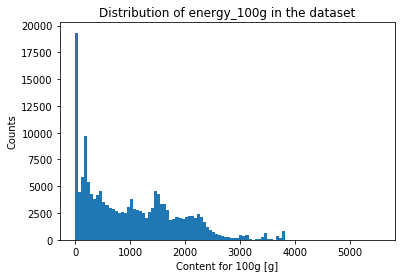

C:\Users\grego\Anaconda3\envs\ada\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\grego\Anaconda3\envs\ada\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


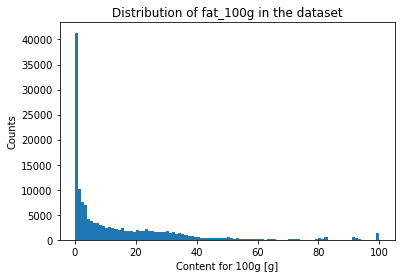

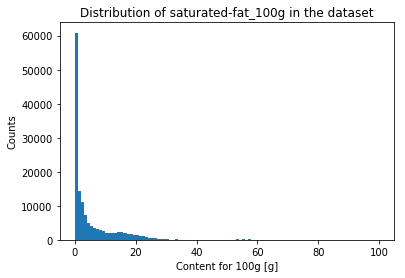

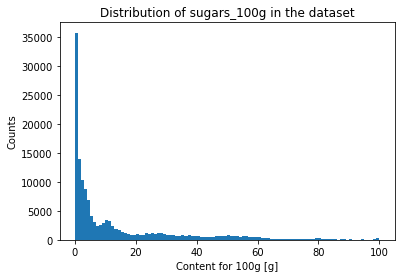

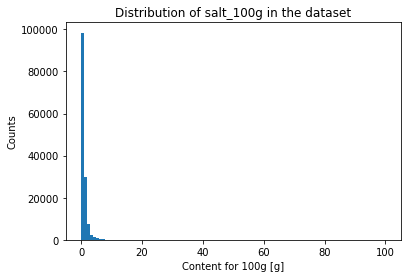

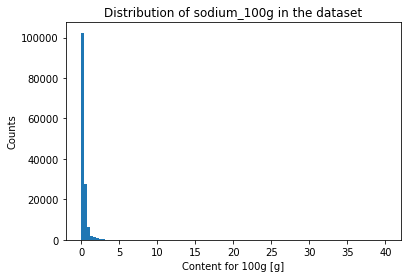

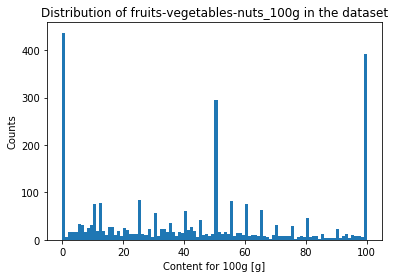

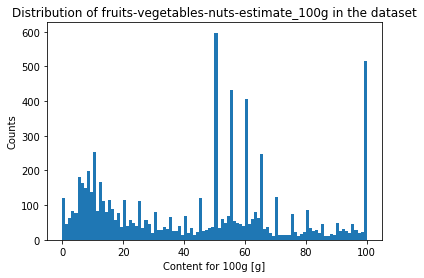

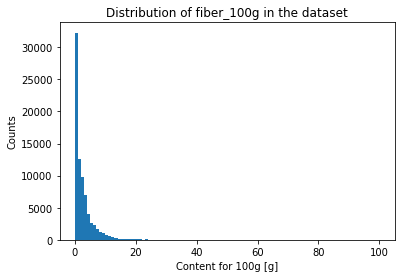

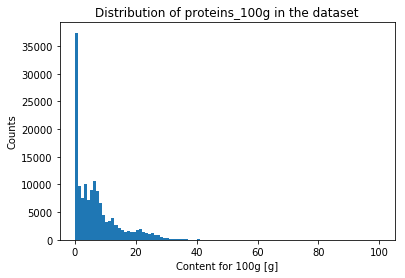

In [17]:
for index in range(2, len(data_food.columns)):
    column = data_food.columns[index]
    plt.hist(data_food[column], bins = 100);
    plt.title('Distribution of {} in the dataset'.format(column));
    plt.ylabel('Counts');
    plt.xlabel('Content for 100g [g]');
    plt.axis('tight');
    plt.show()

In [18]:
data_food.corr(method ='pearson')

energy_100g  fat_100g  \
energy_100g                              1.000000  0.817607   
fat_100g                                 0.817607  1.000000   
saturated-fat_100g                       0.618850  0.730859   
sugars_100g                              0.292799 -0.057920   
salt_100g                               -0.036228 -0.008548   
sodium_100g                             -0.036232 -0.008553   
fruits-vegetables-nuts_100g             -0.172822 -0.165297   
fruits-vegetables-nuts-estimate_100g    -0.187489 -0.182467   
fiber_100g                               0.244815  0.065044   
proteins_100g                            0.224569  0.138292   

                                      saturated-fat_100g  sugars_100g  \
energy_100g                                     0.618850     0.292799   
fat_100g                                        0.730859    -0.057920   
saturated-fat_100g                              1.000000     0.042599   
sugars_100g                                     0.042599     1.000000   
salt_100g                                      -0.012503    -0.086998   
sodium_100g                                    -0.012503    -0.086999   
fruits-vegetables-nuts_100g                    -0.221458     0.081503   
fruits-vegetables-nuts-estimate_100g           -0.312151     0.088097   
fiber_100g                                      0.022232     0.026772   
proteins_100g                                   0.141980    -0.235284   

                                      salt_100g  sodium_100g  \
energy_100g                           -0.036228    -0.036232   
fat_100g                              -0.008548    -0.008553   
saturated-fat_100g                    -0.012503    -0.012503   
sugars_100g                           -0.086998    -0.086999   
salt_100g                              1.000000     0.999999   
sodium_100g                            0.999999     1.000000   
fruits-vegetables-nuts_100g           -0.103775    -0.103773   
fruits-vegetables-nuts-estimate_100g  -0.055245    -0.055242   
fiber_100g                            -0.004394    -0.004394   
proteins_100g                          0.066834     0.066820   

                                      fruits-vegetables-nuts_100g  \
energy_100g                                             -0.172822   
fat_100g                                                -0.165297   
saturated-fat_100g                                      -0.221458   
sugars_100g                                              0.081503   
salt_100g                                               -0.103775   
sodium_100g                                             -0.103773   
fruits-vegetables-nuts_100g                              1.000000   
fruits-vegetables-nuts-estimate_100g                     0.998090   
fiber_100g                                               0.104843   
proteins_100g                                           -0.212345   

                                      fruits-vegetables-nuts-estimate_100g  \
energy_100g                                                      -0.187489   
fat_100g                                                         -0.182467   
saturated-fat_100g                                               -0.312151   
sugars_100g                                                       0.088097   
salt_100g                                                        -0.055245   
sodium_100g                                                      -0.055242   
fruits-vegetables-nuts_100g                                       0.998090   
fruits-vegetables-nuts-estimate_100g                              1.000000   
fiber_100g                                                        0.096676   
proteins_100g                                                    -0.211749   

                                      fiber_100g  proteins_100g  
energy_100g                             0.244815       0.224569  
fat_100g                                0.065044       0.138292  
saturated-fat_100g

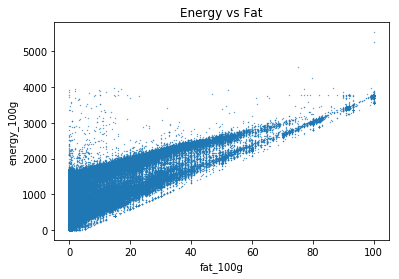

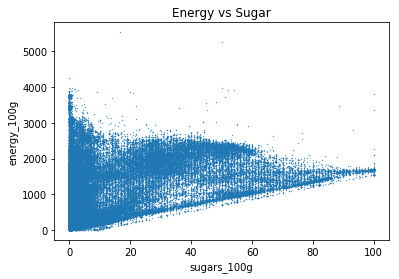

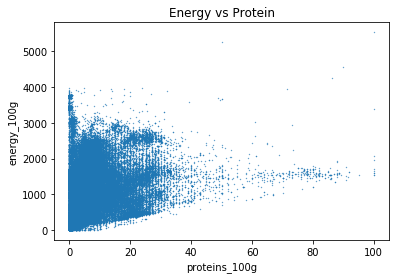

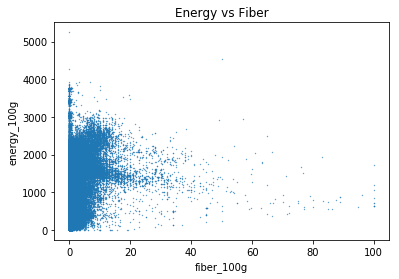

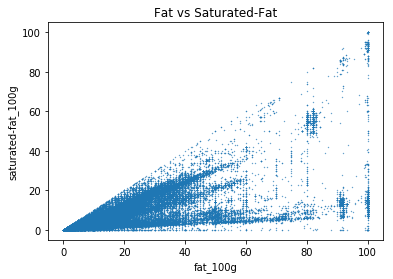

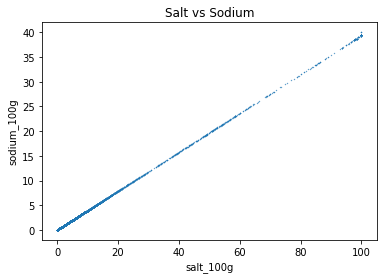

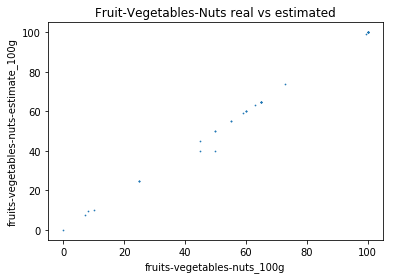

In [19]:
plt.scatter(data_food['fat_100g'],data_food['energy_100g'], s=0.1);
plt.title('Energy vs Fat');
plt.xlabel('fat_100g');
plt.ylabel('energy_100g');
plt.show()

plt.scatter(data_food['sugars_100g'],data_food['energy_100g'], s=0.1);
plt.title('Energy vs Sugar');
plt.xlabel('sugars_100g');
plt.ylabel('energy_100g');
plt.show()

plt.scatter(data_food['proteins_100g'],data_food['energy_100g'], s=0.1);
plt.title('Energy vs Protein');
plt.xlabel('proteins_100g');
plt.ylabel('energy_100g');
plt.show()

plt.scatter(data_food['fiber_100g'],data_food['energy_100g'], s=0.1);
plt.title('Energy vs Fiber');
plt.xlabel('fiber_100g');
plt.ylabel('energy_100g');
plt.show()

plt.scatter(data_food['fat_100g'],data_food['saturated-fat_100g'], s=0.1);
plt.title('Fat vs Saturated-Fat');
plt.ylabel('saturated-fat_100g');
plt.xlabel('fat_100g');
plt.show()

plt.scatter(data_food['salt_100g'],data_food['sodium_100g'], s=0.1);
plt.title('Salt vs Sodium');
plt.ylabel('sodium_100g');
plt.xlabel('salt_100g');
plt.show()

plt.scatter(data_food['fruits-vegetables-nuts_100g'],data_food['fruits-vegetables-nuts-estimate_100g'], s=0.5);
plt.title('Fruit-Vegetables-Nuts real vs estimated');
plt.ylabel('fruits-vegetables-nuts-estimate_100g');
plt.xlabel('fruits-vegetables-nuts_100g');
plt.show()

In [20]:
data_nutriscore = data_clean[['nutrition-score-fr_100g','nutrition_grade_fr']]

data_food_nutri = data_food.join(data_nutriscore)

data_food_nutri = data_food_nutri[~data_food_nutri.nutrition_grade_fr.isna()]

data_food_nutri['Predicted_NutriScore_grade'] = np.nan
data_food_nutri['Predicted_NutriScore_score'] = np.nan

for index in range(len(data_food_nutri)):
    
    print(index/len(data_food_nutri))

    product = data_food_nutri.iloc[[index]]
    nutriscore, final_score = computeNutriScore(product)
    data_food_nutri.loc[product.index[0], 'Predicted_NutriScore_grade'] = nutriscore
    data_food_nutri.loc[product.index[0], 'Predicted_NutriScore_score'] = final_score

0.0
7.364529480211509e-06
1.4729058960423018e-05
2.2093588440634527e-05
2.9458117920846036e-05
3.682264740105755e-05
4.4187176881269054e-05
5.1551706361480566e-05
5.891623584169207e-05
6.628076532190358e-05
7.36452948021151e-05
8.100982428232661e-05
8.837435376253811e-05
9.573888324274962e-05
0.00010310341272296113
0.00011046794220317264
0.00011783247168338414
0.00012519700116359566
0.00013256153064380717
0.00013992606012401868
0.0001472905896042302
0.0001546551190844417
0.00016201964856465322
0.0001693841780448647
0.00017674870752507622
0.00018411323700528773
0.00019147776648549924
0.00019884229596571075
0.00020620682544592226
0.00021357135492613378
0.0002209358844063453
0.00022830041388655677
0.0002356649433667683
0.0002430294728469798
0.0002503940023271913
0.0002577585318074028
0.00026512306128761434
0.00027248759076782585
0.00027985212024803736
0.0002872166497282489
0.0002945811792084604
0.0003019457086886719
0.0003093102381688834
0.0003166747676490949
0.00032403929712930643
0.0003

0.002835343849881431
0.0028427083793616426
0.002850072908841854
0.0028574374383220657
0.0028648019678022773
0.0028721664972824884
0.0028795310267627
0.0028868955562429115
0.002894260085723123
0.0029016246152033347
0.0029089891446835462
0.002916353674163758
0.0029237182036439694
0.0029310827331241805
0.002938447262604392
0.0029458117920846036
0.002953176321564815
0.0029605408510450268
0.0029679053805252383
0.00297526991000545
0.0029826344394856615
0.0029899989689658726
0.002997363498446084
0.0030047280279262957
0.0030120925574065073
0.003019457086886719
0.0030268216163669304
0.003034186145847142
0.003041550675327353
0.0030489152048075647
0.0030562797342877763
0.003063644263767988
0.0030710087932481994
0.003078373322728411
0.0030857378522086225
0.003093102381688834
0.0031004669111690452
0.003107831440649257
0.0031151959701294684
0.00312256049960968
0.0031299250290898915
0.003137289558570103
0.0031446540880503146
0.0031520186175305258
0.0031593831470107373
0.003166747676490949
0.003174112

0.005788520171446246
0.005795884700926458
0.005803249230406669
0.005810613759886881
0.0058179782893670925
0.005825342818847304
0.005832707348327516
0.005840071877807727
0.005847436407287939
0.00585480093676815
0.005862165466248361
0.005869529995728573
0.005876894525208784
0.005884259054688996
0.005891623584169207
0.005898988113649419
0.00590635264312963
0.005913717172609842
0.0059210817020900535
0.005928446231570265
0.005935810761050477
0.005943175290530688
0.0059505398200109
0.005957904349491111
0.005965268878971323
0.005972633408451534
0.005979997937931745
0.005987362467411957
0.005994726996892168
0.00600209152637238
0.0060094560558525915
0.006016820585332803
0.006024185114813015
0.006031549644293226
0.006038914173773438
0.006046278703253649
0.006053643232733861
0.0060610077622140724
0.006068372291694284
0.006075736821174496
0.006083101350654706
0.006090465880134918
0.006097830409615129
0.006105194939095341
0.0061125594685755525
0.006119923998055764
0.006127288527535976
0.00613465305

0.008749061022491273
0.008756425551971484
0.008763790081451697
0.008771154610931907
0.00877851914041212
0.00878588366989233
0.008793248199372543
0.008800612728852754
0.008807977258332966
0.008815341787813177
0.008822706317293387
0.0088300708467736
0.00883743537625381
0.008844799905734023
0.008852164435214234
0.008859528964694446
0.008866893494174657
0.00887425802365487
0.00888162255313508
0.008888987082615292
0.008896351612095503
0.008903716141575715
0.008911080671055926
0.008918445200536139
0.00892580973001635
0.00893317425949656
0.008940538788976772
0.008947903318456983
0.008955267847937196
0.008962632377417406
0.008969996906897619
0.00897736143637783
0.008984725965858042
0.008992090495338253
0.008999455024818465
0.009006819554298676
0.009014184083778888
0.009021548613259099
0.009028913142739311
0.009036277672219522
0.009043642201699733
0.009051006731179945
0.009058371260660156
0.009065735790140368
0.009073100319620579
0.009080464849100791
0.009087829378581002
0.009095193908061214
0.

0.011775882638858204
0.011783247168338415
0.011790611697818627
0.011797976227298838
0.01180534075677905
0.01181270528625926
0.011820069815739473
0.011827434345219684
0.011834798874699895
0.011842163404180107
0.011849527933660318
0.01185689246314053
0.011864256992620741
0.011871621522100953
0.011878986051581164
0.011886350581061376
0.011893715110541587
0.0119010796400218
0.01190844416950201
0.011915808698982223
0.011923173228462433
0.011930537757942646
0.011937902287422857
0.011945266816903067
0.01195263134638328
0.01195999587586349
0.011967360405343703
0.011974724934823914
0.011982089464304126
0.011989453993784337
0.011996818523264549
0.01200418305274476
0.012011547582224972
0.012018912111705183
0.012026276641185395
0.012033641170665606
0.012041005700145819
0.01204837022962603
0.01205573475910624
0.012063099288586452
0.012070463818066663
0.012077828347546875
0.012085192877027086
0.012092557406507299
0.01209992193598751
0.012107286465467722
0.012114650994947932
0.012122015524428145
0.01

0.014846891432106402
0.014854255961586614
0.014861620491066825
0.014868985020547038
0.014876349550027248
0.01488371407950746
0.014891078608987671
0.014898443138467884
0.014905807667948094
0.014913172197428307
0.014920536726908518
0.01492790125638873
0.01493526578586894
0.014942630315349153
0.014949994844829364
0.014957359374309575
0.014964723903789787
0.014972088433269998
0.01497945296275021
0.01498681749223042
0.014994182021710633
0.015001546551190844
0.015008911080671056
0.015016275610151267
0.01502364013963148
0.01503100466911169
0.015038369198591903
0.015045733728072113
0.015053098257552326
0.015060462787032537
0.015067827316512747
0.01507519184599296
0.01508255637547317
0.015089920904953383
0.015097285434433593
0.015104649963913806
0.015112014493394017
0.015119379022874229
0.01512674355235444
0.015134108081834652
0.015141472611314863
0.015148837140795075
0.015156201670275286
0.015163566199755498
0.01517093072923571
0.01517829525871592
0.015185659788196132
0.015193024317676343
0.01

0.017785338694710794
0.017792703224191006
0.01780006775367122
0.01780743228315143
0.01781479681263164
0.017822161342111852
0.017829525871592065
0.017836890401072277
0.017844254930552486
0.0178516194600327
0.01785898398951291
0.01786634851899312
0.017873713048473332
0.017881077577953545
0.017888442107433757
0.017895806636913966
0.01790317116639418
0.01791053569587439
0.017917900225354604
0.017925264754834812
0.017932629284315025
0.017939993813795237
0.01794735834327545
0.01795472287275566
0.01796208740223587
0.017969451931716084
0.017976816461196293
0.017984180990676505
0.017991545520156717
0.01799891004963693
0.01800627457911714
0.01801363910859735
0.018021003638077564
0.018028368167557776
0.018035732697037985
0.018043097226518198
0.01805046175599841
0.018057826285478622
0.01806519081495883
0.018072555344439044
0.018079919873919256
0.018087284403399465
0.018094648932879678
0.01810201346235989
0.018109377991840103
0.01811674252132031
0.018124107050800524
0.018131471580280736
0.018138836

0.02083425389951836
0.020841618428998572
0.020848982958478784
0.020856347487958993
0.020863712017439206
0.02087107654691942
0.020878441076399627
0.02088580560587984
0.020893170135360052
0.020900534664840265
0.020907899194320474
0.020915263723800686
0.0209226282532809
0.02092999278276111
0.02093735731224132
0.020944721841721532
0.020952086371201745
0.020959450900681957
0.020966815430162166
0.02097417995964238
0.02098154448912259
0.0209889090186028
0.020996273548083012
0.021003638077563225
0.021011002607043437
0.021018367136523646
0.02102573166600386
0.02103309619548407
0.021040460724964283
0.021047825254444492
0.021055189783924705
0.021062554313404917
0.02106991884288513
0.02107728337236534
0.02108464790184555
0.021092012431325764
0.021099376960805973
0.021106741490286185
0.021114106019766397
0.02112147054924661
0.02112883507872682
0.02113619960820703
0.021143564137687244
0.021150928667167456
0.021158293196647665
0.021165657726127877
0.02117302225560809
0.021180386785088302
0.0211877513

0.023772701162122753
0.023780065691602962
0.023787430221083174
0.023794794750563387
0.0238021592800436
0.023809523809523808
0.02381688833900402
0.023824252868484233
0.023831617397964446
0.023838981927444654
0.023846346456924867
0.02385371098640508
0.023861075515885292
0.0238684400453655
0.023875804574845713
0.023883169104325926
0.023890533633806135
0.023897898163286347
0.02390526269276656
0.023912627222246772
0.02391999175172698
0.023927356281207193
0.023934720810687406
0.023942085340167618
0.023949449869647827
0.02395681439912804
0.023964178928608252
0.023971543458088464
0.023978907987568673
0.023986272517048886
0.023993637046529098
0.024001001576009307
0.02400836610548952
0.024015730634969732
0.024023095164449944
0.024030459693930153
0.024037824223410366
0.02404518875289058
0.02405255328237079
0.024059917811851
0.024067282341331212
0.024074646870811425
0.024082011400291637
0.024089375929771846
0.02409674045925206
0.02410410498873227
0.02411146951821248
0.024118834047692692
0.02412619

0.026711148424727143
0.026718512954207355
0.026725877483687568
0.02673324201316778
0.02674060654264799
0.0267479710721282
0.026755335601608414
0.026762700131088626
0.026770064660568835
0.026777429190049048
0.02678479371952926
0.02679215824900947
0.02679952277848968
0.026806887307969894
0.026814251837450107
0.026821616366930316
0.026828980896410528
0.02683634542589074
0.026843709955370953
0.026851074484851162
0.026858439014331374
0.026865803543811587
0.0268731680732918
0.026880532602772008
0.02688789713225222
0.026895261661732433
0.026902626191212642
0.026909990720692854
0.026917355250173067
0.02692471977965328
0.026932084309133488
0.0269394488386137
0.026946813368093913
0.026954177897574125
0.026961542427054334
0.026968906956534547
0.02697627148601476
0.02698363601549497
0.02699100054497518
0.026998365074455393
0.027005729603935606
0.027013094133415815
0.027020458662896027
0.02702782319237624
0.027035187721856452
0.02704255225133666
0.027049916780816873
0.027057281310297086
0.027064645

0.02981161533589619
0.0298189798653764
0.029826344394856614
0.029833708924336823
0.029841073453817035
0.029848437983297248
0.02985580251277746
0.02986316704225767
0.02987053157173788
0.029877896101218094
0.029885260630698306
0.029892625160178515
0.029899989689658728
0.02990735421913894
0.02991471874861915
0.02992208327809936
0.029929447807579574
0.029936812337059786
0.029944176866539995
0.029951541396020208
0.02995890592550042
0.029966270454980633
0.02997363498446084
0.029980999513941054
0.029988364043421267
0.02999572857290148
0.030003093102381688
0.0300104576318619
0.030017822161342113
0.030025186690822322
0.030032551220302534
0.030039915749782747
0.03004728027926296
0.030054644808743168
0.03006200933822338
0.030069373867703593
0.030076738397183805
0.030084102926664014
0.030091467456144227
0.03009883198562444
0.03010619651510465
0.03011356104458486
0.030120925574065073
0.030128290103545285
0.030135654633025494
0.030143019162505707
0.03015038369198592
0.030157748221466132
0.0301651127

0.03280897883434227
0.032816343363822484
0.032823707893302696
0.03283107242278291
0.03283843695226312
0.032845801481743334
0.032853166011223546
0.03286053054070375
0.032867895070183964
0.032875259599664176
0.03288262412914439
0.0328899886586246
0.032897353188104814
0.032904717717585026
0.03291208224706523
0.032919446776545444
0.032926811306025656
0.03293417583550587
0.03294154036498608
0.032948904894466294
0.032956269423946506
0.03296363395342672
0.032970998482906924
0.03297836301238714
0.03298572754186735
0.03299309207134756
0.033000456600827774
0.033007821130307986
0.0330151856597882
0.033022550189268404
0.03302991471874862
0.03303727924822883
0.03304464377770904
0.033052008307189254
0.033059372836669466
0.03306673736614968
0.03307410189562989
0.0330814664251101
0.03308883095459031
0.03309619548407052
0.033103560013550734
0.033110924543030947
0.03311828907251116
0.03312565360199137
0.03313301813147158
0.03314038266095179
0.033147747190432
0.033155111719912214
0.03316247624939243
0.03

0.03591681027499153
0.03592417480447174
0.035931539333951955
0.03593890386343217
0.03594626839291238
0.035953632922392585
0.0359609974518728
0.03596836198135301
0.03597572651083322
0.035983091040313435
0.03599045556979365
0.03599782009927386
0.03600518462875407
0.03601254915823428
0.03601991368771449
0.0360272782171947
0.036034642746674915
0.03604200727615513
0.03604937180563534
0.03605673633511555
0.03606410086459576
0.03607146539407597
0.03607882992355618
0.036086194453036395
0.03609355898251661
0.03610092351199682
0.03610828804147703
0.036115652570957245
0.03612301710043745
0.03613038162991766
0.036137746159397875
0.03614511068887809
0.0361524752183583
0.03615983974783851
0.036167204277318725
0.03617456880679893
0.03618193333627914
0.036189297865759355
0.03619666239523957
0.03620402692471978
0.03621139145419999
0.036218755983680205
0.03622612051316042
0.03623348504264062
0.036240849572120835
0.03624821410160105
0.03625557863108126
0.03626294316056147
0.036270307690041685
0.036277672

0.03907619342200227
0.03908355795148248
0.03909092248096269
0.039098287010442906
0.03910565153992311
0.039113016069403324
0.039120380598883536
0.03912774512836375
0.03913510965784396
0.039142474187324174
0.039149838716804386
0.03915720324628459
0.039164567775764804
0.039171932305245016
0.03917929683472523
0.03918666136420544
0.039194025893685654
0.039201390423165866
0.03920875495264608
0.039216119482126284
0.039223484011606496
0.03923084854108671
0.03923821307056692
0.039245577600047134
0.039252942129527346
0.03926030665900756
0.039267671188487764
0.03927503571796798
0.03928240024744819
0.0392897647769284
0.039297129306408614
0.039304493835888826
0.03931185836536904
0.03931922289484925
0.03932658742432946
0.03933395195380967
0.03934131648328988
0.039348681012770094
0.039356045542250306
0.03936341007173052
0.03937077460121073
0.03937813913069094
0.03938550366017115
0.03939286818965136
0.039400232719131574
0.039407597248611786
0.039414961778092
0.03942232630757221
0.039429690837052424
0.

0.04222084751005258
0.042228212039532795
0.04223557656901301
0.04224294109849322
0.04225030562797343
0.04225767015745364
0.04226503468693385
0.04227239921641406
0.042279763745894275
0.04228712827537449
0.0422944928048547
0.04230185733433491
0.04230922186381512
0.04231658639329533
0.04232395092277554
0.042331315452255755
0.04233867998173597
0.04234604451121618
0.04235340904069639
0.042360773570176605
0.04236813809965681
0.04237550262913702
0.042382867158617235
0.04239023168809745
0.04239759621757766
0.04240496074705787
0.042412325276538085
0.04241968980601829
0.0424270543354985
0.042434418864978715
0.04244178339445893
0.04244914792393914
0.04245651245341935
0.042463876982899565
0.04247124151237978
0.04247860604185998
0.042485970571340195
0.04249333510082041
0.04250069963030062
0.04250806415978083
0.042515428689261045
0.04252279321874126
0.04253015774822146
0.042537522277701675
0.04254488680718189
0.0425522513366621
0.04255961586614231
0.042566980395622525
0.04257434492510274
0.042581709

0.04527712724434036
0.04528449177382057
0.04529185630330078
0.04529922083278099
0.045306585362261204
0.045313949891741416
0.04532131442122163
0.04532867895070184
0.04533604348018205
0.045343408009662266
0.04535077253914247
0.045358137068622684
0.045365501598102896
0.04537286612758311
0.04538023065706332
0.04538759518654353
0.045394959716023746
0.04540232424550395
0.045409688774984164
0.045417053304464376
0.04542441783394459
0.0454317823634248
0.045439146892905014
0.045446511422385226
0.04545387595186544
0.045461240481345644
0.045468605010825856
0.04547596954030607
0.04548333406978628
0.045490698599266494
0.045498063128746706
0.04550542765822692
0.045512792187707124
0.045520156717187336
0.04552752124666755
0.04553488577614776
0.045542250305627974
0.045549614835108186
0.0455569793645884
0.04556434389406861
0.045571708423548817
0.04557907295302903
0.04558643748250924
0.045593802011989454
0.045601166541469666
0.04560853107094988
0.04561589560043009
0.0456232601299103
0.04563062465939051
0.

0.04836286509654898
0.048370229626029194
0.04837759415550941
0.04838495868498962
0.048392323214469825
0.04839968774395004
0.04840705227343025
0.04841441680291046
0.048421781332390675
0.04842914586187089
0.0484365103913511
0.048443874920831305
0.04845123945031152
0.04845860397979173
0.04846596850927194
0.048473333038752155
0.04848069756823237
0.04848806209771258
0.04849542662719279
0.048502791156673
0.04851015568615321
0.04851752021563342
0.048524884745113635
0.04853224927459385
0.04853961380407406
0.04854697833355427
0.04855434286303448
0.04856170739251469
0.0485690719219949
0.048576436451475115
0.04858380098095533
0.04859116551043554
0.04859853003991575
0.048605894569395965
0.04861325909887617
0.04862062362835638
0.048627988157836595
0.04863535268731681
0.04864271721679702
0.04865008174627723
0.048657446275757445
0.04866481080523765
0.04867217533471786
0.048679539864198075
0.04868690439367829
0.0486942689231585
0.04870163345263871
0.048708997982118925
0.04871636251159914
0.04872372704

0.05141178030135655
0.05141914483083676
0.051426509360316966
0.05143387388979718
0.05144123841927739
0.0514486029487576
0.051455967478237816
0.05146333200771803
0.05147069653719824
0.05147806106667845
0.05148542559615866
0.05149279012563887
0.05150015465511908
0.051507519184599296
0.05151488371407951
0.05152224824355972
0.05152961277303993
0.05153697730252014
0.05154434183200035
0.05155170636148056
0.051559070890960776
0.05156643542044099
0.0515737999499212
0.05158116447940141
0.051588529008881626
0.05159589353836183
0.051603258067842044
0.051610622597322256
0.05161798712680247
0.05162535165628268
0.05163271618576289
0.051640080715243106
0.05164744524472331
0.051654809774203524
0.051662174303683736
0.05166953883316395
0.05167690336264416
0.05168426789212437
0.051691632421604586
0.0516989969510848
0.051706361480565004
0.051713726010045216
0.05172109053952543
0.05172845506900564
0.051735819598485853
0.051743184127966066
0.05175054865744628
0.051757913186926484
0.051765277716406696
0.0517

0.054512247212525594
0.05451961174200581
0.05452697627148601
0.054534340800966224
0.05454170533044644
0.05454906985992665
0.05455643438940686
0.054563798918887074
0.05457116344836729
0.05457852797784749
0.054585892507327705
0.05459325703680792
0.05460062156628813
0.05460798609576834
0.054615350625248554
0.05462271515472877
0.05463007968420898
0.054637444213689185
0.0546448087431694
0.05465217327264961
0.05465953780212982
0.054666902331610034
0.05467426686109025
0.05468163139057046
0.054688995920050665
0.05469636044953088
0.05470372497901109
0.0547110895084913
0.054718454037971515
0.05472581856745173
0.05473318309693194
0.05474054762641215
0.05474791215589236
0.05475527668537257
0.05476264121485278
0.054770005744332995
0.05477737027381321
0.05478473480329342
0.05479209933277363
0.05479946386225384
0.05480682839173405
0.05481419292121426
0.054821557450694475
0.05482892198017469
0.0548362865096549
0.05484365103913511
0.054851015568615324
0.05485838009809553
0.05486574462757574
0.054873109

0.05762744318265506
0.05763480771213527
0.05764217224161548
0.057649536771095695
0.05765690130057591
0.05766426583005612
0.057671630359536326
0.05767899488901654
0.05768635941849675
0.05769372394797696
0.057701088477457176
0.05770845300693739
0.0577158175364176
0.05772318206589781
0.05773054659537802
0.05773791112485823
0.05774527565433844
0.057752640183818656
0.05776000471329887
0.05776736924277908
0.05777473377225929
0.0577820983017395
0.05778946283121971
0.05779682736069992
0.057804191890180136
0.05781155641966035
0.05781892094914056
0.05782628547862077
0.057833650008100985
0.05784101453758119
0.0578483790670614
0.057855743596541616
0.05786310812602183
0.05787047265550204
0.05787783718498225
0.057885201714462466
0.05789256624394267
0.057899930773422884
0.057907295302903096
0.05791465983238331
0.05792202436186352
0.05792938889134373
0.057936753420823946
0.05794411795030416
0.057951482479784364
0.057958847009264576
0.05796621153874479
0.057973576068225
0.05798094059770521
0.0579883051

0.06074263915278453
0.06075000368226474
0.060757368211744954
0.060764732741225166
0.06077209727070537
0.060779461800185584
0.0607868263296658
0.06079419085914601
0.06080155538862622
0.060808919918106434
0.06081628444758665
0.06082364897706685
0.060831013506547064
0.06083837803602728
0.06084574256550749
0.0608531070949877
0.060860471624467914
0.06086783615394813
0.06087520068342834
0.060882565212908545
0.06088992974238876
0.06089729427186897
0.06090465880134918
0.060912023330829394
0.06091938786030961
0.06092675238978982
0.060934116919270025
0.06094148144875024
0.06094884597823045
0.06095621050771066
0.060963575037190874
0.06097093956667109
0.0609783040961513
0.06098566862563151
0.06099303315511172
0.06100039768459193
0.06100776221407214
0.061015126743552354
0.06102249127303257
0.06102985580251278
0.06103722033199299
0.0610445848614732
0.06105194939095341
0.06105931392043362
0.061066678449913835
0.06107404297939405
0.06108140750887426
0.06108877203835447
0.061096136567834684
0.061103501

0.06387256418187442
0.06387992871135463
0.06388729324083485
0.06389465777031506
0.06390202229979526
0.06390938682927548
0.06391675135875569
0.0639241158882359
0.06393148041771611
0.06393884494719633
0.06394620947667654
0.06395357400615674
0.06396093853563696
0.06396830306511717
0.06397566759459739
0.06398303212407759
0.06399039665355781
0.06399776118303802
0.06400512571251822
0.06401249024199844
0.06401985477147865
0.06402721930095887
0.06403458383043907
0.06404194835991929
0.0640493128893995
0.0640566774188797
0.06406404194835992
0.06407140647784013
0.06407877100732035
0.06408613553680055
0.06409350006628077
0.06410086459576098
0.0641082291252412
0.0641155936547214
0.0641229581842016
0.06413032271368183
0.06413768724316203
0.06414505177264225
0.06415241630212246
0.06415978083160268
0.06416714536108288
0.06417450989056309
0.0641818744200433
0.06418923894952351
0.06419660347900373
0.06420396800848394
0.06421133253796416
0.06421869706744436
0.06422606159692457
0.06423342612640479
0.06424

0.06692884391616219
0.06693620844564241
0.06694357297512261
0.06695093750460283
0.06695830203408304
0.06696566656356326
0.06697303109304346
0.06698039562252368
0.06698776015200389
0.0669951246814841
0.06700248921096431
0.06700985374044452
0.06701721826992474
0.06702458279940494
0.06703194732888516
0.06703931185836537
0.06704667638784557
0.0670540409173258
0.067061405446806
0.06706876997628622
0.06707613450576642
0.06708349903524664
0.06709086356472685
0.06709822809420705
0.06710559262368727
0.06711295715316748
0.0671203216826477
0.0671276862121279
0.06713505074160812
0.06714241527108833
0.06714977980056853
0.06715714433004875
0.06716450885952896
0.06717187338900918
0.06717923791848938
0.0671866024479696
0.06719396697744981
0.06720133150693003
0.06720869603641023
0.06721606056589044
0.06722342509537066
0.06723078962485086
0.06723815415433108
0.06724551868381129
0.06725288321329151
0.06726024774277171
0.06726761227225192
0.06727497680173214
0.06728234133121234
0.06728970586069256
0.06729

0.06997775912096976
0.06998512365044997
0.06999248817993019
0.06999985270941039
0.07000721723889061
0.07001458176837082
0.07002194629785104
0.07002931082733124
0.07003667535681145
0.07004403988629167
0.07005140441577187
0.07005876894525209
0.0700661334747323
0.07007349800421252
0.07008086253369272
0.07008822706317293
0.07009559159265315
0.07010295612213335
0.07011032065161357
0.07011768518109378
0.070125049710574
0.0701324142400542
0.07013977876953441
0.07014714329901463
0.07015450782849483
0.07016187235797505
0.07016923688745526
0.07017660141693548
0.07018396594641568
0.07019133047589589
0.07019869500537611
0.07020605953485631
0.07021342406433653
0.07022078859381674
0.07022815312329696
0.07023551765277716
0.07024288218225738
0.07025024671173759
0.0702576112412178
0.07026497577069801
0.07027234030017822
0.07027970482965844
0.07028706935913864
0.07029443388861886
0.07030179841809907
0.07030916294757927
0.07031652747705949
0.0703238920065397
0.07033125653601992
0.07033862106550012
0.0703

0.07308559056161902
0.07309295509109923
0.07310031962057945
0.07310768415005965
0.07311504867953987
0.07312241320902008
0.07312977773850028
0.0731371422679805
0.0731445067974607
0.07315187132694093
0.07315923585642113
0.07316660038590135
0.07317396491538156
0.07318132944486176
0.07318869397434198
0.07319605850382219
0.0732034230333024
0.07321078756278261
0.07321815209226283
0.07322551662174304
0.07323288115122324
0.07324024568070346
0.07324761021018367
0.07325497473966389
0.07326233926914409
0.07326970379862431
0.07327706832810452
0.07328443285758472
0.07329179738706494
0.07329916191654515
0.07330652644602537
0.07331389097550557
0.07332125550498579
0.073328620034466
0.07333598456394622
0.07334334909342642
0.07335071362290663
0.07335807815238685
0.07336544268186705
0.07337280721134727
0.07338017174082748
0.0733875362703077
0.0733949007997879
0.07340226532926811
0.07340962985874833
0.07341699438822853
0.07342435891770875
0.07343172344718896
0.07343908797666918
0.07344645250614938
0.07345

0.07621551559070891
0.07622288012018912
0.07623024464966933
0.07623760917914954
0.07624497370862976
0.07625233823810997
0.07625970276759018
0.07626706729707039
0.0762744318265506
0.07628179635603081
0.07628916088551102
0.07629652541499124
0.07630388994447145
0.07631125447395166
0.07631861900343187
0.07632598353291208
0.0763333480623923
0.0763407125918725
0.07634807712135272
0.07635544165083293
0.07636280618031314
0.07637017070979335
0.07637753523927357
0.07638489976875378
0.07639226429823398
0.0763996288277142
0.0764069933571944
0.07641435788667462
0.07642172241615483
0.07642908694563505
0.07643645147511526
0.07644381600459546
0.07645118053407568
0.07645854506355589
0.0764659095930361
0.07647327412251631
0.07648063865199653
0.07648800318147674
0.07649536771095694
0.07650273224043716
0.07651009676991737
0.07651746129939759
0.07652482582887779
0.07653219035835801
0.07653955488783822
0.07654691941731842
0.07655428394679864
0.07656164847627885
0.07656901300575907
0.07657637753523927
0.0765

0.07942645044408113
0.07943381497356133
0.07944117950304155
0.07944854403252176
0.07945590856200198
0.07946327309148218
0.0794706376209624
0.07947800215044261
0.07948536667992281
0.07949273120940303
0.07950009573888324
0.07950746026836346
0.07951482479784366
0.07952218932732388
0.07952955385680409
0.0795369183862843
0.07954428291576451
0.07955164744524472
0.07955901197472494
0.07956637650420514
0.07957374103368536
0.07958110556316557
0.07958847009264577
0.079595834622126
0.0796031991516062
0.07961056368108642
0.07961792821056662
0.07962529274004684
0.07963265726952705
0.07964002179900725
0.07964738632848747
0.07965475085796768
0.0796621153874479
0.0796694799169281
0.07967684444640832
0.07968420897588853
0.07969157350536875
0.07969893803484895
0.07970630256432916
0.07971366709380938
0.07972103162328958
0.0797283961527698
0.07973576068225001
0.07974312521173023
0.07975048974121043
0.07975785427069064
0.07976521880017086
0.07977258332965106
0.07977994785913128
0.07978731238861149
0.079794

0.0826079271795325
0.08261529170901272
0.08262265623849292
0.08263002076797313
0.08263738529745335
0.08264474982693355
0.08265211435641377
0.08265947888589398
0.0826668434153742
0.0826742079448544
0.08268157247433461
0.08268893700381483
0.08269630153329503
0.08270366606277525
0.08271103059225546
0.08271839512173568
0.08272575965121588
0.0827331241806961
0.08274048871017631
0.08274785323965651
0.08275521776913673
0.08276258229861694
0.08276994682809716
0.08277731135757736
0.08278467588705758
0.08279204041653779
0.082799404946018
0.08280676947549821
0.08281413400497842
0.08282149853445864
0.08282886306393884
0.08283622759341906
0.08284359212289927
0.08285095665237947
0.08285832118185969
0.0828656857113399
0.08287305024082012
0.08288041477030032
0.08288777929978054
0.08289514382926075
0.08290250835874095
0.08290987288822117
0.08291723741770138
0.0829246019471816
0.0829319664766618
0.08293933100614202
0.08294669553562223
0.08295406006510245
0.08296142459458265
0.08296878912406286
0.0829761

0.08572312314966196
0.08573048767914218
0.08573785220862239
0.0857452167381026
0.08575258126758281
0.08575994579706303
0.08576731032654324
0.08577467485602344
0.08578203938550366
0.08578940391498387
0.08579676844446409
0.08580413297394429
0.08581149750342451
0.08581886203290472
0.08582622656238494
0.08583359109186514
0.08584095562134535
0.08584832015082557
0.08585568468030577
0.08586304920978599
0.0858704137392662
0.08587777826874642
0.08588514279822662
0.08589250732770683
0.08589987185718705
0.08590723638666725
0.08591460091614747
0.08592196544562768
0.0859293299751079
0.0859366945045881
0.0859440590340683
0.08595142356354853
0.08595878809302873
0.08596615262250895
0.08597351715198916
0.08598088168146938
0.08598824621094958
0.08599561074042979
0.08600297526991
0.08601033979939021
0.08601770432887043
0.08602506885835064
0.08603243338783086
0.08603979791731106
0.08604716244679128
0.08605452697627149
0.08606189150575169
0.08606925603523191
0.08607662056471212
0.08608398509419234
0.086091

0.08882359006083101
0.08883095459031122
0.08883831911979144
0.08884568364927165
0.08885304817875186
0.08886041270823207
0.08886777723771229
0.0888751417671925
0.0888825062966727
0.08888987082615292
0.08889723535563313
0.08890459988511334
0.08891196441459355
0.08891932894407377
0.08892669347355397
0.08893405800303418
0.0889414225325144
0.0889487870619946
0.08895615159147482
0.08896351612095503
0.08897088065043525
0.08897824517991546
0.08898560970939566
0.08899297423887588
0.08900033876835609
0.0890077032978363
0.08901506782731651
0.08902243235679673
0.08902979688627694
0.08903716141575714
0.08904452594523736
0.08905189047471757
0.08905925500419778
0.08906661953367799
0.08907398406315821
0.08908134859263842
0.08908871312211863
0.08909607765159884
0.08910344218107905
0.08911080671055926
0.08911817124003947
0.08912553576951969
0.0891329002989999
0.08914026482848011
0.08914762935796032
0.08915499388744053
0.08916235841692075
0.08916972294640095
0.08917708747588117
0.08918445200536138
0.0891

0.09196087961940112
0.09196824414888133
0.09197560867836153
0.09198297320784175
0.09199033773732196
0.09199770226680218
0.09200506679628238
0.0920124313257626
0.09201979585524281
0.09202716038472301
0.09203452491420323
0.09204188944368344
0.09204925397316366
0.09205661850264386
0.09206398303212408
0.09207134756160429
0.0920787120910845
0.09208607662056471
0.09209344115004492
0.09210080567952514
0.09210817020900534
0.09211553473848556
0.09212289926796577
0.09213026379744597
0.0921376283269262
0.0921449928564064
0.09215235738588662
0.09215972191536682
0.09216708644484704
0.09217445097432725
0.09218181550380747
0.09218918003328767
0.09219654456276788
0.0922039090922481
0.0922112736217283
0.09221863815120852
0.09222600268068873
0.09223336721016895
0.09224073173964915
0.09224809626912936
0.09225546079860958
0.09226282532808978
0.09227018985757
0.09227755438705021
0.09228491891653043
0.09229228344601063
0.09229964797549084
0.09230701250497106
0.09231437703445126
0.09232174156393148
0.0923291

0.09505398200108996
0.09506134653057016
0.09506871106005037
0.09507607558953059
0.09508344011901079
0.09509080464849101
0.09509816917797122
0.09510553370745144
0.09511289823693164
0.09512026276641185
0.09512762729589207
0.09513499182537227
0.09514235635485249
0.0951497208843327
0.09515708541381292
0.09516444994329312
0.09517181447277333
0.09517917900225355
0.09518654353173375
0.09519390806121397
0.09520127259069418
0.0952086371201744
0.0952160016496546
0.09522336617913482
0.09523073070861503
0.09523809523809523
0.09524545976757545
0.09525282429705566
0.09526018882653588
0.09526755335601608
0.0952749178854963
0.09528228241497651
0.09528964694445671
0.09529701147393693
0.09530437600341714
0.09531174053289736
0.09531910506237756
0.09532646959185778
0.09533383412133799
0.09534119865081819
0.09534856318029841
0.09535592770977862
0.09536329223925884
0.09537065676873904
0.09537802129821926
0.09538538582769947
0.09539275035717967
0.09540011488665989
0.0954074794161401
0.09541484394562032
0.095

0.09816917797121942
0.09817654250069963
0.09818390703017985
0.09819127155966005
0.09819863608914027
0.09820600061862048
0.09821336514810068
0.0982207296775809
0.0982280942070611
0.09823545873654133
0.09824282326602153
0.09825018779550175
0.09825755232498196
0.09826491685446216
0.09827228138394238
0.09827964591342259
0.0982870104429028
0.09829437497238301
0.09830173950186323
0.09830910403134344
0.09831646856082366
0.09832383309030386
0.09833119761978407
0.09833856214926429
0.09834592667874449
0.09835329120822471
0.09836065573770492
0.09836802026718514
0.09837538479666534
0.09838274932614555
0.09839011385562577
0.09839747838510597
0.09840484291458619
0.0984122074440664
0.09841957197354662
0.09842693650302682
0.09843430103250703
0.09844166556198725
0.09844903009146745
0.09845639462094767
0.09846375915042788
0.0984711236799081
0.0984784882093883
0.0984858527388685
0.09849321726834873
0.09850058179782893
0.09850794632730915
0.09851531085678936
0.09852267538626958
0.09853003991574978
0.09853

0.10126228035290825
0.10126964488238846
0.10127700941186868
0.10128437394134888
0.1012917384708291
0.10129910300030931
0.10130646752978952
0.10131383205926973
0.10132119658874994
0.10132856111823016
0.10133592564771036
0.10134329017719058
0.10135065470667079
0.10135801923615101
0.10136538376563121
0.10137274829511142
0.10138011282459164
0.10138747735407184
0.10139484188355206
0.10140220641303227
0.10140957094251249
0.1014169354719927
0.1014243000014729
0.10143166453095312
0.10143902906043333
0.10144639358991354
0.10145375811939375
0.10146112264887397
0.10146848717835417
0.10147585170783438
0.1014832162373146
0.1014905807667948
0.10149794529627502
0.10150530982575523
0.10151267435523545
0.10152003888471565
0.10152740341419586
0.10153476794367608
0.10154213247315629
0.1015494970026365
0.10155686153211671
0.10156422606159693
0.10157159059107713
0.10157895512055735
0.10158631965003756
0.10159368417951777
0.10160104870899798
0.10160841323847819
0.10161577776795841
0.10162314229743862
0.1016

0.10439220538199814
0.10439956991147835
0.10440693444095857
0.10441429897043877
0.10442166349991899
0.1044290280293992
0.10443639255887942
0.10444375708835962
0.10445112161783984
0.10445848614732005
0.10446585067680025
0.10447321520628047
0.10448057973576068
0.1044879442652409
0.1044953087947211
0.10450267332420132
0.10451003785368153
0.10451740238316173
0.10452476691264195
0.10453213144212216
0.10453949597160238
0.10454686050108258
0.1045542250305628
0.10456158956004301
0.10456895408952321
0.10457631861900343
0.10458368314848364
0.10459104767796386
0.10459841220744406
0.10460577673692428
0.10461314126640449
0.1046205057958847
0.10462787032536491
0.10463523485484512
0.10464259938432534
0.10464996391380554
0.10465732844328576
0.10466469297276597
0.10467205750224619
0.1046794220317264
0.1046867865612066
0.10469415109068682
0.10470151562016702
0.10470888014964724
0.10471624467912745
0.10472360920860767
0.10473097373808787
0.10473833826756808
0.1047457027970483
0.1047530673265285
0.1047604

0.10754422399952868
0.10755158852900888
0.10755895305848909
0.1075663175879693
0.10757368211744951
0.10758104664692973
0.10758841117640994
0.10759577570589016
0.10760314023537036
0.10761050476485057
0.10761786929433079
0.10762523382381099
0.10763259835329121
0.10763996288277142
0.10764732741225164
0.10765469194173184
0.10766205647121205
0.10766942100069227
0.10767678553017247
0.10768415005965269
0.1076915145891329
0.10769887911861312
0.10770624364809332
0.10771360817757354
0.10772097270705375
0.10772833723653395
0.10773570176601417
0.10774306629549438
0.1077504308249746
0.1077577953544548
0.10776515988393502
0.10777252441341523
0.10777988894289543
0.10778725347237565
0.10779461800185586
0.10780198253133608
0.10780934706081628
0.1078167115902965
0.10782407611977671
0.10783144064925691
0.10783880517873713
0.10784616970821734
0.10785353423769756
0.10786089876717776
0.10786826329665798
0.10787562782613819
0.10788299235561839
0.10789035688509861
0.10789772141457882
0.10790508594405904
0.107

0.11062259732225709
0.11062996185173729
0.11063732638121751
0.11064469091069772
0.11065205544017792
0.11065941996965814
0.11066678449913835
0.11067414902861857
0.11068151355809877
0.11068887808757899
0.1106962426170592
0.1107036071465394
0.11071097167601962
0.11071833620549983
0.11072570073498005
0.11073306526446025
0.11074042979394047
0.11074779432342068
0.11075515885290088
0.1107625233823811
0.1107698879118613
0.11077725244134153
0.11078461697082173
0.11079198150030195
0.11079934602978216
0.11080671055926238
0.11081407508874258
0.11082143961822279
0.110828804147703
0.11083616867718321
0.11084353320666343
0.11085089773614364
0.11085826226562386
0.11086562679510406
0.11087299132458427
0.11088035585406449
0.11088772038354469
0.11089508491302491
0.11090244944250512
0.11090981397198534
0.11091717850146554
0.11092454303094575
0.11093190756042597
0.11093927208990617
0.11094663661938639
0.1109540011488666
0.11096136567834682
0.11096873020782702
0.11097609473730723
0.11098345926678745
0.11099

0.1137083351744657
0.11371569970394592
0.11372306423342612
0.11373042876290634
0.11373779329238655
0.11374515782186675
0.11375252235134697
0.11375988688082718
0.1137672514103074
0.1137746159397876
0.11378198046926782
0.11378934499874803
0.11379670952822823
0.11380407405770845
0.11381143858718866
0.11381880311666888
0.11382616764614908
0.1138335321756293
0.11384089670510951
0.11384826123458973
0.11385562576406993
0.11386299029355014
0.11387035482303036
0.11387771935251056
0.11388508388199078
0.11389244841147099
0.11389981294095121
0.11390717747043141
0.11391454199991162
0.11392190652939184
0.11392927105887204
0.11393663558835226
0.11394400011783247
0.11395136464731269
0.1139587291767929
0.1139660937062731
0.11397345823575332
0.11398082276523352
0.11398818729471374
0.11399555182419395
0.11400291635367417
0.11401028088315437
0.11401764541263458
0.1140250099421148
0.114032374471595
0.11403973900107522
0.11404710353055543
0.11405446806003565
0.11406183258951585
0.11406919711899607
0.1140765

0.11683089567407538
0.11683826020355559
0.11684562473303581
0.11685298926251601
0.11686035379199623
0.11686771832147644
0.11687508285095666
0.11688244738043686
0.11688981190991707
0.11689717643939729
0.1169045409688775
0.11691190549835771
0.11691927002783792
0.11692663455731814
0.11693399908679834
0.11694136361627856
0.11694872814575877
0.11695609267523897
0.11696345720471919
0.1169708217341994
0.11697818626367962
0.11698555079315982
0.11699291532264004
0.11700027985212025
0.11700764438160045
0.11701500891108067
0.11702237344056088
0.1170297379700411
0.1170371024995213
0.11704446702900152
0.11705183155848173
0.11705919608796193
0.11706656061744215
0.11707392514692236
0.11708128967640258
0.11708865420588278
0.117096018735363
0.11710338326484321
0.11711074779432341
0.11711811232380363
0.11712547685328384
0.11713284138276406
0.11714020591224426
0.11714757044172448
0.11715493497120469
0.11716229950068491
0.11716966403016511
0.11717702855964532
0.11718439308912554
0.11719175761860574
0.1171

0.11990926899680379
0.11991663352628401
0.11992399805576422
0.11993136258524442
0.11993872711472464
0.11994609164420485
0.11995345617368507
0.11996082070316527
0.11996818523264549
0.1199755497621257
0.11998291429160592
0.11999027882108612
0.11999764335056633
0.12000500788004655
0.12001237240952675
0.12001973693900697
0.12002710146848718
0.1200344659979674
0.1200418305274476
0.12004919505692781
0.12005655958640803
0.12006392411588823
0.12007128864536845
0.12007865317484866
0.12008601770432888
0.12009338223380908
0.12010074676328929
0.1201081112927695
0.12011547582224971
0.12012284035172993
0.12013020488121014
0.12013756941069036
0.12014493394017056
0.12015229846965077
0.12015966299913099
0.12016702752861119
0.12017439205809141
0.12018175658757162
0.12018912111705184
0.12019648564653204
0.12020385017601226
0.12021121470549247
0.12021857923497267
0.12022594376445289
0.1202333082939331
0.12024067282341332
0.12024803735289352
0.12025540188237374
0.12026276641185395
0.12027013094133415
0.120

0.12295818420161136
0.12296554873109157
0.12297291326057178
0.122980277790052
0.1229876423195322
0.12299500684901242
0.12300237137849263
0.12300973590797284
0.12301710043745305
0.12302446496693326
0.12303182949641348
0.12303919402589368
0.1230465585553739
0.1230539230848541
0.12306128761433432
0.12306865214381453
0.12307601667329475
0.12308338120277496
0.12309074573225516
0.12309811026173538
0.12310547479121559
0.1231128393206958
0.12312020385017601
0.12312756837965623
0.12313493290913644
0.12314229743861664
0.12314966196809686
0.12315702649757707
0.12316439102705729
0.12317175555653749
0.12317912008601771
0.12318648461549792
0.12319384914497812
0.12320121367445834
0.12320857820393855
0.12321594273341877
0.12322330726289897
0.12323067179237919
0.1232380363218594
0.1232454008513396
0.12325276538081982
0.12326012991030003
0.12326749443978025
0.12327485896926045
0.12328222349874067
0.12328958802822088
0.1232969525577011
0.1233043170871813
0.1233116816166615
0.12331904614614173
0.123326410

0.1261175673486221
0.1261249318781023
0.12613229640758253
0.12613966093706272
0.12614702546654294
0.12615438999602316
0.12616175452550338
0.12616911905498357
0.1261764835844638
0.126183848113944
0.1261912126434242
0.12619857717290442
0.12620594170238464
0.12621330623186486
0.12622067076134505
0.12622803529082527
0.1262353998203055
0.12624276434978568
0.1262501288792659
0.12625749340874612
0.12626485793822634
0.12627222246770653
0.12627958699718675
0.12628695152666697
0.12629431605614716
0.12630168058562738
0.1263090451151076
0.12631640964458782
0.126323774174068
0.12633113870354823
0.12633850323302845
0.12634586776250864
0.12635323229198886
0.12636059682146908
0.1263679613509493
0.1263753258804295
0.1263826904099097
0.12639005493938993
0.12639741946887012
0.12640478399835034
0.12641214852783056
0.12641951305731078
0.12642687758679097
0.1264342421162712
0.1264416066457514
0.12644897117523163
0.12645633570471182
0.12646370023419204
0.12647106476367226
0.12647842929315245
0.12648579382263

0.12921803425979114
0.12922539878927136
0.12923276331875155
0.12924012784823177
0.129247492377712
0.1292548569071922
0.1292622214366724
0.12926958596615262
0.12927695049563284
0.12928431502511303
0.12929167955459325
0.12929904408407347
0.1293064086135537
0.12931377314303388
0.1293211376725141
0.12932850220199432
0.1293358667314745
0.12934323126095473
0.12935059579043495
0.12935796031991517
0.12936532484939536
0.12937268937887558
0.1293800539083558
0.129387418437836
0.1293947829673162
0.12940214749679643
0.12940951202627665
0.12941687655575684
0.12942424108523706
0.12943160561471728
0.12943897014419747
0.1294463346736777
0.1294536992031579
0.12946106373263813
0.12946842826211832
0.12947579279159854
0.12948315732107876
0.12949052185055895
0.12949788638003917
0.1295052509095194
0.1295126154389996
0.1295199799684798
0.12952734449796002
0.12953470902744024
0.12954207355692046
0.12954943808640065
0.12955680261588087
0.1295641671453611
0.12957153167484128
0.1295788962043215
0.1295862607338017

0.13228167852355913
0.13228904305303935
0.13229640758251957
0.13230377211199976
0.13231113664147998
0.1323185011709602
0.1323258657004404
0.1323332302299206
0.13234059475940083
0.13234795928888105
0.13235532381836124
0.13236268834784146
0.13237005287732168
0.13237741740680187
0.1323847819362821
0.1323921464657623
0.13239951099524253
0.13240687552472272
0.13241424005420294
0.13242160458368316
0.13242896911316335
0.13243633364264357
0.13244369817212379
0.132451062701604
0.1324584272310842
0.13246579176056442
0.13247315629004464
0.13248052081952483
0.13248788534900505
0.13249524987848527
0.13250261440796549
0.13250997893744568
0.1325173434669259
0.13252470799640612
0.1325320725258863
0.13253943705536653
0.13254680158484675
0.13255416611432697
0.13256153064380716
0.13256889517328738
0.1325762597027676
0.13258362423224782
0.132590988761728
0.13259835329120823
0.13260571782068845
0.13261308235016864
0.13262044687964886
0.13262781140912908
0.1326351759386093
0.1326425404680895
0.1326499049975

0.13537478090524796
0.13538214543472818
0.1353895099642084
0.1353968744936886
0.1354042390231688
0.13541160355264903
0.13541896808212922
0.13542633261160944
0.13543369714108966
0.13544106167056988
0.13544842620005007
0.1354557907295303
0.1354631552590105
0.1354705197884907
0.13547788431797092
0.13548524884745114
0.13549261337693136
0.13549997790641155
0.13550734243589177
0.135514706965372
0.13552207149485218
0.1355294360243324
0.13553680055381262
0.13554416508329284
0.13555152961277303
0.13555889414225325
0.13556625867173347
0.13557362320121366
0.13558098773069388
0.1355883522601741
0.13559571678965432
0.1356030813191345
0.13561044584861473
0.13561781037809495
0.13562517490757514
0.13563253943705536
0.13563990396653558
0.1356472684960158
0.135654633025496
0.1356619975549762
0.13566936208445643
0.13567672661393665
0.13568409114341684
0.13569145567289706
0.13569882020237728
0.13570618473185747
0.1357135492613377
0.1357209137908179
0.13572827832029813
0.13573564284977832
0.135743007379258

0.13859308028810038
0.1386004448175806
0.13860780934706082
0.13861517387654101
0.13862253840602123
0.13862990293550145
0.13863726746498167
0.13864463199446186
0.13865199652394208
0.1386593610534223
0.1386667255829025
0.13867409011238271
0.13868145464186293
0.13868881917134315
0.13869618370082334
0.13870354823030356
0.13871091275978378
0.138718277289264
0.1387256418187442
0.1387330063482244
0.13874037087770463
0.13874773540718482
0.13875509993666504
0.13876246446614526
0.13876982899562548
0.13877719352510567
0.1387845580545859
0.1387919225840661
0.1387992871135463
0.13880665164302652
0.13881401617250674
0.13882138070198696
0.13882874523146715
0.13883610976094737
0.1388434742904276
0.13885083881990778
0.138858203349388
0.13886556787886822
0.13887293240834844
0.13888029693782863
0.13888766146730885
0.13889502599678907
0.13890239052626926
0.13890975505574948
0.1389171195852297
0.13892448411470992
0.13893184864419011
0.13893921317367033
0.13894657770315055
0.13895394223263074
0.138961306762

0.1417377343761507
0.14174509890563092
0.14175246343511114
0.14175982796459133
0.14176719249407155
0.14177455702355177
0.141781921553032
0.14178928608251218
0.1417966506119924
0.14180401514147262
0.14181137967095284
0.14181874420043303
0.14182610872991325
0.14183347325939347
0.14184083778887366
0.14184820231835388
0.1418555668478341
0.14186293137731432
0.1418702959067945
0.14187766043627473
0.14188502496575495
0.14189238949523514
0.14189975402471536
0.14190711855419558
0.1419144830836758
0.141921847613156
0.1419292121426362
0.14193657667211643
0.14194394120159662
0.14195130573107684
0.14195867026055706
0.14196603479003728
0.14197339931951747
0.1419807638489977
0.1419881283784779
0.1419954929079581
0.14200285743743832
0.14201022196691854
0.14201758649639876
0.14202495102587895
0.14203231555535917
0.1420396800848394
0.14204704461431958
0.1420544091437998
0.14206177367328002
0.14206913820276024
0.14207650273224043
0.14208386726172065
0.14209123179120087
0.14209859632068106
0.1421059608501

0.144882388464201
0.14488975299368123
0.14489711752316145
0.14490448205264167
0.14491184658212186
0.14491921111160208
0.1449265756410823
0.1449339401705625
0.1449413047000427
0.14494866922952293
0.14495603375900315
0.14496339828848334
0.14497076281796356
0.14497812734744378
0.14498549187692397
0.1449928564064042
0.1450002209358844
0.14500758546536463
0.14501494999484482
0.14502231452432504
0.14502967905380526
0.14503704358328545
0.14504440811276567
0.1450517726422459
0.1450591371717261
0.1450665017012063
0.14507386623068652
0.14508123076016674
0.14508859528964693
0.14509595981912715
0.14510332434860737
0.1451106888780876
0.14511805340756778
0.145125417937048
0.14513278246652822
0.1451401469960084
0.14514751152548863
0.14515487605496885
0.14516224058444907
0.14516960511392926
0.14517696964340948
0.1451843341728897
0.1451916987023699
0.1451990632318501
0.14520642776133033
0.14521379229081055
0.14522115682029074
0.14522852134977096
0.14523588587925118
0.14524325040873137
0.145250614938211

0.14797549084588985
0.14798285537537006
0.14799021990485028
0.1479975844343305
0.1480049489638107
0.14801231349329091
0.14801967802277113
0.14802704255225133
0.14803440708173154
0.14804177161121176
0.14804913614069198
0.14805650067017218
0.1480638651996524
0.14807122972913261
0.1480785942586128
0.14808595878809303
0.14809332331757324
0.14810068784705346
0.14810805237653366
0.14811541690601387
0.1481227814354941
0.14813014596497429
0.1481375104944545
0.14814487502393472
0.14815223955341494
0.14815960408289514
0.14816696861237535
0.14817433314185557
0.14818169767133577
0.14818906220081599
0.1481964267302962
0.14820379125977642
0.14821115578925662
0.14821852031873683
0.14822588484821705
0.14823324937769725
0.14824061390717747
0.14824797843665768
0.1482553429661379
0.1482627074956181
0.14827007202509832
0.14827743655457853
0.14828480108405873
0.14829216561353895
0.14829953014301916
0.14830689467249938
0.14831425920197958
0.1483216237314598
0.14832898826094001
0.14833635279042023
0.14834371

0.15117169664030164
0.15117906116978186
0.15118642569926208
0.1511937902287423
0.1512011547582225
0.1512085192877027
0.15121588381718293
0.15122324834666312
0.15123061287614334
0.15123797740562356
0.15124534193510378
0.15125270646458397
0.1512600709940642
0.1512674355235444
0.1512748000530246
0.15128216458250482
0.15128952911198504
0.15129689364146526
0.15130425817094545
0.15131162270042567
0.1513189872299059
0.15132635175938608
0.1513337162888663
0.15134108081834652
0.15134844534782674
0.15135580987730693
0.15136317440678715
0.15137053893626737
0.15137790346574756
0.15138526799522778
0.151392632524708
0.15139999705418822
0.1514073615836684
0.15141472611314863
0.15142209064262885
0.15142945517210907
0.15143681970158926
0.15144418423106948
0.1514515487605497
0.1514589132900299
0.1514662778195101
0.15147364234899033
0.15148100687847055
0.15148837140795074
0.15149573593743096
0.15150310046691118
0.15151046499639137
0.1515178295258716
0.1515251940553518
0.15153255858483203
0.15153992311431

0.15429425713991132
0.15430162166939154
0.15430898619887176
0.15431635072835195
0.15432371525783217
0.1543310797873124
0.1543384443167926
0.1543458088462728
0.15435317337575302
0.15436053790523324
0.15436790243471343
0.15437526696419365
0.15438263149367387
0.1543899960231541
0.15439736055263428
0.1544047250821145
0.15441208961159472
0.1544194541410749
0.15442681867055513
0.15443418320003535
0.15444154772951557
0.15444891225899576
0.15445627678847598
0.1544636413179562
0.15447100584743642
0.1544783703769166
0.15448573490639683
0.15449309943587705
0.15450046396535724
0.15450782849483746
0.15451519302431768
0.1545225575537979
0.1545299220832781
0.1545372866127583
0.15454465114223853
0.15455201567171872
0.15455938020119894
0.15456674473067916
0.15457410926015938
0.15458147378963957
0.1545888383191198
0.1545962028486
0.1546035673780802
0.15461093190756042
0.15461829643704064
0.15462566096652086
0.15463302549600105
0.15464039002548127
0.1546477545549615
0.15465511908444168
0.1546624836139219

0.15749782746380334
0.15750519199328356
0.15751255652276375
0.15751992105224397
0.15752728558172419
0.1575346501112044
0.1575420146406846
0.15754937917016482
0.15755674369964504
0.15756410822912525
0.15757147275860545
0.15757883728808567
0.15758620181756589
0.15759356634704608
0.1576009308765263
0.15760829540600652
0.15761565993548673
0.15762302446496693
0.15763038899444715
0.15763775352392737
0.15764511805340756
0.15765248258288778
0.157659847112368
0.15766721164184822
0.1576745761713284
0.15768194070080863
0.15768930523028885
0.15769666975976904
0.15770403428924926
0.15771139881872948
0.1577187633482097
0.1577261278776899
0.1577334924071701
0.15774085693665033
0.15774822146613052
0.15775558599561074
0.15776295052509096
0.15777031505457118
0.15777767958405137
0.1577850441135316
0.1577924086430118
0.157799773172492
0.15780713770197222
0.15781450223145244
0.15782186676093266
0.15782923129041285
0.15783659581989307
0.15784396034937329
0.15785132487885348
0.1578586894083337
0.157866053937

0.16066457514029428
0.1606719396697745
0.16067930419925472
0.1606866687287349
0.16069403325821513
0.16070139778769535
0.16070876231717557
0.16071612684665576
0.16072349137613598
0.1607308559056162
0.1607382204350964
0.1607455849645766
0.16075294949405683
0.16076031402353705
0.16076767855301724
0.16077504308249746
0.16078240761197768
0.16078977214145787
0.1607971366709381
0.1608045012004183
0.16081186572989853
0.16081923025937872
0.16082659478885894
0.16083395931833916
0.16084132384781935
0.16084868837729957
0.1608560529067798
0.16086341743626
0.1608707819657402
0.16087814649522042
0.16088551102470064
0.16089287555418083
0.16090024008366105
0.16090760461314127
0.1609149691426215
0.16092233367210168
0.1609296982015819
0.16093706273106212
0.1609444272605423
0.16095179179002253
0.16095915631950275
0.16096652084898297
0.16097388537846316
0.16098124990794338
0.1609886144374236
0.1609959789669038
0.161003343496384
0.16101070802586423
0.16101807255534445
0.16102543708482464
0.16103280161430486

0.16373558393354248
0.1637429484630227
0.16375031299250292
0.1637576775219831
0.16376504205146333
0.16377240658094355
0.16377977111042374
0.16378713563990396
0.16379450016938418
0.1638018646988644
0.1638092292283446
0.1638165937578248
0.16382395828730503
0.16383132281678522
0.16383868734626544
0.16384605187574566
0.16385341640522588
0.16386078093470607
0.1638681454641863
0.1638755099936665
0.1638828745231467
0.16389023905262692
0.16389760358210714
0.16390496811158736
0.16391233264106755
0.16391969717054777
0.163927061700028
0.16393442622950818
0.1639417907589884
0.16394915528846862
0.16395651981794884
0.16396388434742903
0.16397124887690925
0.16397861340638947
0.16398597793586966
0.16399334246534988
0.1640007069948301
0.16400807152431032
0.16401543605379051
0.16402280058327073
0.16403016511275095
0.16403752964223114
0.16404489417171136
0.16405225870119158
0.1640596232306718
0.164066987760152
0.1640743522896322
0.16408171681911243
0.16408908134859262
0.16409644587807284
0.16410381040755

0.16691706066899387
0.16692442519847406
0.16693178972795428
0.1669391542574345
0.16694651878691472
0.1669538833163949
0.16696124784587513
0.16696861237535535
0.16697597690483554
0.16698334143431576
0.16699070596379598
0.1669980704932762
0.1670054350227564
0.1670127995522366
0.16702016408171683
0.16702752861119702
0.16703489314067724
0.16704225767015746
0.16704962219963768
0.16705698672911787
0.1670643512585981
0.1670717157880783
0.1670790803175585
0.16708644484703872
0.16709380937651894
0.16710117390599916
0.16710853843547935
0.16711590296495957
0.1671232674944398
0.16713063202391998
0.1671379965534002
0.16714536108288042
0.16715272561236064
0.16716009014184083
0.16716745467132105
0.16717481920080127
0.1671821837302815
0.16718954825976168
0.1671969127892419
0.16720427731872212
0.1672116418482023
0.16721900637768253
0.16722637090716275
0.16723373543664297
0.16724109996612316
0.16724846449560338
0.1672558290250836
0.1672631935545638
0.167270558084044
0.16727792261352423
0.167285287143004

0.1700838083454848
0.17009117287496503
0.17009853740444522
0.17010590193392544
0.17011326646340566
0.17012063099288585
0.17012799552236607
0.1701353600518463
0.1701427245813265
0.1701500891108067
0.17015745364028692
0.17016481816976714
0.17017218269924733
0.17017954722872755
0.17018691175820777
0.170194276287688
0.17020164081716818
0.1702090053466484
0.17021636987612862
0.1702237344056088
0.17023109893508903
0.17023846346456925
0.17024582799404947
0.17025319252352966
0.17026055705300988
0.1702679215824901
0.17027528611197032
0.1702826506414505
0.17029001517093073
0.17029737970041095
0.17030474422989114
0.17031210875937136
0.17031947328885158
0.1703268378183318
0.170334202347812
0.1703415668772922
0.17034893140677243
0.17035629593625262
0.17036366046573284
0.17037102499521306
0.17037838952469328
0.17038575405417347
0.1703931185836537
0.1704004831131339
0.1704078476426141
0.17041521217209432
0.17042257670157454
0.17042994123105476
0.17043730576053495
0.17044467029001517
0.170452034819495

0.1732210979040549
0.17322846243353512
0.17323582696301534
0.17324319149249554
0.17325055602197575
0.17325792055145597
0.17326528508093617
0.17327264961041638
0.1732800141398966
0.17328737866937682
0.17329474319885702
0.17330210772833723
0.17330947225781745
0.17331683678729767
0.17332420131677787
0.17333156584625808
0.1733389303757383
0.1733462949052185
0.17335365943469871
0.17336102396417893
0.17336838849365915
0.17337575302313935
0.17338311755261956
0.17339048208209978
0.17339784661157998
0.1734052111410602
0.17341257567054041
0.17341994020002063
0.17342730472950083
0.17343466925898104
0.17344203378846126
0.17344939831794146
0.17345676284742167
0.1734641273769019
0.1734714919063821
0.1734788564358623
0.17348622096534252
0.17349358549482274
0.17350095002430294
0.17350831455378316
0.17351567908326337
0.1735230436127436
0.17353040814222379
0.173537772671704
0.17354513720118422
0.17355250173066442
0.17355986626014464
0.17356723078962485
0.17357459531910507
0.17358195984858527
0.173589324

0.17639521011002607
0.1764025746395063
0.1764099391689865
0.1764173036984667
0.17642466822794692
0.17643203275742714
0.17643939728690733
0.17644676181638755
0.17645412634586777
0.176461490875348
0.17646885540482818
0.1764762199343084
0.17648358446378862
0.1764909489932688
0.17649831352274903
0.17650567805222925
0.17651304258170947
0.17652040711118966
0.17652777164066988
0.1765351361701501
0.1765425006996303
0.1765498652291105
0.17655722975859073
0.17656459428807095
0.17657195881755114
0.17657932334703136
0.17658668787651158
0.17659405240599177
0.176601416935472
0.1766087814649522
0.17661614599443243
0.17662351052391262
0.17663087505339284
0.17663823958287306
0.17664560411235325
0.17665296864183347
0.1766603331713137
0.1766676977007939
0.1766750622302741
0.17668242675975432
0.17668979128923454
0.17669715581871473
0.17670452034819495
0.17671188487767517
0.1767192494071554
0.17672661393663558
0.1767339784661158
0.17674134299559602
0.1767487075250762
0.17675607205455643
0.17676343658403665

0.1794883124917149
0.17949567702119512
0.17950304155067534
0.17951040608015553
0.17951777060963575
0.17952513513911597
0.17953249966859616
0.17953986419807638
0.1795472287275566
0.17955459325703682
0.179561957786517
0.17956932231599723
0.17957668684547745
0.17958405137495764
0.17959141590443786
0.17959878043391808
0.1796061449633983
0.1796135094928785
0.1796208740223587
0.17962823855183893
0.17963560308131912
0.17964296761079934
0.17965033214027956
0.17965769666975978
0.17966506119923997
0.1796724257287202
0.1796797902582004
0.1796871547876806
0.17969451931716082
0.17970188384664104
0.17970924837612126
0.17971661290560145
0.17972397743508167
0.1797313419645619
0.17973870649404208
0.1797460710235223
0.17975343555300252
0.17976080008248274
0.17976816461196293
0.17977552914144315
0.17978289367092337
0.17979025820040356
0.17979762272988378
0.179804987259364
0.17981235178884422
0.1798197163183244
0.17982708084780463
0.17983444537728485
0.17984180990676504
0.17984917443624526
0.1798565389657

0.18255195675548289
0.1825593212849631
0.18256668581444332
0.18257405034392352
0.18258141487340374
0.18258877940288396
0.18259614393236417
0.18260350846184437
0.18261087299132459
0.1826182375208048
0.182625602050285
0.18263296657976522
0.18264033110924544
0.18264769563872565
0.18265506016820585
0.18266242469768607
0.18266978922716628
0.18267715375664648
0.1826845182861267
0.18269188281560692
0.18269924734508713
0.18270661187456733
0.18271397640404755
0.18272134093352776
0.18272870546300796
0.18273606999248818
0.1827434345219684
0.18275079905144861
0.1827581635809288
0.18276552811040903
0.18277289263988925
0.18278025716936944
0.18278762169884966
0.18279498622832988
0.1828023507578101
0.1828097152872903
0.1828170798167705
0.18282444434625073
0.18283180887573092
0.18283917340521114
0.18284653793469136
0.18285390246417157
0.18286126699365177
0.18286863152313199
0.1828759960526122
0.1828833605820924
0.18289072511157262
0.18289808964105284
0.18290545417053305
0.18291281870001325
0.1829201832

0.18571133990249364
0.18571870443197383
0.18572606896145405
0.18573343349093427
0.1857407980204145
0.18574816254989468
0.1857555270793749
0.18576289160885512
0.1857702561383353
0.18577762066781553
0.18578498519729575
0.18579234972677597
0.18579971425625616
0.18580707878573638
0.1858144433152166
0.1858218078446968
0.185829172374177
0.18583653690365723
0.18584390143313745
0.18585126596261764
0.18585863049209786
0.18586599502157808
0.18587335955105827
0.1858807240805385
0.1858880886100187
0.18589545313949893
0.18590281766897912
0.18591018219845934
0.18591754672793956
0.18592491125741975
0.18593227578689997
0.1859396403163802
0.1859470048458604
0.1859543693753406
0.18596173390482082
0.18596909843430104
0.18597646296378123
0.18598382749326145
0.18599119202274167
0.1859985565522219
0.18600592108170208
0.1860132856111823
0.18602065014066252
0.18602801467014274
0.18603537919962293
0.18604274372910315
0.18605010825858337
0.18605747278806356
0.18606483731754378
0.186072201847024
0.18607956637650

0.18891491022638562
0.18892227475586584
0.18892963928534606
0.18893700381482628
0.18894436834430647
0.1889517328737867
0.1889590974032669
0.1889664619327471
0.18897382646222732
0.18898119099170754
0.18898855552118776
0.18899592005066795
0.18900328458014817
0.1890106491096284
0.18901801363910858
0.1890253781685888
0.18903274269806902
0.18904010722754924
0.18904747175702943
0.18905483628650965
0.18906220081598987
0.18906956534547006
0.18907692987495028
0.1890842944044305
0.18909165893391072
0.18909902346339091
0.18910638799287113
0.18911375252235135
0.18912111705183157
0.18912848158131176
0.18913584611079198
0.1891432106402722
0.1891505751697524
0.1891579396992326
0.18916530422871283
0.18917266875819305
0.18918003328767324
0.18918739781715346
0.18919476234663368
0.18920212687611387
0.1892094914055941
0.1892168559350743
0.18922422046455453
0.18923158499403472
0.18923894952351494
0.18924631405299516
0.18925367858247535
0.18926104311195557
0.1892684076414358
0.189275772170916
0.189283136700

0.19201537713755468
0.1920227416670349
0.19203010619651512
0.1920374707259953
0.19204483525547553
0.19205219978495575
0.19205956431443594
0.19206692884391616
0.19207429337339638
0.1920816579028766
0.1920890224323568
0.192096386961837
0.19210375149131723
0.19211111602079742
0.19211848055027764
0.19212584507975786
0.19213320960923808
0.19214057413871827
0.1921479386681985
0.1921553031976787
0.19216266772715893
0.19217003225663912
0.19217739678611934
0.19218476131559956
0.19219212584507975
0.19219949037455997
0.1922068549040402
0.1922142194335204
0.1922215839630006
0.19222894849248082
0.19223631302196104
0.19224367755144123
0.19225104208092145
0.19225840661040167
0.19226577113988189
0.19227313566936208
0.1922805001988423
0.19228786472832252
0.1922952292578027
0.19230259378728293
0.19230995831676315
0.19231732284624337
0.19232468737572356
0.19233205190520378
0.192339416434684
0.1923467809641642
0.1923541454936444
0.19236151002312463
0.19236887455260485
0.19237623908208504
0.192383603611565

0.19520421840248625
0.19521158293196647
0.1952189474614467
0.1952263119909269
0.1952336765204071
0.19524104104988732
0.19524840557936754
0.19525577010884776
0.19526313463832795
0.19527049916780817
0.1952778636972884
0.19528522822676858
0.1952925927562488
0.19529995728572902
0.19530732181520924
0.19531468634468943
0.19532205087416965
0.19532941540364987
0.19533677993313006
0.19534414446261028
0.1953515089920905
0.19535887352157072
0.1953662380510509
0.19537360258053113
0.19538096711001135
0.19538833163949154
0.19539569616897176
0.19540306069845198
0.1954104252279322
0.1954177897574124
0.1954251542868926
0.19543251881637283
0.19543988334585302
0.19544724787533324
0.19545461240481346
0.19546197693429368
0.19546934146377387
0.1954767059932541
0.1954840705227343
0.1954914350522145
0.19549879958169472
0.19550616411117494
0.19551352864065516
0.19552089317013535
0.19552825769961557
0.1955356222290958
0.19554298675857598
0.1955503512880562
0.19555771581753642
0.19556508034701664
0.1955724448764

0.1982973207841751
0.1983046853136553
0.19831204984313552
0.19831941437261574
0.19832677890209593
0.19833414343157615
0.19834150796105637
0.1983488724905366
0.19835623702001678
0.198363601549497
0.19837096607897722
0.19837833060845741
0.19838569513793763
0.19839305966741785
0.19840042419689807
0.19840778872637826
0.19841515325585848
0.1984225177853387
0.1984298823148189
0.19843724684429911
0.19844461137377933
0.19845197590325955
0.19845934043273974
0.19846670496221996
0.19847406949170018
0.19848143402118038
0.1984887985506606
0.19849616308014081
0.19850352760962103
0.19851089213910122
0.19851825666858144
0.19852562119806166
0.19853298572754186
0.19854035025702207
0.1985477147865023
0.1985550793159825
0.1985624438454627
0.19856980837494292
0.19857717290442314
0.19858453743390334
0.19859190196338355
0.19859926649286377
0.198606631022344
0.19861399555182419
0.1986213600813044
0.19862872461078462
0.19863608914026482
0.19864345366974503
0.19865081819922525
0.19865818272870547
0.198665547258

0.20141988128378477
0.201427245813265
0.2014346103427452
0.20144197487222543
0.20144933940170562
0.20145670393118584
0.20146406846066606
0.20147143299014625
0.20147879751962647
0.2014861620491067
0.2014935265785869
0.2015008911080671
0.20150825563754732
0.20151562016702754
0.20152298469650773
0.20153034922598795
0.20153771375546817
0.2015450782849484
0.20155244281442858
0.2015598073439088
0.20156717187338902
0.2015745364028692
0.20158190093234943
0.20158926546182965
0.20159662999130987
0.20160399452079006
0.20161135905027028
0.2016187235797505
0.2016260881092307
0.2016334526387109
0.20164081716819113
0.20164818169767135
0.20165554622715154
0.20166291075663176
0.20167027528611198
0.20167763981559217
0.2016850043450724
0.2016923688745526
0.20169973340403283
0.20170709793351302
0.20171446246299324
0.20172182699247346
0.20172919152195365
0.20173655605143387
0.2017439205809141
0.2017512851103943
0.2017586496398745
0.20176601416935472
0.20177337869883494
0.20178074322831513
0.201788107757795

0.20459399348975593
0.20460135801923615
0.20460872254871637
0.20461608707819656
0.20462345160767678
0.204630816137157
0.20463818066663722
0.2046455451961174
0.20465290972559763
0.20466027425507785
0.20466763878455804
0.20467500331403826
0.20468236784351848
0.2046897323729987
0.2046970969024789
0.2047044614319591
0.20471182596143933
0.20471919049091952
0.20472655502039974
0.20473391954987996
0.20474128407936018
0.20474864860884037
0.2047560131383206
0.2047633776678008
0.204770742197281
0.20477810672676122
0.20478547125624144
0.20479283578572166
0.20480020031520185
0.20480756484468207
0.2048149293741623
0.20482229390364248
0.2048296584331227
0.20483702296260292
0.20484438749208314
0.20485175202156333
0.20485911655104355
0.20486648108052377
0.204873845610004
0.20488121013948418
0.2048885746689644
0.20489593919844462
0.2049033037279248
0.20491066825740503
0.20491803278688525
0.20492539731636547
0.20493276184584566
0.20494012637532588
0.2049474909048061
0.2049548554342863
0.2049622199637665

0.20781229287260836
0.20781965740208858
0.2078270219315688
0.20783438646104901
0.2078417509905292
0.20784911552000943
0.20785648004948964
0.20786384457896984
0.20787120910845006
0.20787857363793028
0.2078859381674105
0.20789330269689069
0.2079006672263709
0.20790803175585112
0.20791539628533132
0.20792276081481154
0.20793012534429176
0.20793748987377197
0.20794485440325217
0.20795221893273239
0.2079595834622126
0.20796694799169282
0.20797431252117302
0.20798167705065324
0.20798904158013345
0.20799640610961365
0.20800377063909387
0.20801113516857409
0.2080184996980543
0.2080258642275345
0.20803322875701472
0.20804059328649493
0.20804795781597513
0.20805532234545535
0.20806268687493557
0.20807005140441578
0.20807741593389598
0.2080847804633762
0.20809214499285641
0.2080995095223366
0.20810687405181683
0.20811423858129705
0.20812160311077726
0.20812896764025746
0.20813633216973768
0.2081436966992179
0.2081510612286981
0.2081584257581783
0.20816579028765853
0.20817315481713874
0.2081805193

0.2109053952542972
0.2109127597837774
0.21092012431325763
0.21092748884273785
0.21093485337221804
0.21094221790169826
0.21094958243117848
0.21095694696065867
0.2109643114901389
0.2109716760196191
0.21097904054909933
0.21098640507857952
0.21099376960805974
0.21100113413753996
0.21100849866702018
0.21101586319650037
0.2110232277259806
0.2110305922554608
0.211037956784941
0.21104532131442122
0.21105268584390144
0.21106005037338166
0.21106741490286185
0.21107477943234207
0.2110821439618223
0.21108950849130248
0.2110968730207827
0.21110423755026292
0.21111160207974314
0.21111896660922333
0.21112633113870355
0.21113369566818377
0.21114106019766396
0.21114842472714418
0.2111557892566244
0.21116315378610462
0.2111705183155848
0.21117788284506503
0.21118524737454525
0.21119261190402544
0.21119997643350566
0.21120734096298588
0.2112147054924661
0.2112220700219463
0.2112294345514265
0.21123679908090673
0.21124416361038692
0.21125152813986714
0.21125889266934736
0.21126625719882758
0.2112736217283

0.2139764040475454
0.2139837685770256
0.21399113310650583
0.21399849763598602
0.21400586216546624
0.21401322669494646
0.21402059122442668
0.21402795575390687
0.2140353202833871
0.2140426848128673
0.2140500493423475
0.21405741387182772
0.21406477840130794
0.21407214293078816
0.21407950746026835
0.21408687198974857
0.2140942365192288
0.214101601048709
0.2141089655781892
0.21411633010766942
0.21412369463714964
0.21413105916662983
0.21413842369611005
0.21414578822559027
0.2141531527550705
0.21416051728455068
0.2141678818140309
0.21417524634351112
0.2141826108729913
0.21418997540247153
0.21419733993195175
0.21420470446143197
0.21421206899091216
0.21421943352039238
0.2142267980498726
0.2142341625793528
0.214241527108833
0.21424889163831323
0.21425625616779345
0.21426362069727364
0.21427098522675386
0.21427834975623408
0.21428571428571427
0.2142930788151945
0.2143004433446747
0.21430780787415493
0.21431517240363512
0.21432253693311534
0.21432990146259556
0.21433726599207575
0.2143446305215559

0.21704004831131338
0.2170474128407936
0.21705477737027382
0.21706214189975404
0.21706950642923423
0.21707687095871445
0.21708423548819467
0.21709160001767486
0.21709896454715508
0.2171063290766353
0.21711369360611552
0.2171210581355957
0.21712842266507593
0.21713578719455615
0.21714315172403637
0.21715051625351656
0.21715788078299678
0.217165245312477
0.2171726098419572
0.2171799743714374
0.21718733890091763
0.21719470343039785
0.21720206795987804
0.21720943248935826
0.21721679701883848
0.21722416154831867
0.2172315260777989
0.2172388906072791
0.21724625513675933
0.21725361966623952
0.21726098419571974
0.21726834872519996
0.21727571325468015
0.21728307778416037
0.21729044231364059
0.2172978068431208
0.217305171372601
0.21731253590208122
0.21731990043156144
0.21732726496104163
0.21733462949052185
0.21734199402000207
0.21734935854948229
0.21735672307896248
0.2173640876084427
0.21737145213792292
0.2173788166674031
0.21738618119688333
0.21739354572636355
0.21740091025584377
0.217408274785

0.22028780581208668
0.22029517034156687
0.2203025348710471
0.2203098994005273
0.2203172639300075
0.22032462845948772
0.22033199298896794
0.22033935751844816
0.22034672204792835
0.22035408657740857
0.2203614511068888
0.22036881563636898
0.2203761801658492
0.22038354469532942
0.22039090922480964
0.22039827375428983
0.22040563828377005
0.22041300281325027
0.22042036734273046
0.22042773187221068
0.2204350964016909
0.22044246093117112
0.2204498254606513
0.22045718999013153
0.22046455451961175
0.22047191904909194
0.22047928357857216
0.22048664810805238
0.2204940126375326
0.2205013771670128
0.220508741696493
0.22051610622597323
0.22052347075545342
0.22053083528493364
0.22053819981441386
0.22054556434389408
0.22055292887337427
0.2205602934028545
0.2205676579323347
0.2205750224618149
0.22058238699129512
0.22058975152077534
0.22059711605025556
0.22060448057973575
0.22061184510921597
0.2206192096386962
0.22062657416817638
0.2206339386976566
0.22064130322713682
0.22064866775661704
0.22065603228609

0.22352819878337973
0.22353556331285995
0.22354292784234014
0.22355029237182036
0.22355765690130058
0.22356502143078077
0.223572385960261
0.2235797504897412
0.22358711501922143
0.22359447954870162
0.22360184407818184
0.22360920860766206
0.22361657313714225
0.22362393766662247
0.2236313021961027
0.2236386667255829
0.2236460312550631
0.22365339578454332
0.22366076031402354
0.22366812484350374
0.22367548937298395
0.22368285390246417
0.2236902184319444
0.22369758296142458
0.2237049474909048
0.22371231202038502
0.22371967654986524
0.22372704107934543
0.22373440560882565
0.22374177013830587
0.22374913466778606
0.22375649919726628
0.2237638637267465
0.22377122825622672
0.22377859278570691
0.22378595731518713
0.22379332184466735
0.22380068637414754
0.22380805090362776
0.22381541543310798
0.2238227799625882
0.2238301444920684
0.22383750902154861
0.22384487355102883
0.22385223808050903
0.22385960260998924
0.22386696713946946
0.22387433166894968
0.22388169619842987
0.2238890607279101
0.2238964252

0.22667285287143005
0.22668021740091027
0.22668758193039046
0.22669494645987068
0.2267023109893509
0.2267096755188311
0.2267170400483113
0.22672440457779153
0.22673176910727175
0.22673913363675194
0.22674649816623216
0.22675386269571238
0.22676122722519257
0.2267685917546728
0.226775956284153
0.22678332081363323
0.22679068534311342
0.22679804987259364
0.22680541440207386
0.22681277893155408
0.22682014346103427
0.2268275079905145
0.2268348725199947
0.2268422370494749
0.22684960157895512
0.22685696610843534
0.22686433063791556
0.22687169516739575
0.22687905969687597
0.2268864242263562
0.22689378875583638
0.2269011532853166
0.22690851781479682
0.22691588234427704
0.22692324687375723
0.22693061140323745
0.22693797593271767
0.22694534046219786
0.22695270499167808
0.2269600695211583
0.22696743405063852
0.2269747985801187
0.22698216310959893
0.22698952763907915
0.22699689216855934
0.22700425669803956
0.22701162122751978
0.227018985757
0.2270263502864802
0.2270337148159604
0.22704107934544063


0.22987642319532206
0.22988378772480225
0.22989115225428247
0.2298985167837627
0.2299058813132429
0.2299132458427231
0.22992061037220332
0.22992797490168354
0.22993533943116373
0.22994270396064395
0.22995006849012417
0.2299574330196044
0.22996479754908458
0.2299721620785648
0.22997952660804502
0.2299868911375252
0.22999425566700543
0.23000162019648565
0.23000898472596587
0.23001634925544606
0.23002371378492628
0.2300310783144065
0.2300384428438867
0.2300458073733669
0.23005317190284713
0.23006053643232735
0.23006790096180754
0.23007526549128776
0.23008263002076798
0.23008999455024817
0.2300973590797284
0.2301047236092086
0.23011208813868883
0.23011945266816902
0.23012681719764924
0.23013418172712946
0.23014154625660965
0.23014891078608987
0.2301562753155701
0.2301636398450503
0.2301710043745305
0.23017836890401072
0.23018573343349094
0.23019309796297113
0.23020046249245135
0.23020782702193157
0.2302151915514118
0.23022255608089198
0.2302299206103722
0.23023728513985242
0.23024464966933

0.23302107728337237
0.23302844181285257
0.23303580634233279
0.233043170871813
0.23305053540129322
0.23305789993077342
0.23306526446025363
0.23307262898973385
0.23307999351921405
0.23308735804869427
0.23309472257817448
0.2331020871076547
0.2331094516371349
0.23311681616661512
0.23312418069609533
0.23313154522557553
0.23313890975505575
0.23314627428453596
0.23315363881401618
0.23316100334349638
0.2331683678729766
0.23317573240245681
0.233183096931937
0.23319046146141723
0.23319782599089744
0.23320519052037766
0.23321255504985786
0.23321991957933808
0.2332272841088183
0.2332346486382985
0.2332420131677787
0.23324937769725893
0.23325674222673914
0.23326410675621934
0.23327147128569956
0.23327883581517977
0.23328620034465997
0.23329356487414019
0.2333009294036204
0.23330829393310062
0.23331565846258082
0.23332302299206104
0.23333038752154125
0.23333775205102145
0.23334511658050167
0.23335248110998189
0.2333598456394621
0.2333672101689423
0.23337457469842252
0.23338193922790273
0.23338930375

0.23609945060610077
0.236106815135581
0.2361141796650612
0.2361215441945414
0.23612890872402162
0.23613627325350184
0.23614363778298206
0.23615100231246225
0.23615836684194247
0.2361657313714227
0.23617309590090288
0.2361804604303831
0.23618782495986332
0.23619518948934354
0.23620255401882373
0.23620991854830395
0.23621728307778417
0.23622464760726436
0.23623201213674458
0.2362393766662248
0.23624674119570502
0.2362541057251852
0.23626147025466543
0.23626883478414565
0.23627619931362584
0.23628356384310606
0.23629092837258628
0.2362982929020665
0.2363056574315467
0.2363130219610269
0.23632038649050713
0.23632775101998732
0.23633511554946754
0.23634248007894776
0.23634984460842798
0.23635720913790817
0.2363645736673884
0.2363719381968686
0.2363793027263488
0.23638666725582902
0.23639403178530924
0.23640139631478946
0.23640876084426965
0.23641612537374987
0.2364234899032301
0.2364308544327103
0.2364382189621905
0.23644558349167072
0.23645294802115094
0.23646031255063113
0.236467677080111

0.2393177499889532
0.2393251145184334
0.23933247904791363
0.23933984357739385
0.23934720810687404
0.23935457263635426
0.23936193716583448
0.23936930169531467
0.2393766662247949
0.2393840307542751
0.23939139528375533
0.23939875981323552
0.23940612434271574
0.23941348887219596
0.23942085340167615
0.23942821793115637
0.2394355824606366
0.2394429469901168
0.239450311519597
0.23945767604907722
0.23946504057855744
0.23947240510803763
0.23947976963751785
0.23948713416699807
0.2394944986964783
0.23950186322595848
0.2395092277554387
0.23951659228491892
0.23952395681439914
0.23953132134387933
0.23953868587335955
0.23954605040283977
0.23955341493231996
0.23956077946180018
0.2395681439912804
0.23957550852076062
0.2395828730502408
0.23959023757972103
0.23959760210920125
0.23960496663868144
0.23961233116816166
0.23961969569764188
0.2396270602271221
0.2396344247566023
0.2396417892860825
0.23964915381556273
0.23965651834504292
0.23966388287452314
0.23967124740400336
0.23967861193348358
0.2396859764629

0.2423887587822014
0.24239612331168162
0.24240348784116184
0.24241085237064203
0.24241821690012225
0.24242558142960247
0.24243294595908269
0.24244031048856288
0.2424476750180431
0.24245503954752332
0.2424624040770035
0.24246976860648373
0.24247713313596395
0.24248449766544417
0.24249186219492436
0.24249922672440458
0.2425065912538848
0.242513955783365
0.2425213203128452
0.24252868484232543
0.24253604937180565
0.24254341390128584
0.24255077843076606
0.24255814296024628
0.2425655074897265
0.2425728720192067
0.2425802365486869
0.24258760107816713
0.24259496560764732
0.24260233013712754
0.24260969466660776
0.24261705919608798
0.24262442372556817
0.2426317882550484
0.2426391527845286
0.2426465173140088
0.24265388184348902
0.24266124637296924
0.24266861090244946
0.24267597543192965
0.24268333996140987
0.24269070449089009
0.24269806902037028
0.2427054335498505
0.24271279807933072
0.24272016260881094
0.24272752713829113
0.24273489166777135
0.24274225619725157
0.24274962072673176
0.242756985256

0.24554814192921215
0.24555550645869234
0.24556287098817256
0.24557023551765278
0.245577600047133
0.2455849645766132
0.2455923291060934
0.24559969363557363
0.24560705816505382
0.24561442269453404
0.24562178722401426
0.24562915175349448
0.24563651628297467
0.2456438808124549
0.2456512453419351
0.24565860987141533
0.24566597440089552
0.24567333893037574
0.24568070345985596
0.24568806798933615
0.24569543251881637
0.2457027970482966
0.2457101615777768
0.245717526107257
0.24572489063673722
0.24573225516621744
0.24573961969569763
0.24574698422517785
0.24575434875465807
0.2457617132841383
0.24576907781361848
0.2457764423430987
0.24578380687257892
0.2457911714020591
0.24579853593153933
0.24580590046101955
0.24581326499049977
0.24582062951997996
0.24582799404946018
0.2458353585789404
0.2458427231084206
0.2458500876379008
0.24585745216738103
0.24586481669686125
0.24587218122634144
0.24587954575582166
0.24588691028530188
0.24589427481478207
0.2459016393442623
0.2459090038737425
0.2459163684032227

0.24873698319414372
0.24874434772362394
0.24875171225310416
0.24875907678258435
0.24876644131206457
0.2487738058415448
0.24878117037102498
0.2487885349005052
0.24879589942998542
0.24880326395946564
0.24881062848894583
0.24881799301842605
0.24882535754790627
0.24883272207738646
0.24884008660686668
0.2488474511363469
0.24885481566582712
0.24886218019530731
0.24886954472478753
0.24887690925426775
0.24888427378374794
0.24889163831322816
0.24889900284270838
0.2489063673721886
0.2489137319016688
0.248921096431149
0.24892846096062923
0.24893582549010942
0.24894319001958964
0.24895055454906986
0.24895791907855008
0.24896528360803027
0.2489726481375105
0.2489800126669907
0.2489873771964709
0.24899474172595112
0.24900210625543134
0.24900947078491156
0.24901683531439175
0.24902419984387197
0.2490315643733522
0.24903892890283238
0.2490462934323126
0.24905365796179282
0.24906102249127304
0.24906838702075323
0.24907575155023345
0.24908311607971367
0.24909048060919387
0.24909784513867408
0.2491052096

0.25190373087063467
0.25191109540011486
0.2519184599295951
0.2519258244590753
0.25193318898855555
0.25194055351803574
0.25194791804751593
0.2519552825769962
0.25196264710647637
0.25197001163595656
0.2519773761654368
0.251984740694917
0.2519921052243972
0.25199946975387744
0.25200683428335763
0.2520141988128379
0.25202156334231807
0.25202892787179826
0.2520362924012785
0.2520436569307587
0.2520510214602389
0.25205838598971914
0.2520657505191993
0.2520731150486795
0.25208047957815977
0.25208784410763996
0.25209520863712015
0.2521025731666004
0.2521099376960806
0.25211730222556084
0.252124666755041
0.2521320312845212
0.25213939581400147
0.25214676034348166
0.25215412487296185
0.2521614894024421
0.2521688539319223
0.2521762184614025
0.2521835829908827
0.2521909475203629
0.2521983120498431
0.25220567657932336
0.25221304110880355
0.2522204056382838
0.252227770167764
0.2522351346972442
0.2522424992267244
0.2522498637562046
0.2522572282856848
0.25226459281516506
0.25227195734464525
0.252279321

0.255048384958685
0.25505574948816523
0.2550631140176454
0.2550704785471256
0.25507784307660586
0.25508520760608605
0.25509257213556624
0.2550999366650465
0.2551073011945267
0.2551146657240069
0.2551220302534871
0.2551293947829673
0.2551367593124475
0.25514412384192775
0.25515148837140794
0.2551588529008882
0.2551662174303684
0.25517358195984857
0.2551809464893288
0.255188311018809
0.2551956755482892
0.25520304007776945
0.25521040460724964
0.25521776913672983
0.2552251336662101
0.25523249819569027
0.25523986272517046
0.2552472272546507
0.2552545917841309
0.25526195631361115
0.25526932084309134
0.25527668537257153
0.2552840499020518
0.25529141443153197
0.25529877896101216
0.2553061434904924
0.2553135080199726
0.2553208725494528
0.25532823707893304
0.25533560160841323
0.2553429661378934
0.25535033066737367
0.25535769519685386
0.2553650597263341
0.2553724242558143
0.2553797887852945
0.25538715331477474
0.25539451784425493
0.2554018823737351
0.25540924690321537
0.25541661143269556
0.255423

0.25823722622361656
0.2582445907530968
0.258251955282577
0.2582593198120572
0.25826668434153743
0.2582740488710176
0.2582814134004978
0.25828877792997806
0.25829614245945826
0.2583035069889385
0.2583108715184187
0.2583182360478989
0.25832560057737913
0.2583329651068593
0.2583403296363395
0.25834769416581976
0.25835505869529996
0.25836242322478015
0.2583697877542604
0.2583771522837406
0.2583845168132208
0.258391881342701
0.2583992458721812
0.25840661040166146
0.25841397493114165
0.25842133946062185
0.2584287039901021
0.2584360685195823
0.2584434330490625
0.2584507975785427
0.2584581621080229
0.2584655266375031
0.25847289116698335
0.25848025569646355
0.25848762022594374
0.258494984755424
0.2585023492849042
0.2585097138143844
0.2585170783438646
0.2585244428733448
0.25853180740282505
0.25853917193230525
0.25854653646178544
0.2585539009912657
0.2585612655207459
0.25856863005022607
0.2585759945797063
0.2585833591091865
0.25859072363866675
0.25859808816814694
0.25860545269762714
0.25861281722

0.2615144418423107
0.2615218063717909
0.2615291709012711
0.26153653543075134
0.26154389996023153
0.2615512644897118
0.26155862901919197
0.26156599354867216
0.2615733580781524
0.2615807226076326
0.2615880871371128
0.26159545166659304
0.26160281619607323
0.2616101807255534
0.26161754525503367
0.26162490978451386
0.2616322743139941
0.2616396388434743
0.2616470033729545
0.26165436790243474
0.26166173243191493
0.2616690969613951
0.26167646149087537
0.26168382602035556
0.26169119054983575
0.261698555079316
0.2617059196087962
0.2617132841382764
0.26172064866775663
0.2617280131972368
0.26173537772671707
0.26174274225619726
0.26175010678567745
0.2617574713151577
0.2617648358446379
0.2617722003741181
0.2617795649035983
0.2617869294330785
0.2617942939625587
0.26180165849203896
0.26180902302151915
0.26181638755099934
0.2618237520804796
0.2618311166099598
0.26183848113944
0.2618458456689202
0.2618532101984004
0.26186057472788066
0.26186793925736085
0.26187530378684104
0.2618826683163213
0.261890032

0.264659095930361
0.2646664604598412
0.2646738249893214
0.26468118951880165
0.26468855404828184
0.2646959185777621
0.2647032831072423
0.2647106476367225
0.2647180121662027
0.2647253766956829
0.2647327412251631
0.26474010575464335
0.26474747028412354
0.26475483481360373
0.264762199343084
0.2647695638725642
0.2647769284020444
0.2647842929315246
0.2647916574610048
0.26479902199048505
0.26480638651996524
0.26481375104944543
0.2648211155789257
0.2648284801084059
0.26483584463788606
0.2648432091673663
0.2648505736968465
0.2648579382263267
0.26486530275580694
0.26487266728528713
0.2648800318147674
0.26488739634424757
0.26489476087372776
0.264902125403208
0.2649094899326882
0.2649168544621684
0.26492421899164864
0.26493158352112883
0.264938948050609
0.26494631258008927
0.26495367710956946
0.26496104163904965
0.2649684061685299
0.2649757706980101
0.26498313522749034
0.26499049975697053
0.2649978642864507
0.26500522881593097
0.26501259334541116
0.26501995787489135
0.2650273224043716
0.2650346869

0.2677890209594509
0.2677963854889311
0.26780375001841134
0.2678111145478915
0.2678184790773718
0.26782584360685197
0.26783320813633216
0.2678405726658124
0.2678479371952926
0.2678553017247728
0.26786266625425303
0.2678700307837332
0.2678773953132134
0.26788475984269366
0.26789212437217386
0.26789948890165405
0.2679068534311343
0.2679142179606145
0.26792158249009473
0.2679289470195749
0.2679363115490551
0.26794367607853536
0.26795104060801556
0.26795840513749575
0.267965769666976
0.2679731341964562
0.2679804987259364
0.2679878632554166
0.2679952277848968
0.268002592314377
0.26800995684385726
0.26801732137333745
0.2680246859028177
0.2680320504322979
0.2680394149617781
0.2680467794912583
0.2680541440207385
0.2680615085502187
0.26806887307969895
0.26807623760917915
0.26808360213865934
0.2680909666681396
0.2680983311976198
0.26810569572709997
0.2681130602565802
0.2681204247860604
0.26812778931554065
0.26813515384502085
0.26814251837450104
0.2681498829039813
0.2681572474334615
0.26816461196

0.2709115814590606
0.27091894598854077
0.270926310518021
0.2709336750475012
0.2709410395769814
0.27094840410646165
0.27095576863594184
0.2709631331654221
0.2709704976949023
0.27097786222438247
0.2709852267538627
0.2709925912833429
0.2709999558128231
0.27100732034230335
0.27101468487178354
0.27102204940126373
0.271029413930744
0.27103677846022417
0.27104414298970436
0.2710515075191846
0.2710588720486648
0.27106623657814505
0.27107360110762524
0.27108096563710543
0.2710883301665857
0.27109569469606587
0.27110305922554606
0.2711104237550263
0.2711177882845065
0.2711251528139867
0.27113251734346694
0.27113988187294713
0.2711472464024273
0.27115461093190757
0.27116197546138776
0.271169339990868
0.2711767045203482
0.2711840690498284
0.27119143357930864
0.27119879810878883
0.271206162638269
0.27121352716774927
0.27122089169722946
0.27122825622670965
0.2712356207561899
0.2712429852856701
0.2712503498151503
0.27125771434463053
0.2712650788741107
0.27127244340359097
0.27127980793307116
0.2712871

0.27402677742919007
0.27403414195867026
0.27404150648815045
0.2740488710176307
0.2740562355471109
0.2740636000765911
0.27407096460607133
0.2740783291355515
0.2740856936650317
0.27409305819451196
0.27410042272399215
0.2741077872534724
0.2741151517829526
0.2741225163124328
0.27412988084191303
0.2741372453713932
0.2741446099008734
0.27415197443035366
0.27415933895983385
0.27416670348931405
0.2741740680187943
0.2741814325482745
0.2741887970777547
0.2741961616072349
0.2742035261367151
0.27421089066619536
0.27421825519567555
0.27422561972515574
0.274232984254636
0.2742403487841162
0.2742477133135964
0.2742550778430766
0.2742624423725568
0.274269806902037
0.27427717143151725
0.27428453596099744
0.27429190049047764
0.2742992650199579
0.2743066295494381
0.2743139940789183
0.2743213586083985
0.2743287231378787
0.27433608766735895
0.27434345219683914
0.27435081672631934
0.2743581812557996
0.2743655457852798
0.27437291031475997
0.2743802748442402
0.2743876393737204
0.27439500390320065
0.2744023684

0.27718616057620077
0.277193525105681
0.2772008896351612
0.2772082541646414
0.27721561869412165
0.27722298322360184
0.27723034775308203
0.2772377122825623
0.27724507681204247
0.2772524413415227
0.2772598058710029
0.2772671704004831
0.27727453492996335
0.27728189945944354
0.27728926398892373
0.277296628518404
0.27730399304788417
0.27731135757736436
0.2773187221068446
0.2773260866363248
0.277333451165805
0.27734081569528524
0.27734818022476543
0.2773555447542457
0.27736290928372587
0.27737027381320606
0.2773776383426863
0.2773850028721665
0.2773923674016467
0.27739973193112694
0.2774070964606071
0.2774144609900873
0.27742182551956757
0.27742919004904776
0.277436554578528
0.2774439191080082
0.2774512836374884
0.27745864816696864
0.2774660126964488
0.277473377225929
0.27748074175540927
0.27748810628488946
0.27749547081436965
0.2775028353438499
0.2775101998733301
0.2775175644028103
0.2775249289322905
0.2775322934617707
0.27753965799125097
0.27754702252073116
0.27755438705021135
0.2775617515

0.2804044599590532
0.2804118244885334
0.28041918901801366
0.28042655354749385
0.28043391807697404
0.2804412826064543
0.2804486471359345
0.2804560116654147
0.2804633761948949
0.2804707407243751
0.28047810525385536
0.28048546978333555
0.28049283431281574
0.280500198842296
0.2805075633717762
0.2805149279012564
0.2805222924307366
0.2805296569602168
0.280537021489697
0.28054438601917725
0.28055175054865744
0.28055911507813763
0.2805664796076179
0.28057384413709807
0.2805812086665783
0.2805885731960585
0.2805959377255387
0.28060330225501895
0.28061066678449914
0.28061803131397933
0.2806253958434596
0.28063276037293977
0.28064012490241996
0.2806474894319002
0.2806548539613804
0.2806622184908606
0.28066958302034084
0.28067694754982103
0.2806843120793013
0.28069167660878147
0.28069904113826166
0.2807064056677419
0.2807137701972221
0.2807211347267023
0.28072849925618254
0.28073586378566273
0.2807432283151429
0.28075059284462317
0.28075795737410336
0.28076532190358355
0.2807726864330638
0.2807800

0.2835933012239848
0.283600665753465
0.28360803028294523
0.2836153948124254
0.2836227593419057
0.28363012387138586
0.28363748840086606
0.2836448529303463
0.2836522174598265
0.2836595819893067
0.28366694651878693
0.2836743110482671
0.2836816755777473
0.28368904010722756
0.28369640463670776
0.28370376916618795
0.2837111336956682
0.2837184982251484
0.28372586275462863
0.2837332272841088
0.283740591813589
0.28374795634306926
0.28375532087254945
0.28376268540202965
0.2837700499315099
0.2837774144609901
0.2837847789904703
0.2837921435199505
0.2837995080494307
0.2838068725789109
0.28381423710839115
0.28382160163787135
0.2838289661673516
0.2838363306968318
0.283843695226312
0.2838510597557922
0.2838584242852724
0.2838657888147526
0.28387315334423285
0.28388051787371305
0.28388788240319324
0.2838952469326735
0.2839026114621537
0.28390997599163387
0.2839173405211141
0.2839247050505943
0.28393206958007455
0.28393943410955474
0.28394679863903494
0.2839541631685152
0.2839615276979954
0.283968892227

0.28688524590163933
0.2868926104311196
0.28689997496059977
0.28690733949007996
0.2869147040195602
0.2869220685490404
0.2869294330785206
0.28693679760800084
0.28694416213748103
0.2869515266669612
0.28695889119644147
0.28696625572592166
0.2869736202554019
0.2869809847848821
0.2869883493143623
0.28699571384384254
0.28700307837332273
0.2870104429028029
0.28701780743228317
0.28702517196176336
0.28703253649124355
0.2870399010207238
0.287047265550204
0.28705463007968424
0.28706199460916443
0.2870693591386446
0.28707672366812487
0.28708408819760506
0.28709145272708525
0.2870988172565655
0.2871061817860457
0.2871135463155259
0.2871209108450061
0.2871282753744863
0.2871356399039665
0.28714300443344676
0.28715036896292695
0.2871577334924072
0.2871650980218874
0.2871724625513676
0.2871798270808478
0.287187191610328
0.2871945561398082
0.28720192066928846
0.28720928519876865
0.28721664972824884
0.2872240142577291
0.2872313787872093
0.28723874331668947
0.2872461078461697
0.2872534723756499
0.28726083

0.2899930773422886
0.2900004418717688
0.290007806401249
0.29001517093072926
0.29002253546020945
0.29002989998968964
0.2900372645191699
0.2900446290486501
0.2900519935781303
0.2900593581076105
0.2900667226370907
0.2900740871665709
0.29008145169605115
0.29008881622553134
0.29009618075501153
0.2901035452844918
0.290110909813972
0.2901182743434522
0.2901256388729324
0.2901330034024126
0.29014036793189285
0.29014773246137304
0.29015509699085323
0.2901624615203335
0.2901698260498137
0.29017719057929386
0.2901845551087741
0.2901919196382543
0.29019928416773455
0.29020664869721474
0.29021401322669493
0.2902213777561752
0.2902287422856554
0.29023610681513556
0.2902434713446158
0.290250835874096
0.2902582004035762
0.29026556493305644
0.29027292946253663
0.2902802939920168
0.29028765852149707
0.29029502305097726
0.2903023875804575
0.2903097521099377
0.2903171166394179
0.29032448116889814
0.29033184569837833
0.2903392102278585
0.29034657475733877
0.29035393928681896
0.29036130381629915
0.290368668

0.2931819186072202
0.2931892831367004
0.2931966476661806
0.29320401219566083
0.293211376725141
0.2932187412546212
0.29322610578410147
0.29323347031358166
0.2932408348430619
0.2932481993725421
0.2932555639020223
0.29326292843150253
0.2932702929609827
0.2932776574904629
0.29328502201994316
0.29329238654942336
0.29329975107890355
0.2933071156083838
0.293314480137864
0.2933218446673442
0.2933292091968244
0.2933365737263046
0.29334393825578486
0.29335130278526506
0.29335866731474525
0.2933660318442255
0.2933733963737057
0.2933807609031859
0.2933881254326661
0.2933954899621463
0.2934028544916265
0.29341021902110676
0.29341758355058695
0.29342494808006714
0.2934323126095474
0.2934396771390276
0.2934470416685078
0.293454406197988
0.2934617707274682
0.29346913525694845
0.29347649978642865
0.29348386431590884
0.2934912288453891
0.2934985933748693
0.29350595790434947
0.2935133224338297
0.2935206869633099
0.2935280514927901
0.29353541602227035
0.29354278055175054
0.2935501450812308
0.2935575096107

0.2963118436363101
0.29631920816579027
0.2963265726952705
0.2963339372247507
0.2963413017542309
0.29634866628371115
0.29635603081319134
0.29636339534267153
0.2963707598721518
0.29637812440163197
0.2963854889311122
0.2963928534605924
0.2964002179900726
0.29640758251955285
0.29641494704903304
0.29642231157851323
0.2964296761079935
0.29643704063747367
0.29644440516695386
0.2964517696964341
0.2964591342259143
0.2964664987553945
0.29647386328487474
0.29648122781435493
0.2964885923438352
0.29649595687331537
0.29650332140279556
0.2965106859322758
0.296518050461756
0.2965254149912362
0.29653277952071644
0.29654014405019663
0.2965475085796768
0.29655487310915707
0.29656223763863726
0.29656960216811745
0.2965769666975977
0.2965843312270779
0.29659169575655814
0.29659906028603833
0.2966064248155185
0.29661378934499877
0.29662115387447896
0.29662851840395915
0.2966358829334394
0.2966432474629196
0.2966506119923998
0.29665797652188003
0.2966653410513602
0.29667270558084047
0.29668007011032066
0.296

0.2995154139602021
0.2995227784896823
0.29953014301916253
0.2995375075486427
0.2995448720781229
0.29955223660760316
0.29955960113708335
0.29956696566656354
0.2995743301960438
0.299581694725524
0.2995890592550042
0.2995964237844844
0.2996037883139646
0.2996111528434448
0.29961851737292505
0.29962588190240524
0.2996332464318855
0.2996406109613657
0.2996479754908459
0.2996553400203261
0.2996627045498063
0.2996700690792865
0.29967743360876675
0.29968479813824694
0.29969216266772714
0.2996995271972074
0.2997068917266876
0.29971425625616777
0.299721620785648
0.2997289853151282
0.29973634984460845
0.29974371437408864
0.29975107890356883
0.2997584434330491
0.2997658079625293
0.29977317249200947
0.2997805370214897
0.2997879015509699
0.2997952660804501
0.29980263060993034
0.29980999513941053
0.2998173596688908
0.299824724198371
0.29983208872785116
0.2998394532573314
0.2998468177868116
0.2998541823162918
0.29986154684577204
0.29986891137525223
0.2998762759047324
0.2998836404342127
0.2998910049636

0.3026600680482524
0.3026674325777326
0.30267479710721285
0.30268216163669304
0.30268952616617323
0.3026968906956535
0.30270425522513367
0.30271161975461386
0.3027189842840941
0.3027263488135743
0.3027337133430545
0.30274107787253474
0.30274844240201493
0.3027558069314951
0.30276317146097537
0.30277053599045556
0.3027779005199358
0.302785265049416
0.3027926295788962
0.30279999410837644
0.3028073586378566
0.3028147231673368
0.30282208769681707
0.30282945222629726
0.30283681675577745
0.3028441812852577
0.3028515458147379
0.30285891034421814
0.3028662748736983
0.3028736394031785
0.30288100393265877
0.30288836846213896
0.30289573299161915
0.3029030975210994
0.3029104620505796
0.3029178265800598
0.30292519110954
0.3029325556390202
0.3029399201685004
0.30294728469798066
0.30295464922746085
0.3029620137569411
0.3029693782864213
0.3029767428159015
0.3029841073453817
0.3029914718748619
0.3029988364043421
0.30300620093382236
0.30301356546330255
0.30302092999278274
0.303028294522263
0.30303565905

0.30582681572474335
0.30583418025422354
0.3058415447837038
0.305848909313184
0.3058562738426642
0.3058636383721444
0.3058710029016246
0.3058783674311048
0.30588573196058505
0.30589309649006524
0.3059004610195455
0.3059078255490257
0.30591519007850587
0.3059225546079861
0.3059299191374663
0.3059372836669465
0.30594464819642675
0.30595201272590694
0.30595937725538713
0.3059667417848674
0.30597410631434757
0.30598147084382776
0.305988835373308
0.3059961999027882
0.30600356443226845
0.30601092896174864
0.30601829349122883
0.3060256580207091
0.30603302255018927
0.30604038707966946
0.3060477516091497
0.3060551161386299
0.3060624806681101
0.30606984519759034
0.30607720972707053
0.3060845742565507
0.30609193878603097
0.30609930331551116
0.3061066678449914
0.3061140323744716
0.3061213969039518
0.30612876143343204
0.30613612596291223
0.3061434904923924
0.30615085502187267
0.30615821955135286
0.30616558408083305
0.3061729486103133
0.3061803131397935
0.3061876776692737
0.30619504219875393
0.306202

0.30894201169487284
0.30894937622435303
0.3089567407538332
0.3089641052833135
0.30897146981279366
0.30897883434227386
0.3089861988717541
0.3089935634012343
0.3090009279307145
0.30900829246019473
0.3090156569896749
0.3090230215191551
0.30903038604863536
0.30903775057811556
0.3090451151075958
0.309052479637076
0.3090598441665562
0.30906720869603643
0.3090745732255166
0.3090819377549968
0.30908930228447706
0.30909666681395725
0.30910403134343745
0.3091113958729177
0.3091187604023979
0.3091261249318781
0.3091334894613583
0.3091408539908385
0.30914821852031876
0.30915558304979895
0.30916294757927915
0.3091703121087594
0.3091776766382396
0.3091850411677198
0.3091924056972
0.3091997702266802
0.3092071347561604
0.30921449928564065
0.30922186381512085
0.30922922834460104
0.3092365928740813
0.3092439574035615
0.3092513219330417
0.3092586864625219
0.3092660509920021
0.30927341552148235
0.30928078005096254
0.30928814458044274
0.309295509109923
0.3093028736394032
0.30931023816888337
0.3093176026983

0.3121382174892846
0.3121455820187648
0.31215294654824505
0.31216031107772524
0.31216767560720543
0.3121750401366857
0.31218240466616587
0.3121897691956461
0.3121971337251263
0.3122044982546065
0.31221186278408675
0.31221922731356694
0.31222659184304713
0.3122339563725274
0.31224132090200757
0.31224868543148776
0.312256049960968
0.3122634144904482
0.3122707790199284
0.31227814354940864
0.31228550807888883
0.3122928726083691
0.31230023713784927
0.31230760166732946
0.3123149661968097
0.3123223307262899
0.3123296952557701
0.31233705978525034
0.31234442431473053
0.3123517888442107
0.31235915337369097
0.31236651790317116
0.31237388243265135
0.3123812469621316
0.3123886114916118
0.31239597602109204
0.31240334055057223
0.3124107050800524
0.31241806960953267
0.31242543413901286
0.31243279866849305
0.3124401631979733
0.3124475277274535
0.3124548922569337
0.31246225678641393
0.3124696213158941
0.31247698584537437
0.31248435037485456
0.31249171490433475
0.312499079433815
0.3125064439632952
0.3125

0.315319694224736
0.3153270587542162
0.31533442328369643
0.3153417878131766
0.3153491523426568
0.31535651687213706
0.31536388140161725
0.31537124593109744
0.3153786104605777
0.3153859749900579
0.3153933395195381
0.3154007040490183
0.3154080685784985
0.3154154331079787
0.31542279763745895
0.31543016216693914
0.3154375266964194
0.3154448912258996
0.3154522557553798
0.31545962028486
0.3154669848143402
0.3154743493438204
0.31548171387330065
0.31548907840278084
0.31549644293226103
0.3155038074617413
0.3155111719912215
0.3155185365207017
0.3155259010501819
0.3155332655796621
0.31554063010914235
0.31554799463862254
0.31555535916810273
0.315562723697583
0.3155700882270632
0.31557745275654336
0.3155848172860236
0.3155921818155038
0.315599546344984
0.31560691087446424
0.31561427540394443
0.3156216399334247
0.31562900446290487
0.31563636899238506
0.3156437335218653
0.3156510980513455
0.3156584625808257
0.31566582711030594
0.31567319163978613
0.3156805561692663
0.31568792069874657
0.31569528522822

0.3185379936075884
0.31854535813706863
0.3185527226665488
0.318560087196029
0.31856745172550927
0.31857481625498946
0.3185821807844697
0.3185895453139499
0.3185969098434301
0.31860427437291033
0.3186116389023905
0.3186190034318707
0.31862636796135096
0.31863373249083116
0.31864109702031135
0.3186484615497916
0.3186558260792718
0.31866319060875203
0.3186705551382322
0.3186779196677124
0.31868528419719266
0.31869264872667286
0.31870001325615305
0.3187073777856333
0.3187147423151135
0.3187221068445937
0.3187294713740739
0.3187368359035541
0.3187442004330343
0.31875156496251456
0.31875892949199475
0.318766294021475
0.3187736585509552
0.3187810230804354
0.3187883876099156
0.3187957521393958
0.318803116668876
0.31881048119835625
0.31881784572783645
0.31882521025731664
0.3188325747867969
0.3188399393162771
0.31884730384575727
0.3188546683752375
0.3188620329047177
0.31886939743419795
0.31887676196367815
0.31888412649315834
0.3188914910226386
0.3188988555521188
0.31890622008159897
0.31891358461

0.32176365751992103
0.3217710220494013
0.32177838657888147
0.32178575110836166
0.3217931156378419
0.3218004801673221
0.32180784469680235
0.32181520922628254
0.32182257375576273
0.321829938285243
0.32183730281472317
0.32184466734420336
0.3218520318736836
0.3218593964031638
0.321866760932644
0.32187412546212424
0.32188148999160443
0.3218888545210846
0.32189621905056487
0.32190358358004506
0.3219109481095253
0.3219183126390055
0.3219256771684857
0.32193304169796594
0.32194040622744613
0.3219477707569263
0.32195513528640657
0.32196249981588676
0.32196986434536695
0.3219772288748472
0.3219845934043274
0.3219919579338076
0.32199932246328783
0.322006686992768
0.32201405152224827
0.32202141605172846
0.32202878058120865
0.3220361451106889
0.3220435096401691
0.3220508741696493
0.32205823869912953
0.3220656032286097
0.3220729677580899
0.32208033228757016
0.32208769681705035
0.3220950613465306
0.3221024258760108
0.322109790405491
0.32211715493497123
0.3221245194644514
0.3221318839939316
0.32213924

0.3249156761374516
0.3249230406669318
0.324930405196412
0.3249377697258922
0.3249451342553724
0.32495249878485266
0.32495986331433285
0.32496722784381304
0.3249745923732933
0.3249819569027735
0.3249893214322537
0.3249966859617339
0.3250040504912141
0.3250114150206943
0.32501877955017455
0.32502614407965474
0.32503350860913494
0.3250408731386152
0.3250482376680954
0.3250556021975756
0.3250629667270558
0.325070331256536
0.32507769578601625
0.32508506031549644
0.32509242484497664
0.3250997893744569
0.3251071539039371
0.32511451843341727
0.3251218829628975
0.3251292474923777
0.3251366120218579
0.32514397655133814
0.32515134108081833
0.3251587056102986
0.3251660701397788
0.32517343466925897
0.3251807991987392
0.3251881637282194
0.3251955282576996
0.32520289278717984
0.32521025731666003
0.3252176218461402
0.3252249863756205
0.32523235090510066
0.3252397154345809
0.3252470799640611
0.3252544444935413
0.32526180902302154
0.32526917355250173
0.3252765380819819
0.3252839026114622
0.3252912671409

0.32804560116654147
0.32805296569602166
0.3280603302255019
0.3280676947549821
0.3280750592844623
0.32808242381394254
0.32808978834342273
0.328097152872903
0.32810451740238317
0.32811188193186336
0.3281192464613436
0.3281266109908238
0.328133975520304
0.32814134004978424
0.3281487045792644
0.3281560691087446
0.32816343363822487
0.32817079816770506
0.32817816269718525
0.3281855272266655
0.3281928917561457
0.32820025628562594
0.3282076208151061
0.3282149853445863
0.32822234987406657
0.32822971440354676
0.32823707893302695
0.3282444434625072
0.3282518079919874
0.3282591725214676
0.3282665370509478
0.328273901580428
0.32828126610990827
0.32828863063938846
0.32829599516886865
0.3283033596983489
0.3283107242278291
0.3283180887573093
0.3283254532867895
0.3283328178162697
0.3283401823457499
0.32834754687523016
0.32835491140471035
0.32836227593419054
0.3283696404636708
0.328377004993151
0.3283843695226312
0.3283917340521114
0.3283990985815916
0.32840646311107186
0.32841382764055205
0.32842119217

0.33123444243147304
0.3312418069609533
0.3312491714904335
0.33125653601991367
0.3312639005493939
0.3312712650788741
0.3312786296083543
0.33128599413783455
0.33129335866731474
0.33130072319679493
0.3313080877262752
0.33131545225575537
0.3313228167852356
0.3313301813147158
0.331337545844196
0.33134491037367625
0.33135227490315644
0.33135963943263663
0.3313670039621169
0.33137436849159707
0.33138173302107726
0.3313890975505575
0.3313964620800377
0.3314038266095179
0.33141119113899814
0.33141855566847833
0.3314259201979586
0.33143328472743877
0.33144064925691896
0.3314480137863992
0.3314553783158794
0.3314627428453596
0.33147010737483984
0.33147747190432003
0.3314848364338002
0.33149220096328047
0.33149956549276066
0.33150693002224085
0.3315142945517211
0.3315216590812013
0.33152902361068154
0.33153638814016173
0.3315437526696419
0.33155111719912217
0.33155848172860236
0.33156584625808255
0.3315732107875628
0.331580575317043
0.3315879398465232
0.33159530437600343
0.3316026689054836
0.33161

0.3343570029310827
0.334364367460563
0.33437173199004316
0.33437909651952336
0.3343864610490036
0.3343938255784838
0.334401190107964
0.33440855463744423
0.3344159191669244
0.3344232836964046
0.33443064822588486
0.33443801275536506
0.33444537728484525
0.3344527418143255
0.3344601063438057
0.33446747087328593
0.3344748354027661
0.3344821999322463
0.33448956446172656
0.33449692899120675
0.33450429352068695
0.3345116580501672
0.3345190225796474
0.3345263871091276
0.3345337516386078
0.334541116168088
0.3345484806975682
0.33455584522704845
0.33456320975652865
0.3345705742860089
0.3345779388154891
0.3345853033449693
0.3345926678744495
0.3346000324039297
0.3346073969334099
0.33461476146289015
0.33462212599237035
0.33462949052185054
0.3346368550513308
0.334644219580811
0.33465158411029117
0.3346589486397714
0.3346663131692516
0.33467367769873185
0.33468104222821204
0.33468840675769224
0.3346957712871725
0.3347031358166527
0.33471050034613287
0.3347178648756131
0.3347252294050933
0.3347325939345

0.33752375060757367
0.3375311151370539
0.3375384796665341
0.3375458441960143
0.33755320872549455
0.33756057325497474
0.33756793778445493
0.3375753023139352
0.33758266684341537
0.33759003137289556
0.3375973959023758
0.337604760431856
0.33761212496133625
0.33761948949081644
0.33762685402029663
0.3376342185497769
0.33764158307925707
0.33764894760873726
0.3376563121382175
0.3376636766676977
0.3376710411971779
0.33767840572665814
0.33768577025613833
0.3376931347856185
0.33770049931509877
0.33770786384457896
0.3377152283740592
0.3377225929035394
0.3377299574330196
0.33773732196249984
0.33774468649198003
0.3377520510214602
0.33775941555094047
0.33776678008042066
0.33777414460990085
0.3377815091393811
0.3377888736688613
0.3377962381983415
0.33780360272782173
0.3378109672573019
0.33781833178678217
0.33782569631626236
0.33783306084574255
0.3378404253752228
0.337847789904703
0.3378551544341832
0.3378625189636634
0.3378698834931436
0.3378772480226238
0.33788461255210406
0.33789197708158425
0.33789

0.3407273209314657
0.3407346854609459
0.3407420499904261
0.3407494145199063
0.34075677904938656
0.34076414357886675
0.34077150810834694
0.3407788726378272
0.3407862371673074
0.3407936016967876
0.3408009662262678
0.340808330755748
0.3408156952852282
0.34082305981470845
0.34083042434418864
0.34083778887366883
0.3408451534031491
0.3408525179326293
0.3408598824621095
0.3408672469915897
0.3408746115210699
0.34088197605055015
0.34088934058003034
0.34089670510951053
0.3409040696389908
0.340911434168471
0.34091879869795116
0.3409261632274314
0.3409335277569116
0.34094089228639185
0.34094825681587204
0.34095562134535223
0.3409629858748325
0.34097035040431267
0.34097771493379286
0.3409850794632731
0.3409924439927533
0.3409998085222335
0.34100717305171374
0.34101453758119393
0.3410219021106741
0.34102926664015437
0.34103663116963456
0.3410439956991148
0.341051360228595
0.3410587247580752
0.34106608928755544
0.34107345381703563
0.3410808183465158
0.34108818287599607
0.34109554740547626
0.341102911

0.3439529848437983
0.3439603493732785
0.34396771390275876
0.34397507843223896
0.34398244296171915
0.3439898074911994
0.3439971720206796
0.34400453655015983
0.34401190107964
0.3440192656091202
0.34402663013860046
0.34403399466808066
0.34404135919756085
0.3440487237270411
0.3440560882565213
0.3440634527860015
0.3440708173154817
0.3440781818449619
0.34408554637444216
0.34409291090392236
0.34410027543340255
0.3441076399628828
0.344115004492363
0.3441223690218432
0.3441297335513234
0.3441370980808036
0.3441444626102838
0.34415182713976405
0.34415919166924425
0.34416655619872444
0.3441739207282047
0.3441812852576849
0.3441886497871651
0.3441960143166453
0.3442033788461255
0.34421074337560575
0.34421810790508595
0.34422547243456614
0.3442328369640464
0.3442402014935266
0.34424756602300677
0.344254930552487
0.3442622950819672
0.3442696596114474
0.34427702414092765
0.34428438867040784
0.3442917531998881
0.3442991177293683
0.34430648225884847
0.3443138467883287
0.3443212113178089
0.3443285758472

0.34710500346132883
0.3471123679908091
0.34711973252028927
0.3471270970497695
0.3471344615792497
0.3471418261087299
0.34714919063821015
0.34715655516769034
0.34716391969717053
0.3471712842266508
0.34717864875613097
0.34718601328561116
0.3471933778150914
0.3472007423445716
0.3472081068740518
0.34721547140353204
0.34722283593301223
0.3472302004624925
0.34723756499197267
0.34724492952145286
0.3472522940509331
0.3472596585804133
0.3472670231098935
0.34727438763937374
0.34728175216885393
0.3472891166983341
0.34729648122781437
0.34730384575729456
0.34731121028677475
0.347318574816255
0.3473259393457352
0.34733330387521544
0.34734066840469563
0.3473480329341758
0.34735539746365607
0.34736276199313626
0.34737012652261645
0.3473774910520967
0.3473848555815769
0.3473922201110571
0.34739958464053733
0.3474069491700175
0.3474143136994977
0.34742167822897796
0.34742904275845815
0.3474364072879384
0.3474437718174186
0.3474511363468988
0.34745850087637903
0.3474658654058592
0.3474732299353394
0.34748

0.35030120925574065
0.35030857378522084
0.3503159383147011
0.3503233028441813
0.3503306673736615
0.3503380319031417
0.3503453964326219
0.3503527609621021
0.35036012549158235
0.35036749002106254
0.3503748545505428
0.350382219080023
0.3503895836095032
0.3503969481389834
0.3504043126684636
0.3504116771979438
0.35041904172742405
0.35042640625690424
0.35043377078638444
0.3504411353158647
0.3504484998453449
0.35045586437482507
0.3504632289043053
0.3504705934337855
0.35047795796326575
0.35048532249274594
0.35049268702222613
0.3505000515517064
0.3505074160811866
0.35051478061066677
0.350522145140147
0.3505295096696272
0.3505368741991074
0.35054423872858764
0.35055160325806783
0.350558967787548
0.3505663323170283
0.35057369684650846
0.3505810613759887
0.3505884259054689
0.3505957904349491
0.35060315496442934
0.35061051949390953
0.3506178840233897
0.35062524855287
0.35063261308235016
0.35063997761183036
0.3506473421413106
0.3506547066707908
0.35066207120027104
0.35066943572975123
0.3506768002592

0.3535489667565139
0.3535563312859941
0.35356369581547437
0.35357106034495456
0.35357842487443475
0.353585789403915
0.3535931539333952
0.3536005184628754
0.3536078829923556
0.3536152475218358
0.35362261205131607
0.35362997658079626
0.35363734111027645
0.3536447056397567
0.3536520701692369
0.3536594346987171
0.3536667992281973
0.3536741637576775
0.3536815282871577
0.35368889281663796
0.35369625734611815
0.3537036218755984
0.3537109864050786
0.3537183509345588
0.353725715464039
0.3537330799935192
0.3537404445229994
0.35374780905247966
0.35375517358195985
0.35376253811144004
0.3537699026409203
0.3537772671704005
0.35378463169988067
0.3537919962293609
0.3537993607588411
0.35380672528832136
0.35381408981780155
0.35382145434728174
0.353828818876762
0.3538361834062422
0.35384354793572237
0.3538509124652026
0.3538582769946828
0.353865641524163
0.35387300605364325
0.35388037058312344
0.35388773511260363
0.3538950996420839
0.35390246417156407
0.3539098287010443
0.3539171932305245
0.3539245577600

0.35675990160988613
0.3567672661393664
0.35677463066884657
0.35678199519832676
0.356789359727807
0.3567967242572872
0.3568040887867674
0.35681145331624764
0.35681881784572783
0.356826182375208
0.35683354690468827
0.35684091143416846
0.3568482759636487
0.3568556404931289
0.3568630050226091
0.35687036955208934
0.35687773408156953
0.3568850986110497
0.35689246314052997
0.35689982767001016
0.35690719219949035
0.3569145567289706
0.3569219212584508
0.356929285787931
0.35693665031741123
0.3569440148468914
0.35695137937637167
0.35695874390585186
0.35696610843533205
0.3569734729648123
0.3569808374942925
0.3569882020237727
0.35699556655325293
0.3570029310827331
0.3570102956122133
0.35701766014169356
0.35702502467117375
0.35703238920065394
0.3570397537301342
0.3570471182596144
0.35705448278909463
0.3570618473185748
0.357069211848055
0.35707657637753526
0.35708394090701545
0.35709130543649564
0.3570986699659759
0.3571060344954561
0.3571133990249363
0.3571207635544165
0.3571281280838967
0.357135492

0.35988982663897606
0.35989719116845625
0.35990455569793645
0.3599119202274167
0.3599192847568969
0.3599266492863771
0.3599340138158573
0.3599413783453375
0.3599487428748177
0.35995610740429795
0.35996347193377815
0.35997083646325834
0.3599782009927386
0.3599855655222188
0.359992930051699
0.3600002945811792
0.3600076591106594
0.36001502364013965
0.36002238816961984
0.36002975269910004
0.3600371172285803
0.3600444817580605
0.36005184628754067
0.3600592108170209
0.3600665753465011
0.3600739398759813
0.36008130440546154
0.36008866893494174
0.360096033464422
0.3601033979939022
0.36011076252338237
0.3601181270528626
0.3601254915823428
0.360132856111823
0.36014022064130324
0.36014758517078344
0.3601549497002636
0.3601623142297439
0.36016967875922407
0.36017704328870426
0.3601844078181845
0.3601917723476647
0.36019913687714494
0.36020650140662513
0.3602138659361053
0.3602212304655856
0.36022859499506577
0.36023595952454596
0.3602433240540262
0.3602506885835064
0.3602580531129866
0.36026541764

0.36310812602182846
0.36311549055130865
0.3631228550807889
0.3631302196102691
0.36313758413974934
0.36314494866922953
0.3631523131987097
0.36315967772818997
0.36316704225767016
0.36317440678715035
0.3631817713166306
0.3631891358461108
0.363196500375591
0.3632038649050712
0.3632112294345514
0.3632185939640316
0.36322595849351186
0.36323332302299205
0.3632406875524723
0.3632480520819525
0.3632554166114327
0.3632627811409129
0.3632701456703931
0.3632775101998733
0.36328487472935356
0.36329223925883375
0.36329960378831394
0.3633069683177942
0.3633143328472744
0.3633216973767546
0.3633290619062348
0.363336426435715
0.36334379096519526
0.36335115549467545
0.36335852002415564
0.3633658845536359
0.3633732490831161
0.36338061361259627
0.3633879781420765
0.3633953426715567
0.3634027072010369
0.36341007173051715
0.36341743625999734
0.3634248007894776
0.3634321653189578
0.36343952984843797
0.3634468943779182
0.3634542589073984
0.3634616234368786
0.36346898796635885
0.36347635249583904
0.3634837170

0.3663264254046809
0.3663337899341611
0.3663411544636413
0.36634851899312154
0.36635588352260173
0.366363248052082
0.36637061258156217
0.36637797711104236
0.3663853416405226
0.3663927061700028
0.366400070699483
0.36640743522896324
0.36641479975844343
0.3664221642879236
0.36642952881740387
0.36643689334688406
0.36644425787636425
0.3664516224058445
0.3664589869353247
0.36646635146480494
0.36647371599428513
0.3664810805237653
0.36648844505324557
0.36649580958272576
0.36650317411220595
0.3665105386416862
0.3665179031711664
0.3665252677006466
0.36653263223012683
0.366539996759607
0.3665473612890872
0.36655472581856746
0.36656209034804765
0.3665694548775279
0.3665768194070081
0.3665841839364883
0.36659154846596853
0.3665989129954487
0.3666062775249289
0.36661364205440916
0.36662100658388935
0.36662837111336954
0.3666357356428498
0.36664310017233
0.3666504647018102
0.3666578292312904
0.3666651937607706
0.36667255829025086
0.36667992281973105
0.36668728734921124
0.3666946518786915
0.3667020164

0.3695152666696125
0.3695226311990927
0.3695299957285729
0.3695373602580531
0.3695447247875333
0.36955208931701355
0.36955945384649375
0.36956681837597394
0.3695741829054542
0.3695815474349344
0.36958891196441457
0.3695962764938948
0.369603641023375
0.36961100555285525
0.36961837008233545
0.36962573461181564
0.3696330991412959
0.3696404636707761
0.36964782820025627
0.3696551927297365
0.3696625572592167
0.3696699217886969
0.36967728631817715
0.36968465084765734
0.36969201537713753
0.3696993799066178
0.36970674443609797
0.3697141089655782
0.3697214734950584
0.3697288380245386
0.36973620255401884
0.36974356708349904
0.36975093161297923
0.3697582961424595
0.36976566067193967
0.36977302520141986
0.3697803897309001
0.3697877542603803
0.3697951187898605
0.36980248331934074
0.3698098478488209
0.3698172123783012
0.36982457690778137
0.36983194143726156
0.3698393059667418
0.369846670496222
0.3698540350257022
0.36986139955518244
0.3698687640846626
0.3698761286141428
0.36988349314362307
0.369890857

0.37269674340506387
0.37270410793454406
0.37271147246402425
0.3727188369935045
0.3727262015229847
0.3727335660524649
0.37274093058194513
0.3727482951114253
0.37275565964090557
0.37276302417038576
0.37277038869986595
0.3727777532293462
0.3727851177588264
0.3727924822883066
0.37279984681778683
0.372807211347267
0.3728145758767472
0.37282194040622746
0.37282930493570765
0.37283666946518784
0.3728440339946681
0.3728513985241483
0.37285876305362853
0.3728661275831087
0.3728734921125889
0.37288085664206916
0.37288822117154935
0.37289558570102954
0.3729029502305098
0.37291031475999
0.37291767928947017
0.3729250438189504
0.3729324083484306
0.37293977287791086
0.37294713740739105
0.37295450193687124
0.3729618664663515
0.3729692309958317
0.37297659552531187
0.3729839600547921
0.3729913245842723
0.3729986891137525
0.37300605364323275
0.37301341817271294
0.37302078270219313
0.3730281472316734
0.37303551176115357
0.3730428762906338
0.373050240820114
0.3730576053495942
0.37306496987907445
0.37307233

0.37583403296363393
0.3758413974931142
0.3758487620225944
0.37585612655207457
0.3758634910815548
0.375870855611035
0.3758782201405152
0.37588558466999544
0.37589294919947563
0.3759003137289559
0.3759076782584361
0.37591504278791626
0.3759224073173965
0.3759297718468767
0.3759371363763569
0.37594450090583714
0.37595186543531733
0.3759592299647975
0.3759665944942778
0.37597395902375796
0.37598132355323816
0.3759886880827184
0.3759960526121986
0.37600341714167884
0.37601078167115903
0.3760181462006392
0.37602551073011947
0.37603287525959966
0.37604023978907986
0.3760476043185601
0.3760549688480403
0.3760623333775205
0.37606969790700073
0.3760770624364809
0.37608442696596117
0.37609179149544136
0.37609915602492155
0.3761065205544018
0.376113885083882
0.3761212496133622
0.37612861414284243
0.3761359786723226
0.3761433432018028
0.37615070773128306
0.37615807226076325
0.37616543679024345
0.3761728013197237
0.3761801658492039
0.37618753037868413
0.3761948949081643
0.3762022594376445
0.37620962

0.3790817904644072
0.37908915499388746
0.37909651952336765
0.37910388405284784
0.3791112485823281
0.3791186131118083
0.3791259776412885
0.3791333421707687
0.3791407067002489
0.37914807122972916
0.37915543575920935
0.37916280028868954
0.3791701648181698
0.37917752934765
0.37918489387713017
0.3791922584066104
0.3791996229360906
0.3792069874655708
0.37921435199505105
0.37922171652453124
0.3792290810540115
0.3792364455834917
0.37924381011297187
0.3792511746424521
0.3792585391719323
0.3792659037014125
0.37927326823089275
0.37928063276037294
0.37928799728985313
0.3792953618193334
0.37930272634881357
0.37931009087829376
0.379317455407774
0.3793248199372542
0.37933218446673445
0.37933954899621464
0.37934691352569483
0.3793542780551751
0.37936164258465527
0.37936900711413546
0.3793763716436157
0.3793837361730959
0.3793911007025761
0.37939846523205634
0.37940582976153653
0.3794131942910167
0.37942055882049697
0.37942792334997716
0.3794352878794574
0.3794426524089376
0.3794500169384178
0.37945738

0.3822632671998586
0.38227063172933884
0.38227799625881903
0.3822853607882992
0.38229272531777947
0.38230008984725966
0.38230745437673985
0.3823148189062201
0.3823221834357003
0.3823295479651805
0.38233691249466073
0.3823442770241409
0.3823516415536211
0.38235900608310136
0.38236637061258155
0.3823737351420618
0.382381099671542
0.3823884642010222
0.38239582873050243
0.3824031932599826
0.3824105577894628
0.38241792231894306
0.38242528684842325
0.38243265137790344
0.3824400159073837
0.3824473804368639
0.3824547449663441
0.3824621094958243
0.3824694740253045
0.38247683855478476
0.38248420308426495
0.38249156761374514
0.3824989321432254
0.3825062966727056
0.3825136612021858
0.382521025731666
0.3825283902611462
0.3825357547906264
0.38254311932010665
0.38255048384958684
0.38255784837906703
0.3825652129085473
0.3825725774380275
0.3825799419675077
0.3825873064969879
0.3825946710264681
0.38260203555594835
0.38260940008542854
0.38261676461490873
0.382624129144389
0.38263149367386917
0.3826388582

0.3854668375237506
0.3854742020532308
0.38548156658271104
0.38548893111219124
0.3854962956416714
0.3855036601711517
0.38551102470063187
0.3855183892301121
0.3855257537595923
0.3855331182890725
0.38554048281855274
0.38554784734803293
0.3855552118775131
0.3855625764069934
0.38556994093647357
0.38557730546595376
0.385584669995434
0.3855920345249142
0.3855993990543944
0.38560676358387463
0.3856141281133548
0.3856214926428351
0.38562885717231526
0.38563622170179546
0.3856435862312757
0.3856509507607559
0.3856583152902361
0.38566567981971633
0.3856730443491965
0.3856804088786767
0.38568777340815696
0.38569513793763716
0.3857025024671174
0.3857098669965976
0.3857172315260778
0.38572459605555803
0.3857319605850382
0.3857393251145184
0.38574668964399866
0.38575405417347886
0.38576141870295905
0.3857687832324393
0.3857761477619195
0.3857835122913997
0.3857908768208799
0.3857982413503601
0.38580560587984036
0.38581297040932055
0.38582033493880075
0.385827699468281
0.3858350639977612
0.38584242852

0.3887366886129645
0.38874405314244476
0.38875141767192495
0.38875878220140514
0.3887661467308854
0.3887735112603656
0.38878087578984577
0.388788240319326
0.3887956048488062
0.3888029693782864
0.38881033390776665
0.38881769843724684
0.38882506296672703
0.3888324274962073
0.38883979202568747
0.3888471565551677
0.3888545210846479
0.3888618856141281
0.38886925014360835
0.38887661467308854
0.38888397920256873
0.388891343732049
0.38889870826152917
0.38890607279100936
0.3889134373204896
0.3889208018499698
0.38892816637945
0.38893553090893024
0.38894289543841043
0.3889502599678907
0.38895762449737087
0.38896498902685106
0.3889723535563313
0.3889797180858115
0.3889870826152917
0.38899444714477194
0.38900181167425213
0.3890091762037323
0.38901654073321257
0.38902390526269276
0.38903126979217295
0.3890386343216532
0.3890459988511334
0.38905336338061364
0.38906072791009383
0.389068092439574
0.38907545696905427
0.38908282149853446
0.38909018602801465
0.3890975505574949
0.3891049150869751
0.3891122

0.3919991751726982
0.3920065397021784
0.39201390423165866
0.39202126876113885
0.39202863329061904
0.3920359978200993
0.3920433623495795
0.3920507268790597
0.3920580914085399
0.3920654559380201
0.3920728204675003
0.39208018499698055
0.39208754952646074
0.392094914055941
0.3921022785854212
0.3921096431149014
0.3921170076443816
0.3921243721738618
0.392131736703342
0.39213910123282225
0.39214646576230244
0.39215383029178263
0.3921611948212629
0.3921685593507431
0.39217592388022326
0.3921832884097035
0.3921906529391837
0.39219801746866395
0.39220538199814414
0.39221274652762433
0.3922201110571046
0.3922274755865848
0.39223484011606496
0.3922422046455452
0.3922495691750254
0.3922569337045056
0.39226429823398584
0.39227166276346603
0.3922790272929463
0.3922863918224265
0.39229375635190666
0.3923011208813869
0.3923084854108671
0.3923158499403473
0.39232321446982754
0.39233057899930773
0.3923379435287879
0.39234530805826817
0.39235267258774836
0.39236003711722856
0.3923674016467088
0.3923747661

0.3952690262619121
0.3952763907913923
0.39528375532087257
0.39529111985035276
0.39529848437983295
0.3953058489093132
0.3953132134387934
0.39532057796827363
0.3953279424977538
0.395335307027234
0.39534267155671426
0.39535003608619446
0.39535740061567465
0.3953647651451549
0.3953721296746351
0.3953794942041153
0.3953868587335955
0.3953942232630757
0.3954015877925559
0.39540895232203616
0.39541631685151635
0.3954236813809966
0.3954310459104768
0.395438410439957
0.3954457749694372
0.3954531394989174
0.3954605040283976
0.39546786855787786
0.39547523308735805
0.39548259761683824
0.3954899621463185
0.3954973266757987
0.39550469120527887
0.3955120557347591
0.3955194202642393
0.39552678479371955
0.39553414932319975
0.39554151385267994
0.3955488783821602
0.3955562429116404
0.39556360744112057
0.3955709719706008
0.395578336500081
0.3955857010295612
0.39559306555904145
0.39560043008852164
0.39560779461800183
0.3956151591474821
0.39562252367696227
0.3956298882064425
0.3956372527359227
0.39564461726

0.3983915867615218
0.398398951291002
0.39840631582048225
0.39841368034996244
0.39842104487944263
0.3984284094089229
0.39843577393840307
0.39844313846788326
0.3984505029973635
0.3984578675268437
0.39846523205632395
0.39847259658580414
0.39847996111528433
0.3984873256447646
0.39849469017424477
0.39850205470372496
0.3985094192332052
0.3985167837626854
0.3985241482921656
0.39853151282164584
0.39853887735112603
0.3985462418806062
0.39855360641008647
0.39856097093956666
0.3985683354690469
0.3985756999985271
0.3985830645280073
0.39859042905748754
0.39859779358696773
0.3986051581164479
0.39861252264592817
0.39861988717540836
0.39862725170488855
0.3986346162343688
0.398641980763849
0.3986493452933292
0.39865670982280943
0.3986640743522896
0.39867143888176987
0.39867880341125006
0.39868616794073025
0.3986935324702105
0.3987008969996907
0.3987082615291709
0.39871562605865113
0.3987229905881313
0.3987303551176115
0.39873771964709176
0.39874508417657195
0.39875244870605214
0.3987598132355324
0.3987

0.40167616690969615
0.40168353143917634
0.40169089596865654
0.4016982604981368
0.401705625027617
0.4017129895570972
0.4017203540865774
0.4017277186160576
0.40173508314553785
0.40174244767501804
0.40174981220449824
0.4017571767339785
0.4017645412634587
0.40177190579293887
0.4017792703224191
0.4017866348518993
0.4017939993813795
0.40180136391085974
0.40180872844033994
0.4018160929698202
0.4018234574993004
0.40183082202878057
0.4018381865582608
0.401845551087741
0.4018529156172212
0.40186028014670144
0.40186764467618163
0.4018750092056618
0.4018823737351421
0.40188973826462226
0.4018971027941025
0.4019044673235827
0.4019118318530629
0.40191919638254314
0.40192656091202333
0.4019339254415035
0.4019412899709838
0.40194865450046396
0.40195601902994416
0.4019633835594244
0.4019707480889046
0.4019781126183848
0.40198547714786503
0.4019928416773452
0.40200020620682547
0.40200757073630566
0.40201493526578586
0.4020222997952661
0.4020296643247463
0.4020370288542265
0.40204439338370673
0.402051757

0.4049165598809892
0.4049239244104694
0.4049312889399496
0.40493865346942987
0.40494601799891006
0.40495338252839025
0.4049607470578705
0.4049681115873507
0.4049754761168309
0.4049828406463111
0.4049902051757913
0.4049975697052715
0.40500493423475176
0.40501229876423195
0.40501966329371214
0.4050270278231924
0.4050343923526726
0.4050417568821528
0.405049121411633
0.4050564859411132
0.40506385047059346
0.40507121500007365
0.40507857952955384
0.4050859440590341
0.4050933085885143
0.40510067311799447
0.4051080376474747
0.4051154021769549
0.4051227667064351
0.40513013123591535
0.40513749576539554
0.4051448602948758
0.405152224824356
0.40515958935383617
0.4051669538833164
0.4051743184127966
0.4051816829422768
0.40518904747175705
0.40519641200123724
0.40520377653071743
0.4052111410601977
0.40521850558967787
0.40522587011915806
0.4052332346486383
0.4052405991781185
0.40524796370759875
0.40525532823707894
0.40526269276655913
0.4052700572960394
0.40527742182551957
0.40528478635499976
0.40529215

0.40820850455864377
0.40821586908812396
0.40822323361760415
0.4082305981470844
0.4082379626765646
0.4082453272060448
0.40825269173552503
0.4082600562650052
0.4082674207944854
0.40827478532396566
0.40828214985344585
0.4082895143829261
0.4082968789124063
0.4083042434418865
0.40831160797136673
0.4083189725008469
0.4083263370303271
0.40833370155980736
0.40834106608928755
0.40834843061876774
0.408355795148248
0.4083631596777282
0.4083705242072084
0.4083778887366886
0.4083852532661688
0.40839261779564906
0.40839998232512925
0.40840734685460944
0.4084147113840897
0.4084220759135699
0.4084294404430501
0.4084368049725303
0.4084441695020105
0.4084515340314907
0.40845889856097095
0.40846626309045114
0.4084736276199314
0.4084809921494116
0.4084883566788918
0.408495721208372
0.4085030857378522
0.4085104502673324
0.40851781479681265
0.40852517932629284
0.40853254385577303
0.4085399083852533
0.4085472729147335
0.40855463744421366
0.4085620019736939
0.4085693665031741
0.40857673103265435
0.40858409556

0.4113826167646149
0.4113899812940951
0.41139734582357534
0.41140471035305554
0.4114120748825357
0.411419439412016
0.41142680394149617
0.4114341684709764
0.4114415330004566
0.4114488975299368
0.41145626205941704
0.41146362658889724
0.4114709911183774
0.4114783556478577
0.41148572017733787
0.41149308470681806
0.4115004492362983
0.4115078137657785
0.41151517829525874
0.41152254282473893
0.4115299073542191
0.4115372718836994
0.41154463641317957
0.41155200094265976
0.41155936547214
0.4115667300016202
0.4115740945311004
0.41158145906058063
0.4115888235900608
0.411596188119541
0.41160355264902126
0.41161091717850146
0.4116182817079817
0.4116256462374619
0.4116330107669421
0.41164037529642233
0.4116477398259025
0.4116551043553827
0.41166246888486296
0.41166983341434316
0.41167719794382335
0.4116845624733036
0.4116919270027838
0.411699291532264
0.4117066560617442
0.4117140205912244
0.41172138512070466
0.41172874965018486
0.41173611417966505
0.4117434787091453
0.4117508432386255
0.4117582077681

0.41460091614746736
0.41460828067694755
0.41461564520642774
0.414623009735908
0.4146303742653882
0.41463773879486837
0.4146451033243486
0.4146524678538288
0.41465983238330906
0.41466719691278925
0.41467456144226944
0.4146819259717497
0.4146892905012299
0.41469665503071007
0.4147040195601903
0.4147113840896705
0.4147187486191507
0.41472611314863095
0.41473347767811114
0.41474084220759133
0.4147482067370716
0.41475557126655177
0.414762935796032
0.4147703003255122
0.4147776648549924
0.41478502938447265
0.41479239391395284
0.41479975844343303
0.4148071229729133
0.41481448750239347
0.41482185203187366
0.4148292165613539
0.4148365810908341
0.4148439456203143
0.41485131014979454
0.41485867467927473
0.414866039208755
0.41487340373823517
0.41488076826771536
0.4148881327971956
0.4148954973266758
0.414902861856156
0.41491022638563624
0.41491759091511643
0.4149249554445966
0.41493231997407687
0.41493968450355706
0.41494704903303725
0.4149544135625175
0.4149617780919977
0.41496914262147794
0.414976

0.4178339445892802
0.4178413091187604
0.41784867364824063
0.4178560381777208
0.417863402707201
0.41787076723668126
0.41787813176616145
0.41788549629564165
0.4178928608251219
0.4179002253546021
0.41790758988408233
0.4179149544135625
0.4179223189430427
0.41792968347252296
0.41793704800200315
0.41794441253148334
0.4179517770609636
0.4179591415904438
0.417966506119924
0.4179738706494042
0.4179812351788844
0.4179885997083646
0.41799596423784485
0.41800332876732504
0.4180106932968053
0.4180180578262855
0.4180254223557657
0.4180327868852459
0.4180401514147261
0.4180475159442063
0.41805488047368655
0.41806224500316674
0.41806960953264694
0.4180769740621272
0.4180843385916074
0.4180917031210876
0.4180990676505678
0.418106432180048
0.41811379670952825
0.41812116123900844
0.41812852576848863
0.4181358902979689
0.4181432548274491
0.41815061935692927
0.4181579838864095
0.4181653484158897
0.4181727129453699
0.41818007747485014
0.41818744200433033
0.4181948065338106
0.4182021710632908
0.4182095355927

0.42099332773629095
0.42100069226577114
0.42100805679525133
0.4210154213247316
0.42102278585421177
0.42103015038369196
0.4210375149131722
0.4210448794426524
0.42105224397213264
0.42105960850161284
0.42106697303109303
0.4210743375605733
0.42108170209005347
0.42108906661953366
0.4210964311490139
0.4211037956784941
0.4211111602079743
0.42111852473745454
0.4211258892669347
0.421133253796415
0.42114061832589517
0.42114798285537536
0.4211553473848556
0.4211627119143358
0.421170076443816
0.42117744097329624
0.4211848055027764
0.4211921700322566
0.42119953456173687
0.42120689909121706
0.42121426362069725
0.4212216281501775
0.4212289926796577
0.42123635720913793
0.4212437217386181
0.4212510862680983
0.42125845079757857
0.42126581532705876
0.42127317985653895
0.4212805443860192
0.4212879089154994
0.4212952734449796
0.4213026379744598
0.42131000250394
0.4213173670334202
0.42132473156290046
0.42133209609238065
0.4213394606218609
0.4213468251513411
0.4213541896808213
0.4213615542103015
0.4213689187

0.4241232527653808
0.424130617294861
0.42413798182434126
0.42414534635382145
0.42415271088330164
0.4241600754127819
0.4241674399422621
0.4241748044717423
0.4241821690012225
0.4241895335307027
0.42419689806018296
0.42420426258966315
0.42421162711914334
0.4242189916486236
0.4242263561781038
0.42423372070758397
0.4242410852370642
0.4242484497665444
0.4242558142960246
0.42426317882550485
0.42427054335498504
0.4242779078844653
0.4242852724139455
0.42429263694342567
0.4243000014729059
0.4243073660023861
0.4243147305318663
0.42432209506134655
0.42432945959082674
0.42433682412030693
0.4243441886497872
0.42435155317926737
0.42435891770874756
0.4243662822382278
0.424373646767708
0.42438101129718825
0.42438837582666844
0.42439574035614863
0.4244031048856289
0.42441046941510907
0.42441783394458926
0.4244251984740695
0.4244325630035497
0.4244399275330299
0.42444729206251014
0.42445465659199033
0.4244620211214705
0.42446938565095077
0.42447675018043096
0.4244841147099112
0.4244914792393914
0.4244988

0.4273710102661541
0.4273783747956343
0.42738573932511453
0.4273931038545947
0.4274004683840749
0.42740783291355516
0.42741519744303536
0.4274225619725156
0.4274299265019958
0.427437291031476
0.42744465556095623
0.4274520200904364
0.4274593846199166
0.42746674914939686
0.42747411367887705
0.42748147820835725
0.4274888427378375
0.4274962072673177
0.4275035717967979
0.4275109363262781
0.4275183008557583
0.42752566538523856
0.42753302991471875
0.42754039444419895
0.4275477589736792
0.4275551235031594
0.4275624880326396
0.4275698525621198
0.4275772170916
0.4275845816210802
0.42759194615056045
0.42759931068004065
0.42760667520952084
0.4276140397390011
0.4276214042684813
0.4276287687979615
0.4276361333274417
0.4276434978569219
0.42765086238640215
0.42765822691588234
0.42766559144536254
0.4276729559748428
0.427680320504323
0.42768768503380317
0.4276950495632834
0.4277024140927636
0.42770977862224385
0.42771714315172404
0.42772450768120424
0.4277318722106845
0.4277392367401647
0.42774660126964

0.4305745805900461
0.4305819451195263
0.43058930964900655
0.43059667417848674
0.43060403870796693
0.4306114032374472
0.43061876776692737
0.43062613229640756
0.4306334968258878
0.430640861355368
0.4306482258848482
0.43065559041432844
0.43066295494380863
0.4306703194732889
0.43067768400276907
0.43068504853224926
0.4306924130617295
0.4306997775912097
0.4307071421206899
0.43071450665017014
0.43072187117965033
0.4307292357091305
0.43073660023861077
0.43074396476809096
0.43075132929757115
0.4307586938270514
0.4307660583565316
0.43077342288601184
0.43078078741549203
0.4307881519449722
0.43079551647445247
0.43080288100393266
0.43081024553341285
0.4308176100628931
0.4308249745923733
0.4308323391218535
0.4308397036513337
0.4308470681808139
0.43085443271029417
0.43086179723977436
0.43086916176925455
0.4308765262987348
0.430883890828215
0.4308912553576952
0.4308986198871754
0.4309059844166556
0.4309133489461358
0.43092071347561606
0.43092807800509625
0.43093544253457644
0.4309428070640567
0.430950

0.4338297026202996
0.4338370671497798
0.43384443167926
0.4338517962087402
0.43385916073822045
0.43386652526770064
0.43387388979718083
0.4338812543266611
0.4338886188561413
0.4338959833856215
0.4339033479151017
0.4339107124445819
0.43391807697406215
0.43392544150354234
0.43393280603302253
0.4339401705625028
0.43394753509198297
0.43395489962146316
0.4339622641509434
0.4339696286804236
0.4339769932099038
0.43398435773938404
0.43399172226886423
0.4339990867983445
0.43400645132782467
0.43401381585730486
0.4340211803867851
0.4340285449162653
0.4340359094457455
0.43404327397522574
0.43405063850470593
0.4340580030341861
0.43406536756366637
0.43407273209314656
0.43408009662262675
0.434087461152107
0.4340948256815872
0.43410219021106744
0.43410955474054763
0.4341169192700278
0.43412428379950807
0.43413164832898826
0.43413901285846845
0.4341463773879487
0.4341537419174289
0.4341611064469091
0.43416847097638933
0.4341758355058695
0.4341832000353497
0.43419056456482996
0.43419792909431015
0.4342052

0.4369596276493895
0.4369669921788697
0.4369743567083499
0.43698172123783013
0.4369890857673103
0.4369964502967905
0.43700381482627076
0.43701117935575096
0.43701854388523115
0.4370259084147114
0.4370332729441916
0.43704063747367183
0.437048002003152
0.4370553665326322
0.43706273106211246
0.43707009559159266
0.43707746012107285
0.4370848246505531
0.4370921891800333
0.4370995537095135
0.4371069182389937
0.4371142827684739
0.4371216472979541
0.43712901182743436
0.43713637635691455
0.4371437408863948
0.437151105415875
0.4371584699453552
0.4371658344748354
0.4371731990043156
0.4371805635337958
0.43718792806327605
0.43719529259275625
0.43720265712223644
0.4372100216517167
0.4372173861811969
0.43722475071067707
0.4372321152401573
0.4372394797696375
0.43724684429911775
0.43725420882859795
0.43726157335807814
0.4372689378875584
0.4372763024170386
0.43728366694651877
0.437291031475999
0.4372983960054792
0.4373057605349594
0.43731312506443965
0.43732048959391984
0.43732785412340003
0.43733521865

0.44021474967964297
0.44022211420912316
0.4402294787386034
0.4402368432680836
0.4402442077975638
0.44025157232704404
0.44025893685652423
0.4402663013860044
0.44027366591548467
0.44028103044496486
0.4402883949744451
0.4402957595039253
0.4403031240334055
0.44031048856288574
0.44031785309236593
0.4403252176218461
0.44033258215132637
0.44033994668080656
0.44034731121028675
0.440354675739767
0.4403620402692472
0.4403694047987274
0.44037676932820763
0.4403841338576878
0.44039149838716807
0.44039886291664826
0.44040622744612845
0.4404135919756087
0.4404209565050889
0.4404283210345691
0.44043568556404933
0.4404430500935295
0.4404504146230097
0.44045777915248996
0.44046514368197015
0.4404725082114504
0.4404798727409306
0.4404872372704108
0.44049460179989103
0.4405019663293712
0.4405093308588514
0.44051669538833166
0.44052405991781185
0.44053142444729204
0.4405387889767723
0.4405461535062525
0.44055351803573267
0.4405608825652129
0.4405682470946931
0.44057561162417336
0.44058297615365355
0.44059

0.4434477781214558
0.44345514265093605
0.44346250718041624
0.44346987170989643
0.4434772362393767
0.4434846007688569
0.44349196529833707
0.4434993298278173
0.4435066943572975
0.44351405888677775
0.44352142341625794
0.44352878794573813
0.4435361524752184
0.4435435170046986
0.44355088153417876
0.443558246063659
0.4435656105931392
0.4435729751226194
0.44358033965209964
0.44358770418157983
0.44359506871106
0.4436024332405403
0.44360979777002046
0.4436171622995007
0.4436245268289809
0.4436318913584611
0.44363925588794134
0.44364662041742153
0.4436539849469017
0.44366134947638197
0.44366871400586216
0.44367607853534236
0.4436834430648226
0.4436908075943028
0.443698172123783
0.44370553665326323
0.4437129011827434
0.44372026571222367
0.44372763024170386
0.44373499477118405
0.4437423593006643
0.4437497238301445
0.4437570883596247
0.44376445288910493
0.4437718174185851
0.4437791819480653
0.44378654647754556
0.44379391100702575
0.44380127553650595
0.4438086400659862
0.4438160045954664
0.443823369

0.446621890327427
0.4466292548569072
0.4466366193863874
0.4466439839158676
0.4466513484453478
0.44665871297482806
0.44666607750430826
0.44667344203378845
0.4466808065632687
0.4466881710927489
0.4466955356222291
0.4467029001517093
0.4467102646811895
0.4467176292106697
0.44672499374014996
0.44673235826963015
0.44673972279911034
0.4467470873285906
0.4467544518580708
0.446761816387551
0.4467691809170312
0.4467765454465114
0.44678390997599166
0.44679127450547185
0.44679863903495204
0.4468060035644323
0.4468133680939125
0.44682073262339267
0.4468280971528729
0.4468354616823531
0.4468428262118333
0.44685019074131355
0.44685755527079374
0.446864919800274
0.4468722843297542
0.44687964885923437
0.4468870133887146
0.4468943779181948
0.446901742447675
0.44690910697715525
0.44691647150663544
0.44692383603611563
0.4469312005655959
0.44693856509507607
0.44694592962455626
0.4469532941540365
0.4469606586835167
0.44696802321299695
0.44697538774247714
0.44698275227195733
0.4469901168014376
0.446997481330

0.44981073159235857
0.44981809612183876
0.449825460651319
0.4498328251807992
0.4498401897102794
0.44984755423975964
0.44985491876923983
0.44986228329872
0.44986964782820027
0.44987701235768046
0.44988437688716065
0.4498917414166409
0.4498991059461211
0.44990647047560134
0.44991383500508153
0.4499211995345617
0.44992856406404197
0.44993592859352216
0.44994329312300235
0.4499506576524826
0.4499580221819628
0.449965386711443
0.44997275124092323
0.4499801157704034
0.4499874802998836
0.44999484482936386
0.45000220935884405
0.4500095738883243
0.4500169384178045
0.4500243029472847
0.45003166747676493
0.4500390320062451
0.4500463965357253
0.45005376106520556
0.45006112559468575
0.45006849012416594
0.4500758546536462
0.4500832191831264
0.45009058371260663
0.4500979482420868
0.450105312771567
0.45011267730104726
0.45012004183052745
0.45012740636000764
0.4501347708894879
0.4501421354189681
0.4501494999484483
0.4501568644779285
0.4501642290074087
0.4501715935368889
0.45017895806636915
0.4501863225

0.45305112456365165
0.45305848909313184
0.45306585362261204
0.4530732181520923
0.4530805826815725
0.45308794721105267
0.4530953117405329
0.4531026762700131
0.4531100407994933
0.45311740532897354
0.45312476985845374
0.453132134387934
0.4531394989174142
0.45314686344689437
0.4531542279763746
0.4531615925058548
0.453168957035335
0.45317632156481524
0.45318368609429543
0.4531910506237756
0.4531984151532559
0.45320577968273607
0.45321314421221626
0.4532205087416965
0.4532278732711767
0.45323523780065694
0.45324260233013713
0.4532499668596173
0.4532573313890976
0.45326469591857776
0.45327206044805796
0.4532794249775382
0.4532867895070184
0.4532941540364986
0.45330151856597883
0.453308883095459
0.4533162476249392
0.45332361215441946
0.45333097668389966
0.4533383412133799
0.4533457057428601
0.4533530702723403
0.45336043480182053
0.4533677993313007
0.4533751638607809
0.45338252839026116
0.45338989291974136
0.45339725744922155
0.4534046219787018
0.453411986508182
0.4534193510376622
0.45342671556

0.45632097565286556
0.45632834018234575
0.45633570471182594
0.4563430692413062
0.4563504337707864
0.45635779830026657
0.4563651628297468
0.456372527359227
0.45637989188870726
0.45638725641818745
0.45639462094766764
0.4564019854771479
0.4564093500066281
0.45641671453610827
0.4564240790655885
0.4564314435950687
0.4564388081245489
0.45644617265402915
0.45645353718350934
0.45646090171298953
0.4564682662424698
0.45647563077194997
0.4564829953014302
0.4564903598309104
0.4564977243603906
0.45650508888987085
0.45651245341935104
0.45651981794883123
0.4565271824783115
0.45653454700779167
0.45654191153727186
0.4565492760667521
0.4565566405962323
0.4565640051257125
0.45657136965519274
0.45657873418467293
0.4565860987141532
0.45659346324363337
0.45660082777311356
0.4566081923025938
0.456615556832074
0.4566229213615542
0.45663028589103444
0.45663765042051463
0.4566450149499948
0.45665237947947507
0.45665974400895526
0.4566671085384355
0.4566744730679157
0.4566818375973959
0.45668920212687614
0.45669

0.45953191050623776
0.45953927503571795
0.4595466395651982
0.4595540040946784
0.4595613686241586
0.45956873315363883
0.459576097683119
0.4595834622125992
0.45959082674207946
0.45959819127155965
0.45960555580103984
0.4596129203305201
0.4596202848600003
0.45962764938948053
0.4596350139189607
0.4596423784484409
0.45964974297792116
0.45965710750740135
0.45966447203688154
0.4596718365663618
0.459679201095842
0.4596865656253222
0.4596939301548024
0.4597012946842826
0.45970865921376286
0.45971602374324305
0.45972338827272324
0.4597307528022035
0.4597381173316837
0.4597454818611639
0.4597528463906441
0.4597602109201243
0.4597675754496045
0.45977493997908475
0.45978230450856494
0.45978966903804513
0.4597970335675254
0.4598043980970056
0.4598117626264858
0.459819127155966
0.4598264916854462
0.45983385621492645
0.45984122074440664
0.45984858527388683
0.4598559498033671
0.4598633143328473
0.45987067886232746
0.4598780433918077
0.4598854079212879
0.4598927724507681
0.45990013698024834
0.45990750150

0.46275020988909016
0.4627575744185704
0.4627649389480506
0.46277230347753084
0.46277966800701104
0.4627870325364912
0.4627943970659715
0.46280176159545167
0.46280912612493186
0.4628164906544121
0.4628238551838923
0.4628312197133725
0.46283858424285274
0.4628459487723329
0.4628533133018132
0.46286067783129337
0.46286804236077356
0.4628754068902538
0.462882771419734
0.4628901359492142
0.46289750047869443
0.4629048650081746
0.4629122295376548
0.46291959406713507
0.46292695859661526
0.46293432312609545
0.4629416876555757
0.4629490521850559
0.46295641671453613
0.4629637812440163
0.4629711457734965
0.46297851030297676
0.46298587483245696
0.46299323936193715
0.4630006038914174
0.4630079684208976
0.4630153329503778
0.463022697479858
0.4630300620093382
0.4630374265388184
0.46304479106829866
0.46305215559777885
0.4630595201272591
0.4630668846567393
0.4630742491862195
0.4630816137156997
0.4630889782451799
0.4630963427746601
0.46310370730414036
0.46311107183362055
0.46311843636310074
0.4631258008

0.4658874994476603
0.4658948639771405
0.4659022285066207
0.4659095930361009
0.46591695756558116
0.46592432209506135
0.46593168662454154
0.4659390511540218
0.465946415683502
0.46595378021298217
0.4659611447424624
0.4659685092719426
0.4659758738014228
0.46598323833090305
0.46599060286038324
0.4659979673898635
0.4660053319193437
0.46601269644882387
0.4660200609783041
0.4660274255077843
0.4660347900372645
0.46604215456674475
0.46604951909622494
0.46605688362570513
0.4660642481551854
0.46607161268466557
0.46607897721414576
0.466086341743626
0.4660937062731062
0.46610107080258645
0.46610843533206664
0.46611579986154683
0.4661231643910271
0.46613052892050727
0.46613789344998746
0.4661452579794677
0.4661526225089479
0.4661599870384281
0.46616735156790834
0.46617471609738853
0.4661820806268687
0.46618944515634897
0.46619680968582916
0.4662041742153094
0.4662115387447896
0.4662189032742698
0.46622626780375004
0.46623363233323023
0.4662409968627104
0.46624836139219067
0.46625572592167086
0.466263

0.4690984343010325
0.46910579883051273
0.4691131633599929
0.4691205278894731
0.46912789241895336
0.46913525694843355
0.4691426214779138
0.469149986007394
0.4691573505368742
0.46916471506635443
0.4691720795958346
0.4691794441253148
0.46918680865479506
0.46919417318427525
0.46920153771375545
0.4692089022432357
0.4692162667727159
0.4692236313021961
0.4692309958316763
0.4692383603611565
0.46924572489063676
0.46925308942011695
0.46926045394959714
0.4692678184790774
0.4692751830085576
0.4692825475380378
0.469289912067518
0.4692972765969982
0.4693046411264784
0.46931200565595865
0.46931937018543884
0.4693267347149191
0.4693340992443993
0.4693414637738795
0.4693488283033597
0.4693561928328399
0.4693635573623201
0.46937092189180035
0.46937828642128054
0.46938565095076074
0.469393015480241
0.4694003800097212
0.46940774453920137
0.4694151090686816
0.4694224735981618
0.46942983812764205
0.46943720265712224
0.46944456718660243
0.4694519317160827
0.4694592962455629
0.46946666077504307
0.469474025304

0.47227991103648387
0.4722872755659641
0.4722946400954443
0.4723020046249245
0.47230936915440475
0.47231673368388494
0.47232409821336513
0.4723314627428454
0.47233882727232557
0.47234619180180576
0.472353556331286
0.4723609208607662
0.4723682853902464
0.47237564991972664
0.47238301444920683
0.4723903789786871
0.47239774350816727
0.47240510803764746
0.4724124725671277
0.4724198370966079
0.4724272016260881
0.47243456615556834
0.47244193068504853
0.4724492952145287
0.47245665974400897
0.47246402427348916
0.4724713888029694
0.4724787533324496
0.4724861178619298
0.47249348239141004
0.4725008469208902
0.4725082114503704
0.47251557597985067
0.47252294050933086
0.47253030503881105
0.4725376695682913
0.4725450340977715
0.4725523986272517
0.4725597631567319
0.4725671276862121
0.47257449221569237
0.47258185674517256
0.47258922127465275
0.472596585804133
0.4726039503336132
0.4726113148630934
0.4726186793925736
0.4726260439220538
0.472633408451534
0.47264077298101426
0.47264813751049445
0.472655502

0.4755350330667374
0.4755423975962176
0.4755497621256978
0.475557126655178
0.4755644911846582
0.4755718557141384
0.47557922024361865
0.47558658477309884
0.47559394930257903
0.4756013138320593
0.47560867836153947
0.4756160428910197
0.4756234074204999
0.4756307719499801
0.47563813647946035
0.47564550100894054
0.47565286553842073
0.475660230067901
0.47566759459738117
0.47567495912686136
0.4756823236563416
0.4756896881858218
0.475697052715302
0.47570441724478224
0.47571178177426243
0.4757191463037427
0.47572651083322287
0.47573387536270306
0.4757412398921833
0.4757486044216635
0.4757559689511437
0.47576333348062394
0.47577069801010413
0.4757780625395843
0.47578542706906457
0.47579279159854476
0.47580015612802495
0.4758075206575052
0.4758148851869854
0.47582224971646564
0.47582961424594583
0.475836978775426
0.47584434330490627
0.47585170783438646
0.47585907236386665
0.4758664368933469
0.4758738014228271
0.4758811659523073
0.47588853048178753
0.4758958950112677
0.47590325954074797
0.47591062

0.47876069697907003
0.4787680615085502
0.4787754260380304
0.47878279056751066
0.47879015509699085
0.47879751962647105
0.4788048841559513
0.4788122486854315
0.4788196132149117
0.4788269777443919
0.4788343422738721
0.4788417068033523
0.47884907133283255
0.47885643586231275
0.478863800391793
0.4788711649212732
0.4788785294507534
0.4788858939802336
0.4788932585097138
0.478900623039194
0.47890798756867425
0.47891535209815445
0.47892271662763464
0.4789300811571149
0.4789374456865951
0.47894481021607527
0.4789521747455555
0.4789595392750357
0.47896690380451595
0.47897426833399614
0.47898163286347634
0.4789889973929566
0.4789963619224368
0.47900372645191697
0.4790110909813972
0.4790184555108774
0.4790258200403576
0.47903318456983784
0.47904054909931804
0.4790479136287983
0.4790552781582785
0.47906264268775867
0.4790700072172389
0.4790773717467191
0.4790847362761993
0.47909210080567954
0.47909946533515974
0.4791068298646399
0.4791141943941202
0.47912155892360037
0.47912892345308056
0.4791362879

0.48197899636192243
0.4819863608914026
0.48199372542088287
0.48200108995036306
0.4820084544798433
0.4820158190093235
0.4820231835388037
0.48203054806828394
0.48203791259776413
0.4820452771272443
0.48205264165672457
0.48206000618620476
0.48206737071568495
0.4820747352451652
0.4820820997746454
0.48208946430412564
0.48209682883360583
0.482104193363086
0.48211155789256627
0.48211892242204646
0.48212628695152665
0.4821336514810069
0.4821410160104871
0.4821483805399673
0.4821557450694475
0.4821631095989277
0.4821704741284079
0.48217783865788816
0.48218520318736835
0.4821925677168486
0.4821999322463288
0.482207296775809
0.4822146613052892
0.4822220258347694
0.4822293903642496
0.48223675489372986
0.48224411942321005
0.48225148395269024
0.4822588484821705
0.4822662130116507
0.48227357754113087
0.4822809420706111
0.4822883066000913
0.48229567112957156
0.48230303565905175
0.48231040018853194
0.4823177647180122
0.4823251292474924
0.48233249377697257
0.4823398583064528
0.482347222835933
0.482354587

0.48524148292165614
0.48524884745113633
0.4852562119806166
0.4852635765100968
0.48527094103957696
0.4852783055690572
0.4852856700985374
0.4852930346280176
0.48530039915749784
0.48530776368697803
0.4853151282164582
0.48532249274593847
0.48532985727541866
0.4853372218048989
0.4853445863343791
0.4853519508638593
0.48535931539333954
0.48536667992281973
0.4853740444522999
0.48538140898178017
0.48538877351126036
0.48539613804074055
0.4854035025702208
0.485410867099701
0.4854182316291812
0.48542559615866143
0.4854329606881416
0.48544032521762187
0.48544768974710206
0.48545505427658225
0.4854624188060625
0.4854697833355427
0.4854771478650229
0.48548451239450313
0.4854918769239833
0.4854992414534635
0.48550660598294376
0.48551397051242395
0.48552133504190415
0.4855286995713844
0.4855360641008646
0.48554342863034483
0.485550793159825
0.4855581576893052
0.48556552221878546
0.48557288674826565
0.48558025127774584
0.4855876158072261
0.4855949803367063
0.4856023448661865
0.4856097093956667
0.4856170

0.48850396948138985
0.48851133401087005
0.48851869854035024
0.4885260630698305
0.4885334275993107
0.48854079212879087
0.4885481566582711
0.4885555211877513
0.4885628857172315
0.48857025024671175
0.48857761477619194
0.4885849793056722
0.4885923438351524
0.48859970836463257
0.4886070728941128
0.488614437423593
0.4886218019530732
0.48862916648255345
0.48863653101203364
0.48864389554151383
0.4886512600709941
0.48865862460047427
0.4886659891299545
0.4886733536594347
0.4886807181889149
0.48868808271839514
0.48869544724787534
0.48870281177735553
0.4887101763068358
0.48871754083631597
0.48872490536579616
0.4887322698952764
0.4887396344247566
0.4887469989542368
0.48875436348371704
0.4887617280131972
0.4887690925426775
0.48877645707215767
0.48878382160163786
0.4887911861311181
0.4887985506605983
0.4888059151900785
0.48881327971955874
0.4888206442490389
0.4888280087785191
0.48883537330799937
0.48884273783747956
0.48885010236695975
0.48885746689644
0.4888648314259202
0.48887219595540043
0.48887956

0.49178118510008395
0.49178854962956414
0.4917959141590444
0.4918032786885246
0.49181064321800483
0.491818007747485
0.4918253722769652
0.49183273680644546
0.49184010133592565
0.49184746586540584
0.4918548303948861
0.4918621949243663
0.49186955945384647
0.4918769239833267
0.4918842885128069
0.4918916530422871
0.49189901757176735
0.49190638210124754
0.4919137466307278
0.491921111160208
0.49192847568968817
0.4919358402191684
0.4919432047486486
0.4919505692781288
0.49195793380760905
0.49196529833708924
0.49197266286656943
0.4919800273960497
0.49198739192552987
0.49199475645501006
0.4920021209844903
0.4920094855139705
0.49201685004345075
0.49202421457293094
0.49203157910241113
0.4920389436318914
0.49204630816137157
0.49205367269085176
0.492061037220332
0.4920684017498122
0.4920757662792924
0.49208313080877264
0.49209049533825283
0.492097859867733
0.49210522439721327
0.49211258892669346
0.4921199534561737
0.4921273179856539
0.4921346825151341
0.49214204704461434
0.49214941157409453
0.4921567

0.4949994844829364
0.4950068490124166
0.4950142135418968
0.49502157807137703
0.4950289426008572
0.4950363071303374
0.49504367165981766
0.49505103618929786
0.4950584007187781
0.4950657652482583
0.4950731297777385
0.49508049430721873
0.4950878588366989
0.4950952233661791
0.49510258789565936
0.49510995242513955
0.49511731695461975
0.4951246814841
0.4951320460135802
0.4951394105430604
0.4951467750725406
0.4951541396020208
0.49516150413150106
0.49516886866098125
0.49517623319046145
0.4951835977199417
0.4951909622494219
0.4951983267789021
0.4952056913083823
0.4952130558378625
0.4952204203673427
0.49522778489682295
0.49523514942630315
0.4952425139557834
0.4952498784852636
0.4952572430147438
0.495264607544224
0.4952719720737042
0.4952793366031844
0.49528670113266465
0.49529406566214484
0.49530143019162504
0.4953087947211053
0.4953161592505855
0.49532352378006567
0.4953308883095459
0.4953382528390261
0.49534561736850635
0.49535298189798654
0.49536034642746674
0.495367710956947
0.495375075486427

0.49823251292474924
0.49823987745422943
0.4982472419837097
0.49825460651318987
0.49826197104267006
0.4982693355721503
0.4982767001016305
0.49828406463111075
0.49829142916059094
0.49829879369007113
0.4983061582195514
0.49831352274903157
0.49832088727851176
0.498328251807992
0.4983356163374722
0.4983429808669524
0.49835034539643264
0.49835770992591283
0.498365074455393
0.49837243898487327
0.49837980351435346
0.4983871680438337
0.4983945325733139
0.4984018971027941
0.49840926163227434
0.49841662616175453
0.4984239906912347
0.49843135522071497
0.49843871975019516
0.49844608427967535
0.4984534488091556
0.4984608133386358
0.498468177868116
0.4984755423975962
0.4984829069270764
0.49849027145655667
0.49849763598603686
0.49850500051551705
0.4985123650449973
0.4985197295744775
0.4985270941039577
0.4985344586334379
0.4985418231629181
0.4985491876923983
0.49855655222187856
0.49856391675135875
0.49857128128083894
0.4985786458103192
0.4985860103397994
0.4985933748692796
0.4986007393987598
0.49860810

0.5014655413665621
0.5014729058960423
0.5014802704255226
0.5014876349550027
0.501494999484483
0.5015023640139632
0.5015097285434433
0.5015170930729236
0.5015244576024038
0.501531822131884
0.5015391866613642
0.5015465511908445
0.5015539157203246
0.5015612802498048
0.5015686447792851
0.5015760093087652
0.5015833738382455
0.5015907383677257
0.5015981028972059
0.5016054674266861
0.5016128319561663
0.5016201964856465
0.5016275610151267
0.501634925544607
0.5016422900740871
0.5016496546035674
0.5016570191330476
0.5016643836625277
0.501671748192008
0.5016791127214882
0.5016864772509685
0.5016938417804486
0.5017012063099289
0.5017085708394091
0.5017159353688893
0.5017232998983695
0.5017306644278497
0.5017380289573299
0.5017453934868101
0.5017527580162904
0.5017601225457705
0.5017674870752508
0.501774851604731
0.5017822161342111
0.5017895806636914
0.5017969451931716
0.5018043097226518
0.501811674252132
0.5018190387816123
0.5018264033110924
0.5018337678405727
0.5018411323700529
0.501848496899533


0.5046691116904541
0.5046764762199343
0.5046838407494145
0.5046912052788948
0.5046985698083749
0.5047059343378552
0.5047132988673354
0.5047206633968155
0.5047280279262958
0.504735392455776
0.5047427569852562
0.5047501215147364
0.5047574860442167
0.5047648505736968
0.504772215103177
0.5047795796326573
0.5047869441621374
0.5047943086916177
0.5048016732210979
0.5048090377505781
0.5048164022800583
0.5048237668095386
0.5048311313390188
0.5048384958684989
0.5048458603979792
0.5048532249274594
0.5048605894569396
0.5048679539864198
0.5048753185159001
0.5048826830453802
0.5048900475748604
0.5048974121043407
0.5049047766338208
0.5049121411633011
0.5049195056927813
0.5049268702222615
0.5049342347517417
0.504941599281222
0.5049489638107021
0.5049563283401823
0.5049636928696626
0.5049710573991427
0.504978421928623
0.5049857864581032
0.5049931509875834
0.5050005155170636
0.5050078800465438
0.5050152445760241
0.5050226091055042
0.5050299736349845
0.5050373381644647
0.5050447026939449
0.50505206722342

0.5078653174848659
0.5078726820143461
0.5078800465438263
0.5078874110733065
0.5078947756027867
0.507902140132267
0.5079095046617471
0.5079168691912274
0.5079242337207076
0.5079315982501877
0.507938962779668
0.5079463273091482
0.5079536918386285
0.5079610563681086
0.5079684208975889
0.5079757854270691
0.5079831499565493
0.5079905144860295
0.5079978790155097
0.5080052435449899
0.5080126080744701
0.5080199726039504
0.5080273371334305
0.5080347016629108
0.508042066192391
0.5080494307218711
0.5080567952513514
0.5080641597808316
0.5080715243103118
0.508078888839792
0.5080862533692723
0.5080936178987524
0.5081009824282327
0.5081083469577129
0.508115711487193
0.5081230760166733
0.5081304405461535
0.5081378050756337
0.5081451696051139
0.5081525341345942
0.5081598986640744
0.5081672631935545
0.5081746277230348
0.508181992252515
0.5081893567819952
0.5081967213114754
0.5082040858409557
0.5082114503704358
0.508218814899916
0.5082261794293963
0.5082335439588764
0.5082409084883567
0.5082482730178369


0.5110762523382381
0.5110836168677183
0.5110909813971986
0.5110983459266788
0.5111057104561589
0.5111130749856392
0.5111204395151194
0.5111278040445996
0.5111351685740798
0.5111425331035601
0.5111498976330402
0.5111572621625204
0.5111646266920007
0.5111719912214808
0.5111793557509611
0.5111867202804413
0.5111940848099215
0.5112014493394017
0.511208813868882
0.5112161783983621
0.5112235429278423
0.5112309074573226
0.5112382719868027
0.511245636516283
0.5112530010457632
0.5112603655752433
0.5112677301047236
0.5112750946342038
0.511282459163684
0.5112898236931642
0.5112971882226445
0.5113045527521247
0.5113119172816049
0.5113192818110851
0.5113266463405653
0.5113340108700455
0.5113413753995257
0.511348739929006
0.5113561044584861
0.5113634689879664
0.5113708335174466
0.5113781980469267
0.511385562576407
0.5113929271058872
0.5114002916353674
0.5114076561648476
0.5114150206943279
0.511422385223808
0.5114297497532883
0.5114371142827685
0.5114444788122486
0.5114518433417289
0.5114592078712091

0.5143166453095311
0.5143240098390114
0.5143313743684916
0.5143387388979718
0.514346103427452
0.5143534679569323
0.5143608324864124
0.5143681970158926
0.5143755615453729
0.514382926074853
0.5143902906043333
0.5143976551338135
0.5144050196632937
0.5144123841927739
0.5144197487222542
0.5144271132517343
0.5144344777812145
0.5144418423106948
0.514449206840175
0.5144565713696552
0.5144639358991354
0.5144713004286157
0.5144786649580958
0.514486029487576
0.5144933940170563
0.5145007585465364
0.5145081230760167
0.5145154876054969
0.5145228521349771
0.5145302166644573
0.5145375811939376
0.5145449457234177
0.5145523102528979
0.5145596747823782
0.5145670393118583
0.5145744038413386
0.5145817683708188
0.514589132900299
0.5145964974297792
0.5146038619592594
0.5146112264887396
0.5146185910182198
0.5146259555477001
0.5146333200771803
0.5146406846066605
0.5146480491361407
0.514655413665621
0.5146627781951011
0.5146701427245813
0.5146775072540616
0.5146848717835417
0.514692236313022
0.5146996008425022


0.517549673751344
0.5175570382808242
0.5175644028103045
0.5175717673397847
0.5175791318692649
0.5175864963987451
0.5175938609282253
0.5176012254577055
0.5176085899871857
0.517615954516666
0.5176233190461461
0.5176306835756264
0.5176380481051066
0.5176454126345867
0.517652777164067
0.5176601416935472
0.5176675062230274
0.5176748707525076
0.5176822352819879
0.517689599811468
0.5176969643409483
0.5177043288704285
0.5177116933999086
0.5177190579293889
0.5177264224588691
0.5177337869883493
0.5177411515178295
0.5177485160473098
0.5177558805767899
0.5177632451062701
0.5177706096357504
0.5177779741652306
0.5177853386947108
0.517792703224191
0.5178000677536713
0.5178074322831514
0.5178147968126317
0.5178221613421119
0.517829525871592
0.5178368904010723
0.5178442549305525
0.5178516194600327
0.5178589839895129
0.5178663485189932
0.5178737130484733
0.5178810775779535
0.5178884421074338
0.5178958066369139
0.5179031711663942
0.5179105356958744
0.5179179002253546
0.5179252647548348
0.517932629284315


0.5208047957815976
0.5208121603110777
0.5208195248405579
0.5208268893700382
0.5208342538995183
0.5208416184289986
0.5208489829584788
0.520856347487959
0.5208637120174392
0.5208710765469194
0.5208784410763996
0.5208858056058798
0.5208931701353601
0.5209005346648402
0.5209078991943205
0.5209152637238007
0.520922628253281
0.5209299927827611
0.5209373573122413
0.5209447218417216
0.5209520863712017
0.520959450900682
0.5209668154301622
0.5209741799596423
0.5209815444891226
0.5209889090186028
0.520996273548083
0.5210036380775632
0.5210110026070435
0.5210183671365236
0.5210257316660039
0.5210330961954841
0.5210404607249642
0.5210478252544445
0.5210551897839247
0.5210625543134049
0.5210699188428851
0.5210772833723654
0.5210846479018455
0.5210920124313257
0.521099376960806
0.5211067414902862
0.5211141060197664
0.5211214705492466
0.5211288350787269
0.521136199608207
0.5211435641376873
0.5211509286671675
0.5211582931966476
0.5211656577261279
0.5211730222556081
0.5211803867850883
0.5211877513145685

0.5241630212245739
0.5241703857540542
0.5241777502835344
0.5241851148130146
0.5241924793424948
0.524199843871975
0.5242072084014552
0.5242145729309354
0.5242219374604157
0.5242293019898958
0.5242366665193761
0.5242440310488563
0.5242513955783366
0.5242587601078167
0.5242661246372969
0.5242734891667772
0.5242808536962573
0.5242882182257376
0.5242955827552178
0.524302947284698
0.5243103118141782
0.5243176763436584
0.5243250408731386
0.5243324054026188
0.5243397699320991
0.5243471344615792
0.5243544989910595
0.5243618635205397
0.5243692280500198
0.5243765925795001
0.5243839571089803
0.5243913216384605
0.5243986861679407
0.524406050697421
0.5244134152269011
0.5244207797563814
0.5244281442858616
0.5244355088153417
0.524442873344822
0.5244502378743022
0.5244576024037825
0.5244649669332626
0.5244723314627429
0.5244796959922231
0.5244870605217032
0.5244944250511835
0.5245017895806637
0.5245091541101439
0.5245165186396241
0.5245238831691044
0.5245312476985845
0.5245386122280647
0.52454597675754

0.5274770594906691
0.5274844240201494
0.5274917885496295
0.5274991530791098
0.52750651760859
0.5275138821380702
0.5275212466675504
0.5275286111970307
0.5275359757265108
0.527543340255991
0.5275507047854713
0.5275580693149514
0.5275654338444317
0.5275727983739119
0.527580162903392
0.5275875274328723
0.5275948919623525
0.5276022564918328
0.5276096210213129
0.5276169855507932
0.5276243500802734
0.5276317146097536
0.5276390791392338
0.527646443668714
0.5276538081981942
0.5276611727276744
0.5276685372571547
0.5276759017866348
0.5276832663161151
0.5276906308455953
0.5276979953750754
0.5277053599045557
0.5277127244340359
0.5277200889635161
0.5277274534929963
0.5277348180224766
0.5277421825519567
0.527749547081437
0.5277569116109172
0.5277642761403973
0.5277716406698776
0.5277790051993578
0.5277863697288381
0.5277937342583182
0.5278010987877985
0.5278084633172787
0.5278158278467588
0.5278231923762391
0.5278305569057193
0.5278379214351995
0.5278452859646797
0.52785265049416
0.5278600150236401
0

0.5307321815209226
0.5307395460504029
0.5307469105798831
0.5307542751093632
0.5307616396388435
0.5307690041683237
0.5307763686978039
0.5307837332272841
0.5307910977567644
0.5307984622862445
0.5308058268157247
0.530813191345205
0.5308205558746851
0.5308279204041654
0.5308352849336456
0.5308426494631258
0.530850013992606
0.5308573785220863
0.5308647430515664
0.5308721075810466
0.5308794721105269
0.530886836640007
0.5308942011694873
0.5309015656989675
0.5309089302284477
0.5309162947579279
0.5309236592874081
0.5309310238168884
0.5309383883463685
0.5309457528758488
0.530953117405329
0.5309604819348092
0.5309678464642894
0.5309752109937697
0.5309825755232498
0.53098994005273
0.5309973045822103
0.5310046691116904
0.5310120336411707
0.5310193981706509
0.531026762700131
0.5310341272296113
0.5310414917590915
0.5310488562885717
0.5310562208180519
0.5310635853475322
0.5310709498770123
0.5310783144064926
0.5310856789359728
0.5310930434654529
0.5311004079949332
0.5311077725244134
0.5311151370538937


0.5340609488459782
0.5340683133754585
0.5340756779049387
0.5340830424344188
0.5340904069638991
0.5340977714933793
0.5341051360228595
0.5341125005523397
0.53411986508182
0.5341272296113001
0.5341345941407803
0.5341419586702606
0.5341493231997407
0.534156687729221
0.5341640522587012
0.5341714167881814
0.5341787813176616
0.5341861458471419
0.534193510376622
0.5342008749061022
0.5342082394355825
0.5342156039650626
0.5342229684945429
0.5342303330240231
0.5342376975535033
0.5342450620829835
0.5342524266124637
0.534259791141944
0.5342671556714241
0.5342745202009044
0.5342818847303846
0.5342892492598648
0.534296613789345
0.5343039783188253
0.5343113428483054
0.5343187073777856
0.5343260719072659
0.534333436436746
0.5343408009662263
0.5343481654957065
0.5343555300251867
0.5343628945546669
0.5343702590841471
0.5343776236136273
0.5343849881431075
0.5343923526725878
0.5343997172020679
0.5344070817315482
0.5344144462610284
0.5344218107905085
0.5344291753199888
0.534436539849469
0.5344439043789492
0

0.5372866127583109
0.537293977287791
0.5373013418172713
0.5373087063467515
0.5373160708762317
0.5373234354057119
0.5373307999351922
0.5373381644646723
0.5373455289941526
0.5373528935236328
0.5373602580531129
0.5373676225825932
0.5373749871120734
0.5373823516415536
0.5373897161710338
0.5373970807005141
0.5374044452299943
0.5374118097594744
0.5374191742889547
0.5374265388184349
0.5374339033479151
0.5374412678773953
0.5374486324068756
0.5374559969363557
0.537463361465836
0.5374707259953162
0.5374780905247963
0.5374854550542766
0.5374928195837568
0.537500184113237
0.5375075486427172
0.5375149131721975
0.5375222777016776
0.5375296422311578
0.5375370067606381
0.5375443712901182
0.5375517358195985
0.5375591003490787
0.5375664648785589
0.5375738294080391
0.5375811939375194
0.5375885584669995
0.5375959229964797
0.53760328752596
0.5376106520554402
0.5376180165849204
0.5376253811144006
0.5376327456438809
0.537640110173361
0.5376474747028412
0.5376548392323215
0.5376622037618016
0.5376695682912819

0.5404975476116831
0.5405049121411633
0.5405122766706435
0.5405196412001237
0.5405270057296039
0.5405343702590841
0.5405417347885644
0.5405490993180446
0.5405564638475248
0.540563828377005
0.5405711929064853
0.5405785574359654
0.5405859219654456
0.5405932864949259
0.540600651024406
0.5406080155538863
0.5406153800833665
0.5406227446128467
0.5406301091423269
0.5406374736718071
0.5406448382012873
0.5406522027307675
0.5406595672602478
0.5406669317897279
0.5406742963192082
0.5406816608486884
0.5406890253781685
0.5406963899076488
0.540703754437129
0.5407111189666092
0.5407184834960894
0.5407258480255697
0.5407332125550498
0.54074057708453
0.5407479416140103
0.5407553061434905
0.5407626706729707
0.5407700352024509
0.5407773997319312
0.5407847642614113
0.5407921287908916
0.5407994933203718
0.5408068578498519
0.5408142223793322
0.5408215869088124
0.5408289514382926
0.5408363159677728
0.5408436804972531
0.5408510450267332
0.5408584095562134
0.5408657740856937
0.5408731386151738
0.540880503144654

0.5438042213482981
0.5438115858777782
0.5438189504072585
0.5438263149367387
0.5438336794662189
0.5438410439956991
0.5438484085251793
0.5438557730546595
0.5438631375841397
0.54387050211362
0.5438778666431002
0.5438852311725804
0.5438925957020606
0.5438999602315409
0.543907324761021
0.5439146892905012
0.5439220538199815
0.5439294183494616
0.5439367828789419
0.5439441474084221
0.5439515119379023
0.5439588764673825
0.5439662409968627
0.5439736055263429
0.5439809700558231
0.5439883345853034
0.5439956991147835
0.5440030636442638
0.544010428173744
0.5440177927032241
0.5440251572327044
0.5440325217621846
0.5440398862916648
0.544047250821145
0.5440546153506253
0.5440619798801054
0.5440693444095857
0.5440767089390659
0.5440840734685461
0.5440914379980263
0.5440988025275065
0.5441061670569868
0.5441135315864669
0.5441208961159472
0.5441282606454274
0.5441356251749075
0.5441429897043878
0.544150354233868
0.5441577187633482
0.5441650832928284
0.5441724478223087
0.5441798123517888
0.544187176881269


0.5470888014964724
0.5470961660259526
0.5471035305554328
0.5471108950849131
0.5471182596143932
0.5471256241438734
0.5471329886733537
0.5471403532028338
0.5471477177323141
0.5471550822617943
0.5471624467912745
0.5471698113207547
0.547177175850235
0.5471845403797151
0.5471919049091953
0.5471992694386756
0.5472066339681557
0.547213998497636
0.5472213630271162
0.5472287275565965
0.5472360920860766
0.5472434566155568
0.5472508211450371
0.5472581856745172
0.5472655502039975
0.5472729147334777
0.5472802792629579
0.5472876437924381
0.5472950083219184
0.5473023728513985
0.5473097373808787
0.547317101910359
0.5473244664398391
0.5473318309693194
0.5473391954987996
0.5473465600282797
0.54735392455776
0.5473612890872402
0.5473686536167204
0.5473760181462006
0.5473833826756809
0.547390747205161
0.5473981117346413
0.5474054762641215
0.5474128407936018
0.5474202053230819
0.5474275698525621
0.5474349343820424
0.5474422989115225
0.5474496634410028
0.547457027970483
0.5474643924999631
0.5474717570294434


0.550454391468929
0.5504617559984093
0.5504691205278894
0.5504764850573697
0.5504838495868499
0.5504912141163301
0.5504985786458103
0.5505059431752906
0.5505133077047707
0.5505206722342509
0.5505280367637312
0.5505354012932113
0.5505427658226916
0.5505501303521718
0.5505574948816521
0.5505648594111322
0.5505722239406124
0.5505795884700927
0.5505869529995728
0.5505943175290531
0.5506016820585333
0.5506090465880135
0.5506164111174937
0.550623775646974
0.5506311401764541
0.5506385047059343
0.5506458692354146
0.5506532337648947
0.550660598294375
0.5506679628238552
0.5506753273533354
0.5506826918828156
0.5506900564122958
0.550697420941776
0.5507047854712562
0.5507121500007365
0.5507195145302166
0.5507268790596969
0.5507342435891771
0.5507416081186572
0.5507489726481375
0.5507563371776177
0.550763701707098
0.5507710662365781
0.5507784307660584
0.5507857952955386
0.5507931598250188
0.550800524354499
0.5508078888839792
0.5508152534134594
0.5508226179429396
0.5508299824724199
0.5508373470019
0.

0.5536947844402221
0.5537021489697024
0.5537095134991825
0.5537168780286628
0.553724242558143
0.5537316070876231
0.5537389716171034
0.5537463361465836
0.5537537006760638
0.553761065205544
0.5537684297350243
0.5537757942645044
0.5537831587939847
0.5537905233234649
0.553797887852945
0.5538052523824253
0.5538126169119055
0.5538199814413857
0.5538273459708659
0.5538347105003462
0.5538420750298263
0.5538494395593065
0.5538568040887868
0.5538641686182669
0.5538715331477472
0.5538788976772274
0.5538862622067076
0.5538936267361878
0.553900991265668
0.5539083557951483
0.5539157203246284
0.5539230848541087
0.5539304493835889
0.5539378139130691
0.5539451784425493
0.5539525429720296
0.5539599075015097
0.5539672720309899
0.5539746365604702
0.5539820010899503
0.5539893656194306
0.5539967301489108
0.554004094678391
0.5540114592078712
0.5540188237373515
0.5540261882668316
0.5540335527963118
0.5540409173257921
0.5540482818552722
0.5540556463847525
0.5540630109142327
0.5540703754437128
0.554077739973193

0.5569867291178766
0.5569940936473569
0.5570014581768371
0.5570088227063172
0.5570161872357975
0.5570235517652777
0.557030916294758
0.5570382808242381
0.5570456453537184
0.5570530098831986
0.5570603744126787
0.557067738942159
0.5570751034716392
0.5570824680011194
0.5570898325305996
0.5570971970600799
0.55710456158956
0.5571119261190403
0.5571192906485205
0.5571266551780006
0.5571340197074809
0.5571413842369611
0.5571487487664413
0.5571561132959215
0.5571634778254018
0.5571708423548819
0.5571782068843621
0.5571855714138424
0.5571929359433225
0.5572003004728028
0.557207665002283
0.5572150295317632
0.5572223940612434
0.5572297585907237
0.5572371231202039
0.557244487649684
0.5572518521791643
0.5572592167086445
0.5572665812381247
0.5572739457676049
0.5572813102970852
0.5572886748265653
0.5572960393560455
0.5573034038855258
0.5573107684150059
0.5573181329444862
0.5573254974739664
0.5573328620034466
0.5573402265329268
0.557347591062407
0.5573549555918872
0.5573623201213674
0.5573696846508477


0.5602934028544916
0.5603007673839718
0.5603081319134521
0.5603154964429322
0.5603228609724125
0.5603302255018927
0.5603375900313728
0.5603449545608531
0.5603523190903333
0.5603596836198135
0.5603670481492937
0.560374412678774
0.5603817772082542
0.5603891417377344
0.5603965062672146
0.5604038707966948
0.560411235326175
0.5604185998556552
0.5604259643851355
0.5604333289146156
0.5604406934440959
0.5604480579735761
0.5604554225030562
0.5604627870325365
0.5604701515620167
0.5604775160914969
0.5604848806209771
0.5604922451504574
0.5604996096799375
0.5605069742094178
0.560514338738898
0.5605217032683781
0.5605290677978584
0.5605364323273386
0.5605437968568188
0.560551161386299
0.5605585259157793
0.5605658904452595
0.5605732549747396
0.5605806195042199
0.5605879840337001
0.5605953485631803
0.5606027130926605
0.5606100776221408
0.5606174421516209
0.5606248066811012
0.5606321712105814
0.5606395357400615
0.5606469002695418
0.560654264799022
0.5606616293285022
0.5606689938579824
0.560676358387462

0.5636516282974681
0.5636589928269483
0.5636663573564284
0.5636737218859087
0.5636810864153889
0.5636884509448691
0.5636958154743493
0.5637031800038296
0.5637105445333098
0.56371790906279
0.5637252735922702
0.5637326381217505
0.5637400026512306
0.5637473671807108
0.5637547317101911
0.5637620962396712
0.5637694607691515
0.5637768252986317
0.5637841898281118
0.5637915543575921
0.5637989188870723
0.5638062834165525
0.5638136479460327
0.563821012475513
0.5638283770049931
0.5638357415344734
0.5638431060639536
0.5638504705934337
0.563857835122914
0.5638651996523942
0.5638725641818744
0.5638799287113546
0.5638872932408349
0.563894657770315
0.5639020222997952
0.5639093868292755
0.5639167513587557
0.5639241158882359
0.5639314804177161
0.5639388449471964
0.5639462094766765
0.5639535740061568
0.563960938535637
0.5639683030651171
0.5639756675945974
0.5639830321240776
0.5639903966535578
0.563997761183038
0.5640051257125183
0.5640124902419984
0.5640198547714786
0.5640272193009589
0.564034583830439
0

0.5668699276803205
0.5668772922098008
0.5668846567392809
0.5668920212687611
0.5668993857982414
0.5669067503277215
0.5669141148572018
0.566921479386682
0.5669288439161622
0.5669362084456424
0.5669435729751227
0.5669509375046028
0.566958302034083
0.5669656665635633
0.5669730310930434
0.5669803956225237
0.5669877601520039
0.566995124681484
0.5670024892109643
0.5670098537404445
0.5670172182699247
0.5670245827994049
0.5670319473288852
0.5670393118583653
0.5670466763878456
0.5670540409173258
0.567061405446806
0.5670687699762862
0.5670761345057664
0.5670834990352467
0.5670908635647268
0.5670982280942071
0.5671055926236873
0.5671129571531675
0.5671203216826477
0.567127686212128
0.5671350507416081
0.5671424152710883
0.5671497798005686
0.5671571443300487
0.567164508859529
0.5671718733890092
0.5671792379184893
0.5671866024479696
0.5671939669774498
0.56720133150693
0.5672086960364102
0.5672160605658905
0.5672234250953706
0.5672307896248509
0.5672381541543311
0.5672455186838113
0.5672528832132915
0

0.5702207885938168
0.570228153123297
0.5702355176527771
0.5702428821822574
0.5702502467117376
0.5702576112412178
0.570264975770698
0.5702723403001783
0.5702797048296584
0.5702870693591386
0.5702944338886189
0.570301798418099
0.5703091629475793
0.5703165274770595
0.5703238920065397
0.5703312565360199
0.5703386210655002
0.5703459855949803
0.5703533501244605
0.5703607146539408
0.5703680791834209
0.5703754437129012
0.5703828082423814
0.5703901727718617
0.5703975373013418
0.570404901830822
0.5704122663603023
0.5704196308897824
0.5704269954192627
0.5704343599487429
0.5704417244782231
0.5704490890077033
0.5704564535371835
0.5704638180666637
0.5704711825961439
0.5704785471256242
0.5704859116551043
0.5704932761845846
0.5705006407140648
0.570508005243545
0.5705153697730252
0.5705227343025054
0.5705300988319856
0.5705374633614658
0.5705448278909461
0.5705521924204262
0.5705595569499065
0.5705669214793867
0.570574286008867
0.5705816505383471
0.5705890150678273
0.5705963795973076
0.5706037441267877

0.573431723447189
0.5734390879766692
0.5734464525061493
0.5734538170356296
0.5734611815651098
0.57346854609459
0.5734759106240702
0.5734832751535505
0.5734906396830306
0.5734980042125108
0.5735053687419911
0.5735127332714712
0.5735200978009515
0.5735274623304317
0.573534826859912
0.5735421913893921
0.5735495559188724
0.5735569204483526
0.5735642849778327
0.573571649507313
0.5735790140367932
0.5735863785662734
0.5735937430957536
0.5736011076252339
0.573608472154714
0.5736158366841942
0.5736232012136745
0.5736305657431546
0.5736379302726349
0.5736452948021151
0.5736526593315953
0.5736600238610755
0.5736673883905558
0.5736747529200359
0.5736821174495161
0.5736894819789964
0.5736968465084765
0.5737042110379568
0.573711575567437
0.5737189400969173
0.5737263046263974
0.5737336691558776
0.5737410336853579
0.573748398214838
0.5737557627443183
0.5737631272737985
0.5737704918032787
0.5737778563327589
0.5737852208622392
0.5737925853917193
0.5737999499211995
0.5738073144506798
0.5738146789801599
0

0.5767236681248435
0.5767310326543237
0.5767383971838039
0.5767457617132842
0.5767531262427643
0.5767604907722446
0.5767678553017248
0.5767752198312049
0.5767825843606852
0.5767899488901654
0.5767973134196456
0.5768046779491258
0.5768120424786061
0.5768194070080862
0.5768267715375665
0.5768341360670467
0.5768415005965268
0.5768488651260071
0.5768562296554873
0.5768635941849676
0.5768709587144477
0.576878323243928
0.5768856877734082
0.5768930523028883
0.5769004168323686
0.5769077813618488
0.576915145891329
0.5769225104208092
0.5769298749502895
0.5769372394797696
0.5769446040092499
0.5769519685387301
0.5769593330682102
0.5769666975976905
0.5769740621271707
0.5769814266566509
0.5769887911861311
0.5769961557156114
0.5770035202450915
0.5770108847745717
0.577018249304052
0.5770256138335321
0.5770329783630124
0.5770403428924926
0.5770477074219728
0.577055071951453
0.5770624364809332
0.5770698010104135
0.5770771655398936
0.5770845300693739
0.5770918945988541
0.5770992591283343
0.57710662365781

0.5799935192140574
0.5800008837435376
0.5800082482730179
0.580015612802498
0.5800229773319783
0.5800303418614585
0.5800377063909387
0.5800450709204189
0.5800524354498992
0.5800597999793793
0.5800671645088595
0.5800745290383398
0.5800818935678199
0.5800892580973002
0.5800966226267804
0.5801039871562605
0.5801113516857408
0.580118716215221
0.5801260807447012
0.5801334452741814
0.5801408098036617
0.5801481743331418
0.5801555388626221
0.5801629033921023
0.5801702679215824
0.5801776324510627
0.5801849969805429
0.5801923615100231
0.5801997260395033
0.5802070905689836
0.5802144550984638
0.580221819627944
0.5802291841574242
0.5802365486869044
0.5802439132163846
0.5802512777458648
0.5802586422753451
0.5802660068048252
0.5802733713343055
0.5802807358637857
0.5802881003932658
0.5802954649227461
0.5803028294522263
0.5803101939817065
0.5803175585111867
0.580324923040667
0.5803322875701471
0.5803396520996273
0.5803470166291076
0.5803543811585877
0.580361745688068
0.5803691102175482
0.580376474747028

0.5831970895379495
0.5832044540674296
0.5832118185969098
0.5832191831263901
0.5832265476558702
0.5832339121853505
0.5832412767148307
0.5832486412443109
0.5832560057737911
0.5832633703032714
0.5832707348327515
0.5832780993622317
0.583285463891712
0.5832928284211921
0.5833001929506724
0.5833075574801526
0.5833149220096328
0.583322286539113
0.5833296510685932
0.5833370155980735
0.5833443801275536
0.5833517446570339
0.5833591091865141
0.5833664737159943
0.5833738382454745
0.5833812027749548
0.5833885673044349
0.5833959318339151
0.5834032963633954
0.5834106608928755
0.5834180254223558
0.583425389951836
0.5834327544813162
0.5834401190107964
0.5834474835402766
0.5834548480697568
0.583462212599237
0.5834695771287173
0.5834769416581974
0.5834843061876777
0.5834916707171579
0.583499035246638
0.5835063997761183
0.5835137643055985
0.5835211288350787
0.5835284933645589
0.5835358578940392
0.5835432224235194
0.5835505869529996
0.5835579514824798
0.58356531601196
0.5835726805414402
0.5835800450709204


0.5864301179797623
0.5864374825092424
0.5864448470387227
0.5864522115682029
0.5864595760976831
0.5864669406271633
0.5864743051566436
0.5864816696861238
0.5864890342156039
0.5864963987450842
0.5865037632745644
0.5865111278040446
0.5865184923335248
0.5865258568630051
0.5865332213924852
0.5865405859219655
0.5865479504514457
0.5865553149809258
0.5865626795104061
0.5865700440398863
0.5865774085693665
0.5865847730988467
0.586592137628327
0.5865995021578071
0.5866068666872873
0.5866142312167676
0.5866215957462477
0.586628960275728
0.5866363248052082
0.5866436893346884
0.5866510538641686
0.5866584183936489
0.586665782923129
0.5866731474526092
0.5866805119820895
0.5866878765115697
0.5866952410410499
0.5867026055705301
0.5867099701000104
0.5867173346294905
0.5867246991589707
0.586732063688451
0.5867394282179311
0.5867467927474114
0.5867541572768916
0.5867615218063718
0.586768886335852
0.5867762508653322
0.5867836153948124
0.5867909799242926
0.5867983444537729
0.586805708983253
0.5868130735127333

0.5896557818920949
0.5896631464215751
0.5896705109510554
0.5896778754805355
0.5896852400100158
0.589692604539496
0.5896999690689761
0.5897073335984564
0.5897146981279366
0.5897220626574168
0.589729427186897
0.5897367917163773
0.5897441562458574
0.5897515207753377
0.5897588853048179
0.589766249834298
0.5897736143637783
0.5897809788932585
0.5897883434227387
0.5897957079522189
0.5898030724816992
0.5898104370111793
0.5898178015406595
0.5898251660701398
0.58983253059962
0.5898398951291002
0.5898472596585804
0.5898546241880607
0.5898619887175408
0.589869353247021
0.5898767177765013
0.5898840823059814
0.5898914468354617
0.5898988113649419
0.5899061758944221
0.5899135404239023
0.5899209049533826
0.5899282694828627
0.589935634012343
0.5899429985418232
0.5899503630713033
0.5899577276007836
0.5899650921302638
0.589972456659744
0.5899798211892242
0.5899871857187045
0.5899945502481846
0.5900019147776648
0.5900092793071451
0.5900166438366253
0.5900240083661055
0.5900313728955857
0.590038737425066
0.

0.592859352215987
0.5928667167454671
0.5928740812749473
0.5928814458044276
0.5928888103339077
0.592896174863388
0.5929035393928682
0.5929109039223484
0.5929182684518286
0.5929256329813088
0.592932997510789
0.5929403620402692
0.5929477265697495
0.5929550910992297
0.5929624556287099
0.5929698201581901
0.5929771846876704
0.5929845492171505
0.5929919137466307
0.592999278276111
0.5930066428055911
0.5930140073350714
0.5930213718645516
0.5930287363940318
0.593036100923512
0.5930434654529922
0.5930508299824724
0.5930581945119526
0.5930655590414329
0.593072923570913
0.5930802881003933
0.5930876526298735
0.5930950171593536
0.5931023816888339
0.5931097462183141
0.5931171107477943
0.5931244752772745
0.5931318398067548
0.5931392043362349
0.5931465688657152
0.5931539333951954
0.5931612979246756
0.5931686624541558
0.593176026983636
0.5931833915131163
0.5931907560425964
0.5931981205720767
0.5932054851015569
0.593212849631037
0.5932202141605173
0.5932275786899975
0.5932349432194777
0.5932423077489579
0

0.5962028486000029
0.5962102131294832
0.5962175776589633
0.5962249421884436
0.5962323067179238
0.596239671247404
0.5962470357768842
0.5962544003063645
0.5962617648358446
0.5962691293653248
0.5962764938948051
0.5962838584242852
0.5962912229537655
0.5962985874832457
0.596305952012726
0.5963133165422061
0.5963206810716863
0.5963280456011666
0.5963354101306467
0.596342774660127
0.5963501391896072
0.5963575037190874
0.5963648682485676
0.5963722327780479
0.596379597307528
0.5963869618370082
0.5963943263664885
0.5964016908959686
0.5964090554254489
0.5964164199549291
0.5964237844844092
0.5964311490138895
0.5964385135433697
0.5964458780728499
0.5964532426023301
0.5964606071318104
0.5964679716612905
0.5964753361907708
0.596482700720251
0.5964900652497312
0.5964974297792114
0.5965047943086916
0.5965121588381719
0.596519523367652
0.5965268878971323
0.5965342524266125
0.5965416169560926
0.5965489814855729
0.5965563460150531
0.5965637105445333
0.5965710750740135
0.5965784396034938
0.5965858041329739

0.5995095223366179
0.5995168868660982
0.5995242513955783
0.5995316159250585
0.5995389804545388
0.5995463449840189
0.5995537095134992
0.5995610740429794
0.5995684385724596
0.5995758031019398
0.59958316763142
0.5995905321609002
0.5995978966903804
0.5996052612198607
0.5996126257493408
0.5996199902788211
0.5996273548083013
0.5996347193377816
0.5996420838672617
0.599649448396742
0.5996568129262222
0.5996641774557023
0.5996715419851826
0.5996789065146628
0.599686271044143
0.5996936355736232
0.5997010001031035
0.5997083646325836
0.5997157291620638
0.5997230936915441
0.5997304582210242
0.5997378227505045
0.5997451872799847
0.5997525518094649
0.5997599163389451
0.5997672808684253
0.5997746453979055
0.5997820099273857
0.599789374456866
0.5997967389863461
0.5998041035158264
0.5998114680453066
0.5998188325747867
0.599826197104267
0.5998335616337472
0.5998409261632275
0.5998482906927076
0.5998556552221879
0.5998630197516681
0.5998703842811483
0.5998777488106285
0.5998851133401087
0.5998924778695889

0.6028088315437526
0.6028161960732329
0.6028235606027131
0.6028309251321933
0.6028382896616735
0.6028456541911538
0.6028530187206339
0.6028603832501142
0.6028677477795944
0.6028751123090745
0.6028824768385548
0.602889841368035
0.6028972058975152
0.6029045704269954
0.6029119349564757
0.6029192994859558
0.602926664015436
0.6029340285449163
0.6029413930743964
0.6029487576038767
0.6029561221333569
0.6029634866628371
0.6029708511923173
0.6029782157217976
0.6029855802512778
0.6029929447807579
0.6030003093102382
0.6030076738397184
0.6030150383691986
0.6030224028986788
0.6030297674281591
0.6030371319576392
0.6030444964871194
0.6030518610165997
0.6030592255460798
0.6030665900755601
0.6030739546050403
0.6030813191345205
0.6030886836640007
0.603096048193481
0.6031034127229611
0.6031107772524413
0.6031181417819216
0.6031255063114017
0.603132870840882
0.6031402353703622
0.6031475998998423
0.6031549644293226
0.6031623289588028
0.6031696934882831
0.6031770580177632
0.6031844225472435
0.60319178707672

0.6060639535740061
0.6060713181034864
0.6060786826329666
0.6060860471624467
0.606093411691927
0.6061007762214072
0.6061081407508875
0.6061155052803676
0.6061228698098479
0.6061302343393281
0.6061375988688082
0.6061449633982885
0.6061523279277687
0.6061596924572489
0.6061670569867291
0.6061744215162094
0.6061817860456895
0.6061891505751698
0.60619651510465
0.6062038796341301
0.6062112441636104
0.6062186086930906
0.6062259732225708
0.606233337752051
0.6062407022815313
0.6062480668110114
0.6062554313404916
0.6062627958699719
0.606270160399452
0.6062775249289323
0.6062848894584125
0.6062922539878927
0.6062996185173729
0.6063069830468532
0.6063143475763334
0.6063217121058135
0.6063290766352938
0.606336441164774
0.6063438056942542
0.6063511702237344
0.6063585347532147
0.6063658992826948
0.606373263812175
0.6063806283416553
0.6063879928711354
0.6063953574006157
0.6064027219300959
0.6064100864595761
0.6064174509890563
0.6064248155185366
0.6064321800480167
0.6064395445774969
0.6064469091069772


0.609296982015819
0.6093043465452992
0.6093117110747794
0.6093190756042597
0.6093264401337398
0.6093338046632201
0.6093411691927003
0.6093485337221805
0.6093558982516607
0.609363262781141
0.6093706273106211
0.6093779918401013
0.6093853563695816
0.6093927208990617
0.609400085428542
0.6094074499580222
0.6094148144875023
0.6094221790169826
0.6094295435464628
0.609436908075943
0.6094442726054232
0.6094516371349035
0.6094590016643837
0.6094663661938639
0.6094737307233441
0.6094810952528243
0.6094884597823045
0.6094958243117847
0.609503188841265
0.6095105533707451
0.6095179179002254
0.6095252824297056
0.6095326469591857
0.609540011488666
0.6095473760181462
0.6095547405476264
0.6095621050771066
0.6095694696065869
0.609576834136067
0.6095841986655472
0.6095915631950275
0.6095989277245076
0.6096062922539879
0.6096136567834681
0.6096210213129483
0.6096283858424285
0.6096357503719088
0.609643114901389
0.6096504794308691
0.6096578439603494
0.6096652084898296
0.6096725730193098
0.60967993754879
0.6

0.6125815621639933
0.6125889266934735
0.6125962912229538
0.612603655752434
0.6126110202819142
0.6126183848113944
0.6126257493408747
0.6126331138703548
0.612640478399835
0.6126478429293153
0.6126552074587954
0.6126625719882757
0.6126699365177559
0.6126773010472361
0.6126846655767163
0.6126920301061966
0.6126993946356767
0.6127067591651569
0.6127141236946372
0.6127214882241173
0.6127288527535976
0.6127362172830778
0.612743581812558
0.6127509463420382
0.6127583108715184
0.6127656754009986
0.6127730399304788
0.6127804044599591
0.6127877689894393
0.6127951335189195
0.6128024980483997
0.61280986257788
0.6128172271073601
0.6128245916368403
0.6128319561663206
0.6128393206958007
0.612846685225281
0.6128540497547612
0.6128614142842413
0.6128687788137216
0.6128761433432018
0.612883507872682
0.6128908724021622
0.6128982369316425
0.6129056014611226
0.6129129659906029
0.6129203305200831
0.6129276950495632
0.6129350595790435
0.6129424241085237
0.6129497886380039
0.6129571531674841
0.6129645176969644


0.6159324230774896
0.6159397876069698
0.61594715213645
0.6159545166659303
0.6159618811954104
0.6159692457248906
0.6159766102543709
0.615983974783851
0.6159913393133313
0.6159987038428115
0.6160060683722917
0.6160134329017719
0.6160207974312522
0.6160281619607323
0.6160355264902125
0.6160428910196928
0.6160502555491729
0.6160576200786532
0.6160649846081334
0.6160723491376136
0.6160797136670938
0.616087078196574
0.6160944427260542
0.6161018072555344
0.6161091717850147
0.6161165363144948
0.6161239008439751
0.6161312653734553
0.6161386299029356
0.6161459944324157
0.6161533589618959
0.6161607234913762
0.6161680880208563
0.6161754525503366
0.6161828170798168
0.616190181609297
0.6161975461387772
0.6162049106682574
0.6162122751977376
0.6162196397272178
0.6162270042566981
0.6162343687861782
0.6162417333156585
0.6162490978451387
0.6162564623746188
0.6162638269040991
0.6162711914335793
0.6162785559630595
0.6162859204925397
0.61629328502202
0.6163006495515001
0.6163080140809803
0.6163153786104606


0.6191654515193025
0.6191728160487826
0.6191801805782629
0.6191875451077431
0.6191949096372232
0.6192022741667035
0.6192096386961837
0.6192170032256639
0.6192243677551441
0.6192317322846244
0.6192390968141045
0.6192464613435847
0.619253825873065
0.6192611904025452
0.6192685549320254
0.6192759194615056
0.6192832839909859
0.619290648520466
0.6192980130499462
0.6193053775794265
0.6193127421089066
0.6193201066383869
0.6193274711678671
0.6193348356973473
0.6193422002268275
0.6193495647563078
0.6193569292857879
0.6193642938152681
0.6193716583447484
0.6193790228742285
0.6193863874037088
0.619393751933189
0.6194011164626692
0.6194084809921494
0.6194158455216296
0.6194232100511098
0.61943057458059
0.6194379391100703
0.6194453036395504
0.6194526681690307
0.6194600326985109
0.6194673972279912
0.6194747617574713
0.6194821262869515
0.6194894908164318
0.6194968553459119
0.6195042198753922
0.6195115844048724
0.6195189489343526
0.6195263134638328
0.619533677993313
0.6195410425227932
0.6195484070522734

0.6224058444905956
0.6224132090200757
0.6224205735495559
0.6224279380790362
0.6224353026085163
0.6224426671379966
0.6224500316674768
0.622457396196957
0.6224647607264372
0.6224721252559174
0.6224794897853976
0.6224868543148778
0.6224942188443581
0.6225015833738382
0.6225089479033185
0.6225163124327987
0.6225236769622788
0.6225310414917591
0.6225384060212393
0.6225457705507195
0.6225531350801997
0.62256049960968
0.6225678641391601
0.6225752286686403
0.6225825931981206
0.6225899577276007
0.622597322257081
0.6226046867865612
0.6226120513160415
0.6226194158455216
0.6226267803750019
0.6226341449044821
0.6226415094339622
0.6226488739634425
0.6226562384929227
0.6226636030224029
0.6226709675518831
0.6226783320813634
0.6226856966108435
0.6226930611403237
0.622700425669804
0.6227077901992841
0.6227151547287644
0.6227225192582446
0.6227298837877248
0.622737248317205
0.6227446128466853
0.6227519773761654
0.6227593419056456
0.6227667064351259
0.622774070964606
0.6227814354940863
0.6227888000235665


0.625734611815651
0.6257419763451313
0.6257493408746115
0.6257567054040918
0.6257640699335719
0.6257714344630522
0.6257787989925324
0.6257861635220126
0.6257935280514928
0.625800892580973
0.6258082571104532
0.6258156216399334
0.6258229861694137
0.6258303506988938
0.6258377152283741
0.6258450797578543
0.6258524442873344
0.6258598088168147
0.6258671733462949
0.6258745378757751
0.6258819024052553
0.6258892669347356
0.6258966314642157
0.625903995993696
0.6259113605231762
0.6259187250526563
0.6259260895821366
0.6259334541116168
0.6259408186410971
0.6259481831705772
0.6259555477000575
0.6259629122295377
0.6259702767590178
0.6259776412884981
0.6259850058179783
0.6259923703474585
0.6259997348769387
0.626007099406419
0.6260144639358991
0.6260218284653793
0.6260291929948596
0.6260365575243397
0.62604392205382
0.6260512865833002
0.6260586511127804
0.6260660156422606
0.6260733801717409
0.626080744701221
0.6260881092307012
0.6260954737601815
0.6261028382896616
0.6261102028191419
0.6261175673486221


0.6290339210227859
0.629041285552266
0.6290486500817463
0.6290560146112265
0.6290633791407066
0.6290707436701869
0.6290781081996671
0.6290854727291474
0.6290928372586275
0.6291002017881078
0.629107566317588
0.6291149308470682
0.6291222953765484
0.6291296599060286
0.6291370244355088
0.629144388964989
0.6291517534944693
0.6291591180239494
0.6291664825534297
0.6291738470829099
0.62918121161239
0.6291885761418703
0.6291959406713505
0.6292033052008307
0.6292106697303109
0.6292180342597912
0.6292253987892713
0.6292327633187516
0.6292401278482318
0.6292474923777119
0.6292548569071922
0.6292622214366724
0.6292695859661526
0.6292769504956328
0.6292843150251131
0.6292916795545933
0.6292990440840734
0.6293064086135537
0.6293137731430339
0.6293211376725141
0.6293285022019943
0.6293358667314746
0.6293432312609547
0.629350595790435
0.6293579603199152
0.6293653248493953
0.6293726893788756
0.6293800539083558
0.629387418437836
0.6293947829673162
0.6294021474967965
0.6294095120262766
0.6294168765557568


0.6323700528773216
0.6323774174068019
0.6323847819362821
0.6323921464657623
0.6323995109952425
0.6324068755247227
0.632414240054203
0.6324216045836831
0.6324289691131634
0.6324363336426436
0.6324436981721238
0.632451062701604
0.6324584272310843
0.6324657917605644
0.6324731562900446
0.6324805208195249
0.632487885349005
0.6324952498784853
0.6325026144079655
0.6325099789374456
0.6325173434669259
0.6325247079964061
0.6325320725258863
0.6325394370553665
0.6325468015848468
0.6325541661143269
0.6325615306438072
0.6325688951732874
0.6325762597027675
0.6325836242322478
0.632590988761728
0.6325983532912082
0.6326057178206884
0.6326130823501687
0.6326204468796489
0.632627811409129
0.6326351759386093
0.6326425404680895
0.6326499049975697
0.6326572695270499
0.6326646340565302
0.6326719985860103
0.6326793631154906
0.6326867276449708
0.6326940921744509
0.6327014567039312
0.6327088212334114
0.6327161857628916
0.6327235502923718
0.6327309148218521
0.6327382793513322
0.6327456438808124
0.632753008410292

0.6355809877306939
0.6355883522601741
0.6355957167896543
0.6356030813191346
0.6356104458486147
0.635617810378095
0.6356251749075752
0.6356325394370553
0.6356399039665356
0.6356472684960158
0.635654633025496
0.6356619975549762
0.6356693620844565
0.6356767266139366
0.6356840911434168
0.6356914556728971
0.6356988202023772
0.6357061847318575
0.6357135492613377
0.6357209137908179
0.6357282783202981
0.6357356428497783
0.6357430073792585
0.6357503719087387
0.635757736438219
0.6357651009676992
0.6357724654971794
0.6357798300266596
0.6357871945561399
0.63579455908562
0.6358019236151002
0.6358092881445805
0.6358166526740606
0.6358240172035409
0.6358313817330211
0.6358387462625013
0.6358461107919815
0.6358534753214617
0.6358608398509419
0.6358682043804221
0.6358755689099024
0.6358829334393825
0.6358902979688628
0.635897662498343
0.6359050270278231
0.6359123915573034
0.6359197560867836
0.6359271206162638
0.635934485145744
0.6359418496752243
0.6359492142047045
0.6359565787341847
0.6359639432636649


0.6389097550557495
0.6389171195852297
0.6389244841147099
0.6389318486441902
0.6389392131736703
0.6389465777031506
0.6389539422326308
0.6389613067621109
0.6389686712915912
0.6389760358210714
0.6389834003505516
0.6389907648800318
0.6389981294095121
0.6390054939389922
0.6390128584684724
0.6390202229979527
0.6390275875274328
0.6390349520569131
0.6390423165863933
0.6390496811158735
0.6390570456453537
0.639064410174834
0.6390717747043141
0.6390791392337943
0.6390865037632746
0.6390938682927548
0.639101232822235
0.6391085973517152
0.6391159618811955
0.6391233264106756
0.6391306909401558
0.6391380554696361
0.6391454199991162
0.6391527845285965
0.6391601490580767
0.6391675135875569
0.6391748781170371
0.6391822426465174
0.6391896071759975
0.6391969717054777
0.639204336234958
0.6392117007644381
0.6392190652939184
0.6392264298233986
0.6392337943528787
0.639241158882359
0.6392485234118392
0.6392558879413194
0.6392632524707996
0.6392706170002799
0.63927798152976
0.6392853460592403
0.6392927105887205

0.6421575125565228
0.642164877086003
0.6421722416154831
0.6421796061449634
0.6421869706744436
0.6421943352039238
0.642201699733404
0.6422090642628843
0.6422164287923644
0.6422237933218446
0.6422311578513249
0.6422385223808051
0.6422458869102853
0.6422532514397655
0.6422606159692458
0.6422679804987259
0.6422753450282062
0.6422827095576864
0.6422900740871665
0.6422974386166468
0.642304803146127
0.6423121676756072
0.6423195322050874
0.6423268967345677
0.6423342612640478
0.642341625793528
0.6423489903230083
0.6423563548524884
0.6423637193819687
0.6423710839114489
0.6423784484409291
0.6423858129704093
0.6423931774998896
0.6424005420293697
0.6424079065588499
0.6424152710883302
0.6424226356178104
0.6424300001472906
0.6424373646767708
0.6424447292062511
0.6424520937357312
0.6424594582652114
0.6424668227946917
0.6424741873241718
0.6424815518536521
0.6424889163831323
0.6424962809126125
0.6425036454420927
0.642511009971573
0.6425183745010531
0.6425257390305333
0.6425331035600136
0.642540468089493

0.6453610828804147
0.645368447409895
0.6453758119393752
0.6453831764688555
0.6453905409983356
0.6453979055278158
0.6454052700572961
0.6454126345867762
0.6454199991162565
0.6454273636457367
0.6454347281752169
0.6454420927046971
0.6454494572341773
0.6454568217636575
0.6454641862931377
0.645471550822618
0.6454789153520981
0.6454862798815784
0.6454936444110586
0.6455010089405387
0.645508373470019
0.6455157379994992
0.6455231025289794
0.6455304670584596
0.6455378315879399
0.64554519611742
0.6455525606469003
0.6455599251763805
0.6455672897058607
0.6455746542353409
0.6455820187648211
0.6455893832943014
0.6455967478237815
0.6456041123532618
0.645611476882742
0.6456188414122221
0.6456262059417024
0.6456335704711826
0.6456409350006628
0.645648299530143
0.6456556640596233
0.6456630285891034
0.6456703931185837
0.6456777576480639
0.645685122177544
0.6456924867070243
0.6456998512365045
0.6457072157659847
0.6457145802954649
0.6457219448249452
0.6457293093544253
0.6457366738839055
0.6457440384133858
0

0.6487045792644308
0.6487119437939111
0.6487193083233912
0.6487266728528714
0.6487340373823517
0.6487414019118318
0.6487487664413121
0.6487561309707923
0.6487634955002725
0.6487708600297527
0.648778224559233
0.6487855890887131
0.6487929536181933
0.6488003181476736
0.6488076826771537
0.648815047206634
0.6488224117361142
0.6488297762655943
0.6488371407950746
0.6488445053245548
0.648851869854035
0.6488592343835152
0.6488665989129955
0.6488739634424756
0.6488813279719559
0.6488886925014361
0.6488960570309162
0.6489034215603965
0.6489107860898767
0.648918150619357
0.6489255151488371
0.6489328796783174
0.6489402442077976
0.6489476087372777
0.648954973266758
0.6489623377962382
0.6489697023257184
0.6489770668551986
0.6489844313846789
0.648991795914159
0.6489991604436393
0.6490065249731195
0.6490138895025996
0.6490212540320799
0.6490286185615601
0.6490359830910403
0.6490433476205205
0.6490507121500008
0.6490580766794809
0.6490654412089611
0.6490728057384414
0.6490801702679215
0.6490875347974018

0.6519302431767634
0.6519376077062436
0.6519449722357239
0.651952336765204
0.6519597012946843
0.6519670658241645
0.6519744303536447
0.6519817948831249
0.6519891594126052
0.6519965239420853
0.6520038884715655
0.6520112530010458
0.6520186175305259
0.6520259820600062
0.6520333465894864
0.6520407111189666
0.6520480756484468
0.652055440177927
0.6520628047074073
0.6520701692368874
0.6520775337663677
0.6520848982958479
0.6520922628253281
0.6520996273548083
0.6521069918842886
0.6521143564137687
0.6521217209432489
0.6521290854727292
0.6521364500022093
0.6521438145316896
0.6521511790611698
0.65215854359065
0.6521659081201302
0.6521732726496104
0.6521806371790906
0.6521880017085708
0.6521953662380511
0.6522027307675312
0.6522100952970115
0.6522174598264917
0.6522248243559718
0.6522321888854521
0.6522395534149323
0.6522469179444126
0.6522542824738927
0.652261647003373
0.6522690115328532
0.6522763760623334
0.6522837405918136
0.6522911051212938
0.652298469650774
0.6523058341802542
0.6523131987097345

0.6552442814428586
0.6552516459723389
0.655259010501819
0.6552663750312993
0.6552737395607795
0.6552811040902596
0.6552884686197399
0.6552958331492201
0.6553031976787003
0.6553105622081805
0.6553179267376608
0.6553252912671409
0.6553326557966211
0.6553400203261014
0.6553473848555815
0.6553547493850618
0.655362113914542
0.6553694784440222
0.6553768429735024
0.6553842075029827
0.6553915720324629
0.655398936561943
0.6554063010914233
0.6554136656209035
0.6554210301503837
0.6554283946798639
0.6554357592093442
0.6554431237388243
0.6554504882683045
0.6554578527977848
0.6554652173272649
0.6554725818567452
0.6554799463862254
0.6554873109157056
0.6554946754451858
0.655502039974666
0.6555094045041462
0.6555167690336264
0.6555241335631067
0.6555314980925868
0.6555388626220671
0.6555462271515473
0.6555535916810274
0.6555609562105077
0.6555683207399879
0.6555756852694682
0.6555830497989483
0.6555904143284286
0.6555977788579088
0.655605143387389
0.6556125079168692
0.6556198724463494
0.655627236975829

0.6584994034731121
0.6585067680025923
0.6585141325320725
0.6585214970615527
0.658528861591033
0.6585362261205132
0.6585435906499933
0.6585509551794736
0.6585583197089538
0.658565684238434
0.6585730487679142
0.6585804132973945
0.6585877778268746
0.6585951423563549
0.6586025068858351
0.6586098714153152
0.6586172359447955
0.6586246004742757
0.6586319650037559
0.6586393295332361
0.6586466940627164
0.6586540585921965
0.6586614231216767
0.658668787651157
0.6586761521806371
0.6586835167101174
0.6586908812395976
0.6586982457690778
0.658705610298558
0.6587129748280383
0.6587203393575185
0.6587277038869986
0.6587350684164789
0.6587424329459591
0.6587497974754393
0.6587571620049195
0.6587645265343998
0.6587718910638799
0.6587792555933601
0.6587866201228404
0.6587939846523205
0.6588013491818008
0.658808713711281
0.6588160782407612
0.6588234427702414
0.6588308072997217
0.6588381718292018
0.658845536358682
0.6588529008881623
0.6588602654176424
0.6588676299471227
0.6588749944766029
0.658882359006083


0.661769254562326
0.6617766190918062
0.6617839836212864
0.6617913481507667
0.6617987126802468
0.6618060772097271
0.6618134417392073
0.6618208062686874
0.6618281707981677
0.6618355353276479
0.6618428998571281
0.6618502643866083
0.6618576289160886
0.6618649934455688
0.661872357975049
0.6618797225045292
0.6618870870340094
0.6618944515634896
0.6619018160929698
0.6619091806224501
0.6619165451519302
0.6619239096814105
0.6619312742108907
0.6619386387403708
0.6619460032698511
0.6619533677993313
0.6619607323288115
0.6619680968582917
0.661975461387772
0.6619828259172521
0.6619901904467324
0.6619975549762126
0.6620049195056927
0.662012284035173
0.6620196485646532
0.6620270130941334
0.6620343776236136
0.6620417421530939
0.662049106682574
0.6620564712120542
0.6620638357415345
0.6620712002710147
0.6620785648004949
0.6620859293299751
0.6620932938594554
0.6621006583889355
0.6621080229184158
0.662115387447896
0.6621227519773761
0.6621301165068564
0.6621374810363366
0.6621448455658168
0.662152210095297


0.6650611992399805
0.6650685637694608
0.665075928298941
0.6650832928284212
0.6650906573579014
0.6650980218873817
0.6651053864168618
0.665112750946342
0.6651201154758223
0.6651274800053024
0.6651348445347827
0.6651422090642629
0.665149573593743
0.6651569381232233
0.6651643026527035
0.6651716671821837
0.6651790317116639
0.6651863962411442
0.6651937607706243
0.6652011253001046
0.6652084898295848
0.665215854359065
0.6652232188885452
0.6652305834180254
0.6652379479475057
0.6652453124769858
0.6652526770064661
0.6652600415359463
0.6652674060654264
0.6652747705949067
0.6652821351243869
0.6652894996538671
0.6652968641833473
0.6653042287128276
0.6653115932423077
0.665318957771788
0.6653263223012682
0.6653336868307483
0.6653410513602286
0.6653484158897088
0.665355780419189
0.6653631449486692
0.6653705094781495
0.6653778740076296
0.6653852385371098
0.6653926030665901
0.6653999675960703
0.6654073321255505
0.6654146966550307
0.665422061184511
0.6654294257139911
0.6654367902434714
0.6654441547729516


0.668419424682957
0.6684267892124373
0.6684341537419174
0.6684415182713976
0.6684488828008779
0.668456247330358
0.6684636118598383
0.6684709763893185
0.6684783409187987
0.6684857054482789
0.6684930699777591
0.6685004345072393
0.6685077990367195
0.6685151635661998
0.6685225280956799
0.6685298926251602
0.6685372571546404
0.6685446216841207
0.6685519862136008
0.668559350743081
0.6685667152725613
0.6685740798020414
0.6685814443315217
0.6685888088610019
0.668596173390482
0.6686035379199623
0.6686109024494425
0.6686182669789227
0.6686256315084029
0.6686329960378832
0.6686403605673633
0.6686477250968436
0.6686550896263238
0.6686624541558039
0.6686698186852842
0.6686771832147644
0.6686845477442446
0.6686919122737248
0.6686992768032051
0.6687066413326852
0.6687140058621655
0.6687213703916457
0.668728734921126
0.6687360994506061
0.6687434639800863
0.6687508285095666
0.6687581930390467
0.668765557568527
0.6687729220980072
0.6687802866274873
0.6687876511569676
0.6687950156864478
0.668802380215928


0.6717776501259335
0.6717850146554136
0.6717923791848939
0.6717997437143741
0.6718071082438543
0.6718144727733345
0.6718218373028148
0.6718292018322949
0.6718365663617751
0.6718439308912554
0.6718512954207355
0.6718586599502158
0.671866024479696
0.6718733890091763
0.6718807535386564
0.6718881180681366
0.6718954825976169
0.671902847127097
0.6719102116565773
0.6719175761860575
0.6719249407155377
0.6719323052450179
0.6719396697744981
0.6719470343039783
0.6719543988334585
0.6719617633629388
0.6719691278924189
0.6719764924218992
0.6719838569513794
0.6719912214808595
0.6719985860103398
0.67200595053982
0.6720133150693002
0.6720206795987804
0.6720280441282607
0.6720354086577408
0.672042773187221
0.6720501377167013
0.6720575022461814
0.6720648667756617
0.6720722313051419
0.6720795958346222
0.6720869603641023
0.6720943248935826
0.6721016894230628
0.672109053952543
0.6721164184820232
0.6721237830115034
0.6721311475409836
0.6721385120704638
0.6721458765999441
0.6721532411294242
0.6721606056589045

0.6750916883920286
0.6750990529215088
0.6751064174509891
0.6751137819804692
0.6751211465099495
0.6751285110394297
0.6751358755689099
0.6751432400983901
0.6751506046278704
0.6751579691573505
0.6751653336868307
0.675172698216311
0.6751800627457911
0.6751874272752714
0.6751947918047516
0.6752021563342318
0.675209520863712
0.6752168853931922
0.6752242499226725
0.6752316144521526
0.6752389789816329
0.6752463435111131
0.6752537080405933
0.6752610725700735
0.6752684370995538
0.6752758016290339
0.6752831661585141
0.6752905306879944
0.6752978952174745
0.6753052597469548
0.675312624276435
0.6753199888059152
0.6753273533353954
0.6753347178648756
0.6753420823943558
0.675349446923836
0.6753568114533163
0.6753641759827964
0.6753715405122767
0.6753789050417569
0.675386269571237
0.6753936341007173
0.6754009986301975
0.6754083631596778
0.6754157276891579
0.6754230922186382
0.6754304567481184
0.6754378212775985
0.6754451858070788
0.675452550336559
0.6754599148660392
0.6754672793955194
0.6754746439249997

0.6784646428939655
0.6784720074234457
0.678479371952926
0.6784867364824061
0.6784941010118863
0.6785014655413666
0.6785088300708467
0.678516194600327
0.6785235591298072
0.6785309236592874
0.6785382881887676
0.6785456527182478
0.6785530172477281
0.6785603817772082
0.6785677463066885
0.6785751108361687
0.6785824753656489
0.6785898398951291
0.6785972044246094
0.6786045689540895
0.6786119334835697
0.67861929801305
0.6786266625425301
0.6786340270720104
0.6786413916014906
0.6786487561309708
0.678656120660451
0.6786634851899312
0.6786708497194114
0.6786782142488916
0.6786855787783719
0.678692943307852
0.6787003078373323
0.6787076723668125
0.6787150368962926
0.6787224014257729
0.6787297659552531
0.6787371304847333
0.6787444950142135
0.6787518595436938
0.678759224073174
0.6787665886026542
0.6787739531321344
0.6787813176616146
0.6787886821910948
0.678796046720575
0.6788034112500553
0.6788107757795354
0.6788181403090157
0.6788255048384959
0.678832869367976
0.6788402338974563
0.6788475984269365
0.

0.6817713166305804
0.6817786811600607
0.6817860456895409
0.6817934102190211
0.6818007747485013
0.6818081392779816
0.6818155038074617
0.681822868336942
0.6818302328664222
0.6818375973959023
0.6818449619253826
0.6818523264548628
0.681859690984343
0.6818670555138232
0.6818744200433035
0.6818817845727837
0.6818891491022638
0.6818965136317441
0.6819038781612243
0.6819112426907045
0.6819186072201847
0.681925971749665
0.6819333362791451
0.6819407008086253
0.6819480653381056
0.6819554298675857
0.681962794397066
0.6819701589265462
0.6819775234560264
0.6819848879855066
0.6819922525149869
0.681999617044467
0.6820069815739472
0.6820143461034275
0.6820217106329076
0.6820290751623879
0.6820364396918681
0.6820438042213482
0.6820511687508285
0.6820585332803087
0.6820658978097889
0.6820732623392691
0.6820806268687494
0.6820879913982296
0.6820953559277098
0.68210272045719
0.6821100849866703
0.6821174495161504
0.6821248140456306
0.6821321785751109
0.682139543104591
0.6821469076340713
0.6821542721635515
0

0.6849896160134329
0.6849969805429131
0.6850043450723933
0.6850117096018735
0.6850190741313538
0.685026438660834
0.6850338031903142
0.6850411677197944
0.6850485322492746
0.6850558967787548
0.685063261308235
0.6850706258377153
0.6850779903671954
0.6850853548966757
0.6850927194261559
0.685100083955636
0.6851074484851163
0.6851148130145965
0.6851221775440767
0.6851295420735569
0.6851369066030372
0.6851442711325173
0.6851516356619975
0.6851590001914778
0.6851663647209579
0.6851737292504382
0.6851810937799184
0.6851884583093986
0.6851958228388788
0.6852031873683591
0.6852105518978392
0.6852179164273194
0.6852252809567997
0.6852326454862799
0.6852400100157601
0.6852473745452403
0.6852547390747206
0.6852621036042007
0.685269468133681
0.6852768326631612
0.6852841971926413
0.6852915617221216
0.6852989262516018
0.685306290781082
0.6853136553105622
0.6853210198400425
0.6853283843695226
0.6853357488990028
0.6853431134284831
0.6853504779579632
0.6853578424874435
0.6853652070169237
0.685372571546403

0.6882005508668051
0.6882079153962853
0.6882152799257656
0.6882226444552457
0.688230008984726
0.6882373735142062
0.6882447380436864
0.6882521025731666
0.6882594671026468
0.688266831632127
0.6882741961616072
0.6882815606910875
0.6882889252205676
0.6882962897500479
0.6883036542795281
0.6883110188090082
0.6883183833384885
0.6883257478679687
0.6883331123974489
0.6883404769269291
0.6883478414564094
0.6883552059858895
0.6883625705153698
0.68836993504485
0.6883772995743302
0.6883846641038104
0.6883920286332906
0.6883993931627709
0.688406757692251
0.6884141222217313
0.6884214867512115
0.6884288512806916
0.6884362158101719
0.6884435803396521
0.6884509448691323
0.6884583093986125
0.6884656739280928
0.6884730384575729
0.6884804029870532
0.6884877675165334
0.6884951320460135
0.6885024965754938
0.688509861104974
0.6885172256344542
0.6885245901639344
0.6885319546934147
0.6885393192228948
0.688546683752375
0.6885540482818553
0.6885614128113355
0.6885687773408157
0.6885761418702959
0.6885835063997762


0.6915661408392618
0.691573505368742
0.6915808698982222
0.6915882344277025
0.6915955989571826
0.6916029634866628
0.6916103280161431
0.6916176925456232
0.6916250570751035
0.6916324216045837
0.6916397861340638
0.6916471506635441
0.6916545151930243
0.6916618797225045
0.6916692442519847
0.691676608781465
0.6916839733109451
0.6916913378404254
0.6916987023699056
0.6917060668993859
0.691713431428866
0.6917207959583462
0.6917281604878265
0.6917355250173066
0.6917428895467869
0.6917502540762671
0.6917576186057472
0.6917649831352275
0.6917723476647077
0.6917797121941879
0.6917870767236681
0.6917944412531484
0.6918018057826285
0.6918091703121088
0.691816534841589
0.6918238993710691
0.6918312639005494
0.6918386284300296
0.6918459929595098
0.69185335748899
0.6918607220184703
0.6918680865479504
0.6918754510774306
0.6918828156069109
0.691890180136391
0.6918975446658713
0.6919049091953515
0.6919122737248318
0.6919196382543119
0.6919270027837922
0.6919343673132724
0.6919417318427525
0.6919490963722328


0.6949096372232778
0.6949170017527581
0.6949243662822382
0.6949317308117184
0.6949390953411987
0.6949464598706788
0.6949538244001591
0.6949611889296393
0.6949685534591195
0.6949759179885997
0.69498328251808
0.6949906470475601
0.6949980115770403
0.6950053761065206
0.6950127406360007
0.695020105165481
0.6950274696949612
0.6950348342244415
0.6950421987539216
0.6950495632834018
0.6950569278128821
0.6950642923423622
0.6950716568718425
0.6950790214013227
0.6950863859308029
0.6950937504602831
0.6951011149897633
0.6951084795192435
0.6951158440487237
0.695123208578204
0.6951305731076841
0.6951379376371644
0.6951453021666446
0.6951526666961247
0.695160031225605
0.6951673957550852
0.6951747602845654
0.6951821248140456
0.6951894893435259
0.695196853873006
0.6952042184024863
0.6952115829319665
0.6952189474614466
0.6952263119909269
0.6952336765204071
0.6952410410498874
0.6952484055793675
0.6952557701088478
0.695263134638328
0.6952704991678081
0.6952778636972884
0.6952852282267686
0.6952925927562488


0.6982531336072938
0.698260498136774
0.6982678626662543
0.6982752271957344
0.6982825917252147
0.6982899562546949
0.6982973207841751
0.6983046853136553
0.6983120498431356
0.6983194143726157
0.6983267789020959
0.6983341434315762
0.6983415079610563
0.6983488724905366
0.6983562370200168
0.698363601549497
0.6983709660789772
0.6983783306084574
0.6983856951379377
0.6983930596674178
0.6984004241968981
0.6984077887263783
0.6984151532558585
0.6984225177853387
0.698429882314819
0.6984372468442991
0.6984446113737793
0.6984519759032596
0.6984593404327397
0.69846670496222
0.6984740694917002
0.6984814340211803
0.6984887985506606
0.6984961630801408
0.698503527609621
0.6985108921391012
0.6985182566685815
0.6985256211980616
0.6985329857275419
0.6985403502570221
0.6985477147865022
0.6985550793159825
0.6985624438454627
0.698569808374943
0.6985771729044231
0.6985845374339034
0.6985919019633836
0.6985992664928637
0.698606631022344
0.6986139955518242
0.6986213600813044
0.6986287246107846
0.6986360891402649
0

0.70160399452079
0.7016113590502703
0.7016187235797505
0.7016260881092307
0.7016334526387109
0.7016408171681912
0.7016481816976713
0.7016555462271515
0.7016629107566318
0.7016702752861119
0.7016776398155922
0.7016850043450724
0.7016923688745526
0.7016997334040328
0.701707097933513
0.7017144624629933
0.7017218269924734
0.7017291915219537
0.7017365560514339
0.7017439205809141
0.7017512851103943
0.7017586496398746
0.7017660141693547
0.7017733786988349
0.7017807432283152
0.7017881077577953
0.7017954722872756
0.7018028368167558
0.701810201346236
0.7018175658757162
0.7018249304051964
0.7018322949346766
0.7018396594641568
0.7018470239936371
0.7018543885231172
0.7018617530525975
0.7018691175820777
0.7018764821115578
0.7018838466410381
0.7018912111705183
0.7018985756999985
0.7019059402294787
0.701913304758959
0.7019206692884392
0.7019280338179194
0.7019353983473996
0.7019427628768798
0.70195012740636
0.7019574919358402
0.7019648564653205
0.7019722209948006
0.7019795855242809
0.7019869500537611


0.7048370229626029
0.7048443874920831
0.7048517520215634
0.7048591165510436
0.7048664810805237
0.704873845610004
0.7048812101394842
0.7048885746689644
0.7048959391984446
0.7049033037279249
0.704910668257405
0.7049180327868853
0.7049253973163655
0.7049327618458456
0.7049401263753259
0.7049474909048061
0.7049548554342863
0.7049622199637665
0.7049695844932468
0.7049769490227269
0.7049843135522071
0.7049916780816874
0.7049990426111675
0.7050064071406478
0.705013771670128
0.7050211361996082
0.7050285007290884
0.7050358652585687
0.7050432297880488
0.705050594317529
0.7050579588470093
0.7050653233764895
0.7050726879059697
0.7050800524354499
0.7050874169649302
0.7050947814944103
0.7051021460238905
0.7051095105533708
0.7051168750828509
0.7051242396123312
0.7051316041418114
0.7051389686712916
0.7051463332007718
0.705153697730252
0.7051610622597322
0.7051684267892124
0.7051757913186927
0.7051831558481728
0.7051905203776531
0.7051978849071333
0.7052052494366134
0.7052126139660937
0.705219978495573

0.7081731548171387
0.708180519346619
0.7081878838760992
0.7081952484055793
0.7082026129350596
0.7082099774645398
0.70821734199402
0.7082247065235002
0.7082320710529805
0.7082394355824606
0.7082468001119409
0.7082541646414211
0.7082615291709012
0.7082688937003815
0.7082762582298617
0.7082836227593419
0.7082909872888221
0.7082983518183024
0.7083057163477825
0.7083130808772627
0.708320445406743
0.7083278099362231
0.7083351744657034
0.7083425389951836
0.7083499035246638
0.708357268054144
0.7083646325836243
0.7083719971131044
0.7083793616425846
0.7083867261720649
0.7083940907015451
0.7084014552310253
0.7084088197605055
0.7084161842899858
0.7084235488194659
0.7084309133489461
0.7084382778784264
0.7084456424079065
0.7084530069373868
0.708460371466867
0.7084677359963472
0.7084751005258274
0.7084824650553077
0.7084898295847878
0.708497194114268
0.7085045586437483
0.7085119231732284
0.7085192877027087
0.7085266522321889
0.708534016761669
0.7085413812911493
0.7085487458206295
0.7085561103501097
0

0.7115313802601152
0.7115387447895954
0.7115461093190756
0.7115534738485558
0.7115608383780361
0.7115682029075162
0.7115755674369965
0.7115829319664767
0.7115902964959568
0.7115976610254371
0.7116050255549173
0.7116123900843975
0.7116197546138777
0.711627119143358
0.7116344836728381
0.7116418482023184
0.7116492127317986
0.7116565772612787
0.711663941790759
0.7116713063202392
0.7116786708497194
0.7116860353791996
0.7116933999086799
0.71170076443816
0.7117081289676402
0.7117154934971205
0.7117228580266007
0.7117302225560809
0.7117375870855611
0.7117449516150414
0.7117523161445215
0.7117596806740017
0.711767045203482
0.7117744097329621
0.7117817742624424
0.7117891387919226
0.7117965033214028
0.711803867850883
0.7118112323803633
0.7118185969098434
0.7118259614393236
0.7118333259688039
0.711840690498284
0.7118480550277643
0.7118554195572445
0.7118627840867247
0.7118701486162049
0.7118775131456851
0.7118848776751653
0.7118922422046455
0.7118996067341258
0.7119069712636059
0.7119143357930862


0.714801231349329
0.7148085958788093
0.7148159604082895
0.7148233249377697
0.7148306894672499
0.7148380539967302
0.7148454185262103
0.7148527830556906
0.7148601475851708
0.714867512114651
0.7148748766441312
0.7148822411736114
0.7148896057030917
0.7148969702325718
0.7149043347620521
0.7149116992915323
0.7149190638210124
0.7149264283504927
0.7149337928799729
0.7149411574094531
0.7149485219389333
0.7149558864684136
0.7149632509978937
0.714970615527374
0.7149779800568542
0.7149853445863343
0.7149927091158146
0.7150000736452948
0.715007438174775
0.7150148027042552
0.7150221672337355
0.7150295317632156
0.7150368962926958
0.7150442608221761
0.7150516253516562
0.7150589898811365
0.7150663544106167
0.715073718940097
0.7150810834695771
0.7150884479990574
0.7150958125285376
0.7151031770580177
0.715110541587498
0.7151179061169782
0.7151252706464584
0.7151326351759386
0.7151399997054189
0.715147364234899
0.7151547287643792
0.7151620932938595
0.7151694578233396
0.7151768223528199
0.7151841868823001


0.7181152696154243
0.7181226341449045
0.7181299986743847
0.7181373632038649
0.7181447277333451
0.7181520922628253
0.7181594567923055
0.7181668213217858
0.7181741858512659
0.7181815503807462
0.7181889149102264
0.7181962794397065
0.7182036439691868
0.718211008498667
0.7182183730281473
0.7182257375576274
0.7182331020871077
0.7182404666165879
0.718247831146068
0.7182551956755483
0.7182625602050285
0.7182699247345087
0.7182772892639889
0.7182846537934692
0.7182920183229493
0.7182993828524296
0.7183067473819098
0.7183141119113899
0.7183214764408702
0.7183288409703504
0.7183362054998306
0.7183435700293108
0.7183509345587911
0.7183582990882712
0.7183656636177514
0.7183730281472317
0.7183803926767118
0.7183877572061921
0.7183951217356723
0.7184024862651526
0.7184098507946327
0.718417215324113
0.7184245798535932
0.7184319443830733
0.7184393089125536
0.7184466734420338
0.718454037971514
0.7184614025009942
0.7184687670304745
0.7184761315599546
0.7184834960894348
0.7184908606189151
0.71849822514839

0.7214587659994403
0.7214661305289205
0.7214734950584007
0.7214808595878809
0.7214882241173611
0.7214955886468414
0.7215029531763215
0.7215103177058018
0.721517682235282
0.7215250467647621
0.7215324112942424
0.7215397758237226
0.7215471403532029
0.721554504882683
0.7215618694121633
0.7215692339416435
0.7215765984711237
0.7215839630006039
0.7215913275300841
0.7215986920595643
0.7216060565890445
0.7216134211185248
0.7216207856480049
0.7216281501774852
0.7216355147069654
0.7216428792364455
0.7216502437659258
0.721657608295406
0.7216649728248862
0.7216723373543664
0.7216797018838467
0.7216870664133268
0.721694430942807
0.7217017954722873
0.7217091600017674
0.7217165245312477
0.7217238890607279
0.7217312535902081
0.7217386181196883
0.7217459826491686
0.7217533471786488
0.7217607117081289
0.7217680762376092
0.7217754407670894
0.7217828052965696
0.7217901698260498
0.7217975343555301
0.7218048988850102
0.7218122634144905
0.7218196279439707
0.7218269924734508
0.7218343570029311
0.72184172153241

0.7247948978539761
0.7248022623834564
0.7248096269129365
0.7248169914424167
0.724824355971897
0.7248317205013771
0.7248390850308574
0.7248464495603376
0.7248538140898177
0.724861178619298
0.7248685431487782
0.7248759076782585
0.7248832722077386
0.7248906367372189
0.7248980012666991
0.7249053657961793
0.7249127303256595
0.7249200948551398
0.7249274593846199
0.7249348239141001
0.7249421884435804
0.7249495529730605
0.7249569175025408
0.724964282032021
0.7249716465615011
0.7249790110909814
0.7249863756204616
0.7249937401499418
0.725001104679422
0.7250084692089023
0.7250158337383824
0.7250231982678627
0.7250305627973429
0.725037927326823
0.7250452918563033
0.7250526563857835
0.7250600209152637
0.7250673854447439
0.7250747499742242
0.7250821145037044
0.7250894790331845
0.7250968435626648
0.725104208092145
0.7251115726216252
0.7251189371511054
0.7251263016805857
0.7251336662100658
0.725141030739546
0.7251483952690263
0.7251557597985064
0.7251631243279867
0.7251704888574669
0.7251778533869471


0.7281236651790317
0.728131029708512
0.7281383942379921
0.7281457587674723
0.7281531232969526
0.7281604878264327
0.728167852355913
0.7281752168853932
0.7281825814148734
0.7281899459443536
0.7281973104738338
0.728204675003314
0.7282120395327942
0.7282194040622745
0.7282267685917547
0.7282341331212349
0.7282414976507151
0.7282488621801954
0.7282562267096755
0.7282635912391557
0.728270955768636
0.7282783202981161
0.7282856848275964
0.7282930493570766
0.7283004138865568
0.728307778416037
0.7283151429455172
0.7283225074749974
0.7283298720044776
0.7283372365339579
0.728344601063438
0.7283519655929183
0.7283593301223985
0.7283666946518786
0.7283740591813589
0.7283814237108391
0.7283887882403193
0.7283961527697995
0.7284035172992798
0.72841088182876
0.7284182463582402
0.7284256108877204
0.7284329754172006
0.7284403399466808
0.728447704476161
0.7284550690056413
0.7284624335351214
0.7284697980646017
0.7284771625940819
0.728484527123562
0.7284918916530423
0.7284992561825225
0.7285066207120027
0.7

0.7314671615630477
0.7314745260925279
0.7314818906220082
0.7314892551514883
0.7314966196809686
0.7315039842104488
0.731511348739929
0.7315187132694092
0.7315260777988895
0.7315334423283696
0.7315408068578498
0.7315481713873301
0.7315555359168103
0.7315629004462905
0.7315702649757707
0.731577629505251
0.7315849940347311
0.7315923585642113
0.7315997230936916
0.7316070876231717
0.731614452152652
0.7316218166821322
0.7316291812116124
0.7316365457410926
0.7316439102705729
0.731651274800053
0.7316586393295332
0.7316660038590135
0.7316733683884936
0.7316807329179739
0.7316880974474541
0.7316954619769342
0.7317028265064145
0.7317101910358947
0.7317175555653749
0.7317249200948551
0.7317322846243354
0.7317396491538155
0.7317470136832958
0.731754378212776
0.7317617427422562
0.7317691072717364
0.7317764718012166
0.7317838363306969
0.731791200860177
0.7317985653896573
0.7318059299191375
0.7318132944486176
0.7318206589780979
0.7318280235075781
0.7318353880370583
0.7318427525665385
0.7318501170960188

0.7347075545343408
0.734714919063821
0.7347222835933013
0.7347296481227814
0.7347370126522617
0.7347443771817419
0.734751741711222
0.7347591062407023
0.7347664707701825
0.7347738352996627
0.7347811998291429
0.7347885643586232
0.7347959288881033
0.7348032934175835
0.7348106579470638
0.7348180224765439
0.7348253870060242
0.7348327515355044
0.7348401160649846
0.7348474805944648
0.734854845123945
0.7348622096534252
0.7348695741829054
0.7348769387123857
0.7348843032418659
0.7348916677713461
0.7348990323008263
0.7349063968303066
0.7349137613597867
0.734921125889267
0.7349284904187472
0.7349358549482273
0.7349432194777076
0.7349505840071878
0.734957948536668
0.7349653130661482
0.7349726775956285
0.7349800421251086
0.7349874066545888
0.7349947711840691
0.7350021357135492
0.7350095002430295
0.7350168647725097
0.7350242293019899
0.7350315938314701
0.7350389583609503
0.7350463228904305
0.7350536874199107
0.735061051949391
0.7350684164788711
0.7350757810083514
0.7350831455378316
0.7350905100673119

0.7380363218593964
0.7380436863888766
0.7380510509183569
0.738058415447837
0.7380657799773173
0.7380731445067975
0.7380805090362776
0.7380878735657579
0.7380952380952381
0.7381026026247183
0.7381099671541985
0.7381173316836788
0.7381246962131589
0.7381320607426392
0.7381394252721194
0.7381467898015995
0.7381541543310798
0.73816151886056
0.7381688833900402
0.7381762479195204
0.7381836124490007
0.7381909769784808
0.738198341507961
0.7382057060374413
0.7382130705669214
0.7382204350964017
0.7382277996258819
0.7382351641553622
0.7382425286848423
0.7382498932143226
0.7382572577438028
0.7382646222732829
0.7382719868027632
0.7382793513322434
0.7382867158617236
0.7382940803912038
0.7383014449206841
0.7383088094501642
0.7383161739796444
0.7383235385091247
0.7383309030386048
0.7383382675680851
0.7383456320975653
0.7383529966270455
0.7383603611565257
0.738367725686006
0.7383750902154861
0.7383824547449663
0.7383898192744466
0.7383971838039267
0.738404548333407
0.7384119128628872
0.7384192773923675

0.7412325276538082
0.7412398921832885
0.7412472567127686
0.7412546212422488
0.7412619857717291
0.7412693503012092
0.7412767148306895
0.7412840793601697
0.7412914438896498
0.7412988084191301
0.7413061729486103
0.7413135374780905
0.7413209020075707
0.741328266537051
0.7413356310665311
0.7413429955960114
0.7413503601254916
0.7413577246549717
0.741365089184452
0.7413724537139322
0.7413798182434125
0.7413871827728926
0.7413945473023729
0.7414019118318531
0.7414092763613332
0.7414166408908135
0.7414240054202937
0.7414313699497739
0.7414387344792541
0.7414460990087344
0.7414534635382145
0.7414608280676948
0.741468192597175
0.7414755571266551
0.7414829216561354
0.7414902861856156
0.7414976507150958
0.741505015244576
0.7415123797740563
0.7415197443035364
0.7415271088330166
0.7415344733624969
0.741541837891977
0.7415492024214573
0.7415565669509375
0.7415639314804178
0.7415712960098979
0.7415786605393782
0.7415860250688584
0.7415933895983385
0.7416007541278188
0.741608118657299
0.7416154831867792

0.7445760240378242
0.7445833885673044
0.7445907530967847
0.7445981176262648
0.7446054821557451
0.7446128466852253
0.7446202112147055
0.7446275757441857
0.744634940273666
0.7446423048031461
0.7446496693326263
0.7446570338621066
0.7446643983915867
0.744671762921067
0.7446791274505472
0.7446864919800273
0.7446938565095076
0.7447012210389878
0.7447085855684681
0.7447159500979482
0.7447233146274285
0.7447306791569087
0.7447380436863889
0.7447454082158691
0.7447527727453493
0.7447601372748295
0.7447675018043097
0.74477486633379
0.7447822308632701
0.7447895953927504
0.7447969599222306
0.7448043244517107
0.744811688981191
0.7448190535106712
0.7448264180401514
0.7448337825696316
0.7448411470991119
0.744848511628592
0.7448558761580722
0.7448632406875525
0.7448706052170326
0.7448779697465129
0.7448853342759931
0.7448926988054733
0.7449000633349535
0.7449074278644338
0.744914792393914
0.7449221569233941
0.7449295214528744
0.7449368859823546
0.7449442505118348
0.744951615041315
0.7449589795707953
0

0.7478606041859985
0.7478679687154788
0.747875333244959
0.7478826977744392
0.7478900623039194
0.7478974268333997
0.7479047913628798
0.74791215589236
0.7479195204218403
0.7479268849513204
0.7479342494808007
0.7479416140102809
0.7479489785397611
0.7479563430692413
0.7479637075987215
0.7479710721282017
0.7479784366576819
0.7479858011871622
0.7479931657166423
0.7480005302461226
0.7480078947756028
0.748015259305083
0.7480226238345632
0.7480299883640434
0.7480373528935237
0.7480447174230038
0.7480520819524841
0.7480594464819643
0.7480668110114445
0.7480741755409247
0.748081540070405
0.7480889045998851
0.7480962691293653
0.7481036336588456
0.7481109981883257
0.748118362717806
0.7481257272472862
0.7481330917767663
0.7481404563062466
0.7481478208357268
0.748155185365207
0.7481625498946872
0.7481699144241675
0.7481772789536476
0.7481846434831279
0.7481920080126081
0.7481993725420882
0.7482067370715685
0.7482141016010487
0.7482214661305289
0.7482288306600091
0.7482361951894894
0.7482435597189696


0.7512261941584553
0.7512335586879354
0.7512409232174156
0.7512482877468959
0.751255652276376
0.7512630168058563
0.7512703813353365
0.7512777458648167
0.7512851103942969
0.7512924749237772
0.7512998394532573
0.7513072039827375
0.7513145685122178
0.7513219330416979
0.7513292975711782
0.7513366621006584
0.7513440266301386
0.7513513911596188
0.751358755689099
0.7513661202185792
0.7513734847480594
0.7513808492775397
0.7513882138070199
0.7513955783365001
0.7514029428659803
0.7514103073954606
0.7514176719249407
0.7514250364544209
0.7514324009839012
0.7514397655133813
0.7514471300428616
0.7514544945723418
0.751461859101822
0.7514692236313022
0.7514765881607824
0.7514839526902626
0.7514913172197428
0.7514986817492231
0.7515060462787032
0.7515134108081835
0.7515207753376637
0.7515281398671438
0.7515355043966241
0.7515428689261043
0.7515502334555845
0.7515575979850647
0.751564962514545
0.7515723270440252
0.7515796915735053
0.7515870561029856
0.7515944206324658
0.751601785161946
0.751609149691426

0.75452550336559
0.7545328678950702
0.7545402324245504
0.7545475969540306
0.7545549614835109
0.754562326012991
0.7545696905424712
0.7545770550719515
0.7545844196014316
0.7545917841309119
0.7545991486603921
0.7546065131898723
0.7546138777193525
0.7546212422488328
0.7546286067783129
0.7546359713077931
0.7546433358372734
0.7546507003667535
0.7546580648962338
0.754665429425714
0.7546727939551942
0.7546801584846744
0.7546875230141546
0.7546948875436348
0.754702252073115
0.7547096166025953
0.7547169811320755
0.7547243456615557
0.7547317101910359
0.7547390747205162
0.7547464392499963
0.7547538037794765
0.7547611683089568
0.7547685328384369
0.7547758973679172
0.7547832618973974
0.7547906264268776
0.7547979909563578
0.754805355485838
0.7548127200153182
0.7548200845447984
0.7548274490742787
0.7548348136037588
0.7548421781332391
0.7548495426627193
0.7548569071921994
0.7548642717216797
0.7548716362511599
0.7548790007806401
0.7548863653101203
0.7548937298396006
0.7549010943690807
0.754908458898561


0.7578469061611653
0.7578542706906456
0.7578616352201258
0.757868999749606
0.7578763642790862
0.7578837288085665
0.7578910933380466
0.7578984578675269
0.7579058223970071
0.7579131869264872
0.7579205514559675
0.7579279159854477
0.7579352805149279
0.7579426450444081
0.7579500095738884
0.7579573741033685
0.7579647386328487
0.757972103162329
0.7579794676918091
0.7579868322212894
0.7579941967507696
0.7580015612802498
0.75800892580973
0.7580162903392103
0.7580236548686904
0.7580310193981706
0.7580383839276509
0.758045748457131
0.7580531129866113
0.7580604775160915
0.7580678420455718
0.7580752065750519
0.7580825711045321
0.7580899356340124
0.7580973001634925
0.7581046646929728
0.758112029222453
0.7581193937519332
0.7581267582814134
0.7581341228108937
0.7581414873403738
0.758148851869854
0.7581562163993343
0.7581635809288144
0.7581709454582947
0.7581783099877749
0.758185674517255
0.7581930390467353
0.7582004035762155
0.7582077681056957
0.7582151326351759
0.7582224971646562
0.7582298616941363
0

0.7611388508388199
0.7611462153683001
0.7611535798977803
0.7611609444272606
0.7611683089567407
0.761175673486221
0.7611830380157012
0.7611904025451814
0.7611977670746616
0.7612051316041418
0.7612124961336221
0.7612198606631022
0.7612272251925825
0.7612345897220627
0.7612419542515428
0.7612493187810231
0.7612566833105033
0.7612640478399835
0.7612714123694637
0.761278776898944
0.7612861414284241
0.7612935059579043
0.7613008704873846
0.7613082350168647
0.761315599546345
0.7613229640758252
0.7613303286053054
0.7613376931347856
0.7613450576642659
0.761352422193746
0.7613597867232262
0.7613671512527065
0.7613745157821866
0.7613818803116669
0.7613892448411471
0.7613966093706274
0.7614039739001075
0.7614113384295877
0.761418702959068
0.7614260674885481
0.7614334320180284
0.7614407965475086
0.7614481610769888
0.761455525606469
0.7614628901359493
0.7614702546654294
0.7614776191949096
0.7614849837243899
0.76149234825387
0.7614997127833503
0.7615070773128305
0.7615144418423107
0.7615218063717909
0

0.764452889104915
0.7644602536343953
0.7644676181638755
0.7644749826933557
0.7644823472228359
0.7644897117523162
0.7644970762817963
0.7645044408112766
0.7645118053407568
0.7645191698702369
0.7645265343997172
0.7645338989291974
0.7645412634586777
0.7645486279881578
0.7645559925176381
0.7645633570471183
0.7645707215765984
0.7645780861060787
0.7645854506355589
0.7645928151650391
0.7646001796945193
0.7646075442239996
0.7646149087534797
0.76462227328296
0.7646296378124402
0.7646370023419203
0.7646443668714006
0.7646517314008808
0.764659095930361
0.7646664604598412
0.7646738249893215
0.7646811895188016
0.7646885540482818
0.7646959185777621
0.7647032831072422
0.7647106476367225
0.7647180121662027
0.764725376695683
0.7647327412251631
0.7647401057546434
0.7647474702841236
0.7647548348136037
0.764762199343084
0.7647695638725642
0.7647769284020444
0.7647842929315246
0.7647916574610049
0.764799021990485
0.7648063865199652
0.7648137510494455
0.7648211155789256
0.7648284801084059
0.7648358446378861


0.7677521983120499
0.76775956284153
0.7677669273710103
0.7677742919004905
0.7677816564299706
0.7677890209594509
0.7677963854889311
0.7678037500184113
0.7678111145478915
0.7678184790773718
0.7678258436068519
0.7678332081363322
0.7678405726658124
0.7678479371952925
0.7678553017247728
0.767862666254253
0.7678700307837333
0.7678773953132134
0.7678847598426937
0.7678921243721739
0.767899488901654
0.7679068534311343
0.7679142179606145
0.7679215824900947
0.7679289470195749
0.7679363115490552
0.7679436760785353
0.7679510406080156
0.7679584051374958
0.7679657696669759
0.7679731341964562
0.7679804987259364
0.7679878632554166
0.7679952277848968
0.7680025923143771
0.7680099568438572
0.7680173213733374
0.7680246859028177
0.7680320504322978
0.7680394149617781
0.7680467794912583
0.7680541440207385
0.7680615085502187
0.768068873079699
0.7680762376091792
0.7680836021386593
0.7680909666681396
0.7680983311976198
0.7681056957271
0.7681130602565802
0.7681204247860605
0.7681277893155406
0.7681351538450208
0

0.7710809656371055
0.7710883301665856
0.7710956946960659
0.7711030592255461
0.7711104237550263
0.7711177882845065
0.7711251528139867
0.7711325173434669
0.7711398818729471
0.7711472464024274
0.7711546109319075
0.7711619754613878
0.771169339990868
0.7711767045203481
0.7711840690498284
0.7711914335793086
0.7711987981087888
0.771206162638269
0.7712135271677493
0.7712208916972295
0.7712282562267097
0.7712356207561899
0.7712429852856701
0.7712503498151503
0.7712577143446305
0.7712650788741108
0.7712724434035909
0.7712798079330712
0.7712871724625514
0.7712945369920315
0.7713019015215118
0.771309266050992
0.7713166305804722
0.7713239951099524
0.7713313596394327
0.7713387241689128
0.771346088698393
0.7713534532278733
0.7713608177573534
0.7713681822868337
0.7713755468163139
0.7713829113457941
0.7713902758752743
0.7713976404047546
0.7714050049342348
0.7714123694637149
0.7714197339931952
0.7714270985226754
0.7714344630521556
0.7714418275816358
0.7714491921111161
0.7714565566405962
0.77146392117007

0.7744612846685225
0.7744686491980027
0.774476013727483
0.7744833782569631
0.7744907427864434
0.7744981073159236
0.7745054718454037
0.774512836374884
0.7745202009043642
0.7745275654338444
0.7745349299633246
0.7745422944928049
0.7745496590222851
0.7745570235517653
0.7745643880812455
0.7745717526107258
0.7745791171402059
0.7745864816696861
0.7745938461991664
0.7746012107286465
0.7746085752581268
0.774615939787607
0.7746233043170871
0.7746306688465674
0.7746380333760476
0.7746453979055278
0.774652762435008
0.7746601269644883
0.7746674914939684
0.7746748560234487
0.7746822205529289
0.774689585082409
0.7746969496118893
0.7747043141413695
0.7747116786708497
0.7747190432003299
0.7747264077298102
0.7747337722592903
0.7747411367887705
0.7747485013182508
0.774755865847731
0.7747632303772112
0.7747705949066914
0.7747779594361717
0.7747853239656518
0.774792688495132
0.7748000530246123
0.7748074175540924
0.7748147820835727
0.7748221466130529
0.7748295111425331
0.7748368756720133
0.7748442402014936


0.7777237712282562
0.7777311357577364
0.7777385002872167
0.7777458648166968
0.7777532293461771
0.7777605938756573
0.7777679584051375
0.7777753229346177
0.777782687464098
0.7777900519935781
0.7777974165230583
0.7778047810525386
0.7778121455820187
0.777819510111499
0.7778268746409792
0.7778342391704594
0.7778416036999396
0.7778489682294198
0.7778563327589
0.7778636972883802
0.7778710618178605
0.7778784263473407
0.7778857908768209
0.7778931554063011
0.7779005199357814
0.7779078844652615
0.7779152489947417
0.777922613524222
0.7779299780537021
0.7779373425831824
0.7779447071126626
0.7779520716421428
0.777959436171623
0.7779668007011032
0.7779741652305834
0.7779815297600636
0.7779888942895439
0.777996258819024
0.7780036233485043
0.7780109878779845
0.7780183524074646
0.7780257169369449
0.7780330814664251
0.7780404459959053
0.7780478105253855
0.7780551750548658
0.7780625395843459
0.7780699041138261
0.7780772686433064
0.7780846331727866
0.7780919977022668
0.778099362231747
0.7781067267612273
0.

0.7810525385533118
0.781059903082792
0.7810672676122723
0.7810746321417524
0.7810819966712327
0.7810893612007129
0.7810967257301931
0.7811040902596733
0.7811114547891536
0.7811188193186337
0.7811261838481139
0.7811335483775942
0.7811409129070743
0.7811482774365546
0.7811556419660348
0.781163006495515
0.7811703710249952
0.7811777355544754
0.7811851000839556
0.7811924646134358
0.7811998291429161
0.7812071936723962
0.7812145582018765
0.7812219227313567
0.781229287260837
0.7812366517903171
0.7812440163197973
0.7812513808492776
0.7812587453787577
0.781266109908238
0.7812734744377182
0.7812808389671984
0.7812882034966786
0.7812955680261588
0.781302932555639
0.7813102970851192
0.7813176616145995
0.7813250261440796
0.7813323906735599
0.7813397552030401
0.7813471197325202
0.7813544842620005
0.7813618487914807
0.7813692133209609
0.7813765778504411
0.7813839423799214
0.7813913069094015
0.7813986714388818
0.781406035968362
0.7814134004978422
0.7814207650273224
0.7814281295568026
0.7814354940862829

0.7843518477604465
0.7843592122899268
0.784366576819407
0.7843739413488873
0.7843813058783674
0.7843886704078477
0.7843960349373279
0.784403399466808
0.7844107639962883
0.7844181285257685
0.7844254930552487
0.7844328575847289
0.7844402221142092
0.7844475866436893
0.7844549511731695
0.7844623157026498
0.7844696802321299
0.7844770447616102
0.7844844092910904
0.7844917738205706
0.7844991383500508
0.784506502879531
0.7845138674090112
0.7845212319384914
0.7845285964679717
0.7845359609974518
0.7845433255269321
0.7845506900564123
0.7845580545858926
0.7845654191153727
0.784572783644853
0.7845801481743332
0.7845875127038133
0.7845948772332936
0.7846022417627738
0.784609606292254
0.7846169708217342
0.7846243353512145
0.7846316998806946
0.7846390644101748
0.7846464289396551
0.7846537934691352
0.7846611579986155
0.7846685225280957
0.7846758870575758
0.7846832515870561
0.7846906161165363
0.7846979806460165
0.7847053451754967
0.784712709704977
0.7847200742344571
0.7847274387639374
0.7847348032934176

0.7875627826138188
0.787570147143299
0.7875775116727792
0.7875848762022595
0.7875922407317396
0.7875996052612199
0.7876069697907001
0.7876143343201802
0.7876216988496605
0.7876290633791407
0.7876364279086209
0.7876437924381011
0.7876511569675814
0.7876585214970615
0.7876658860265418
0.787673250556022
0.7876806150855021
0.7876879796149824
0.7876953441444626
0.7877027086739429
0.787710073203423
0.7877174377329033
0.7877248022623835
0.7877321667918636
0.7877395313213439
0.7877468958508241
0.7877542603803043
0.7877616249097845
0.7877689894392648
0.7877763539687449
0.7877837184982251
0.7877910830277054
0.7877984475571855
0.7878058120866658
0.787813176616146
0.7878205411456262
0.7878279056751064
0.7878352702045867
0.7878426347340668
0.787849999263547
0.7878573637930273
0.7878647283225074
0.7878720928519877
0.7878794573814679
0.787886821910948
0.7878941864404283
0.7879015509699085
0.7879089154993888
0.7879162800288689
0.7879236445583492
0.7879310090878294
0.7879383736173096
0.7879457381467898

0.790773717467191
0.7907810819966712
0.7907884465261514
0.7907958110556317
0.7908031755851118
0.7908105401145921
0.7908179046440723
0.7908252691735524
0.7908326337030327
0.7908399982325129
0.7908473627619932
0.7908547272914733
0.7908620918209536
0.7908694563504338
0.790876820879914
0.7908841854093942
0.7908915499388744
0.7908989144683546
0.7909062789978348
0.7909136435273151
0.7909210080567952
0.7909283725862755
0.7909357371157557
0.7909431016452358
0.7909504661747161
0.7909578307041963
0.7909651952336765
0.7909725597631567
0.790979924292637
0.7909872888221171
0.7909946533515974
0.7910020178810776
0.7910093824105577
0.791016746940038
0.7910241114695182
0.7910314759989985
0.7910388405284786
0.7910462050579589
0.7910535695874391
0.7910609341169192
0.7910682986463995
0.7910756631758797
0.7910830277053599
0.7910903922348401
0.7910977567643204
0.7911051212938005
0.7911124858232808
0.791119850352761
0.7911272148822411
0.7911345794117214
0.7911419439412016
0.7911493084706818
0.791156673000162

0.7941319429101674
0.7941393074396477
0.7941466719691279
0.794154036498608
0.7941614010280883
0.7941687655575685
0.7941761300870488
0.7941834946165289
0.7941908591460092
0.7941982236754894
0.7942055882049696
0.7942129527344498
0.79422031726393
0.7942276817934102
0.7942350463228904
0.7942424108523707
0.7942497753818508
0.7942571399113311
0.7942645044408113
0.7942718689702915
0.7942792334997717
0.794286598029252
0.7942939625587321
0.7943013270882123
0.7943086916176926
0.7943160561471727
0.794323420676653
0.7943307852061332
0.7943381497356133
0.7943455142650936
0.7943528787945738
0.794360243324054
0.7943676078535342
0.7943749723830145
0.7943823369124947
0.7943897014419748
0.7943970659714551
0.7944044305009353
0.7944117950304155
0.7944191595598957
0.794426524089376
0.7944338886188561
0.7944412531483364
0.7944486176778166
0.7944559822072967
0.794463346736777
0.7944707112662572
0.7944780757957374
0.7944854403252176
0.7944928048546979
0.794500169384178
0.7945075339136582
0.7945148984431385
0.

0.7974754392941835
0.7974828038236637
0.7974901683531439
0.7974975328826241
0.7975048974121043
0.7975122619415845
0.7975196264710648
0.797526991000545
0.7975343555300252
0.7975417200595054
0.7975490845889857
0.7975564491184658
0.797563813647946
0.7975711781774263
0.7975785427069064
0.7975859072363867
0.7975932717658669
0.797600636295347
0.7976080008248273
0.7976153653543075
0.7976227298837877
0.7976300944132679
0.7976374589427482
0.7976448234722283
0.7976521880017086
0.7976595525311888
0.797666917060669
0.7976742815901492
0.7976816461196294
0.7976890106491096
0.7976963751785898
0.7977037397080701
0.7977111042375503
0.7977184687670305
0.7977258332965107
0.797733197825991
0.7977405623554711
0.7977479268849513
0.7977552914144316
0.7977626559439117
0.797770020473392
0.7977773850028722
0.7977847495323523
0.7977921140618326
0.7977994785913128
0.797806843120793
0.7978142076502732
0.7978215721797535
0.7978289367092336
0.7978363012387139
0.7978436657681941
0.7978510302976742
0.7978583948271545


0.8008189356781995
0.8008263002076798
0.8008336647371599
0.8008410292666401
0.8008483937961204
0.8008557583256006
0.8008631228550808
0.800870487384561
0.8008778519140413
0.8008852164435214
0.8008925809730016
0.8008999455024819
0.800907310031962
0.8009146745614423
0.8009220390909225
0.8009294036204027
0.8009367681498829
0.8009441326793632
0.8009514972088433
0.8009588617383235
0.8009662262678038
0.8009735907972839
0.8009809553267642
0.8009883198562444
0.8009956843857245
0.8010030489152048
0.801010413444685
0.8010177779741652
0.8010251425036454
0.8010325070331257
0.8010398715626058
0.8010472360920861
0.8010546006215663
0.8010619651510466
0.8010693296805267
0.8010766942100069
0.8010840587394872
0.8010914232689673
0.8010987877984476
0.8011061523279278
0.801113516857408
0.8011208813868882
0.8011282459163684
0.8011356104458486
0.8011429749753288
0.8011503395048091
0.8011577040342892
0.8011650685637695
0.8011724330932497
0.8011797976227298
0.8011871621522101
0.8011945266816903
0.80120189121117

0.8040887867674135
0.8040961512968936
0.8041035158263738
0.8041108803558541
0.8041182448853342
0.8041256094148145
0.8041329739442947
0.8041403384737749
0.8041477030032551
0.8041550675327354
0.8041624320622155
0.8041697965916957
0.804177161121176
0.8041845256506562
0.8041918901801364
0.8041992547096166
0.8042066192390969
0.804213983768577
0.8042213482980572
0.8042287128275375
0.8042360773570176
0.8042434418864979
0.8042508064159781
0.8042581709454583
0.8042655354749385
0.8042729000044188
0.8042802645338989
0.8042876290633791
0.8042949935928594
0.8043023581223395
0.8043097226518198
0.8043170871813
0.8043244517107802
0.8043318162402604
0.8043391807697406
0.8043465452992208
0.804353909828701
0.8043612743581813
0.8043686388876614
0.8043760034171417
0.8043833679466219
0.8043907324761022
0.8043980970055823
0.8044054615350625
0.8044128260645428
0.8044201905940229
0.8044275551235032
0.8044349196529834
0.8044422841824636
0.8044496487119438
0.804457013241424
0.8044643777709042
0.8044717423003844


0.8073954605040284
0.8074028250335086
0.8074101895629888
0.8074175540924691
0.8074249186219492
0.8074322831514295
0.8074396476809097
0.8074470122103898
0.8074543767398701
0.8074617412693503
0.8074691057988305
0.8074764703283107
0.807483834857791
0.8074911993872711
0.8074985639167513
0.8075059284462316
0.8075132929757117
0.807520657505192
0.8075280220346722
0.8075353865641525
0.8075427510936326
0.8075501156231129
0.8075574801525931
0.8075648446820732
0.8075722092115535
0.8075795737410337
0.8075869382705139
0.8075943027999941
0.8076016673294744
0.8076090318589545
0.8076163963884347
0.807623760917915
0.8076311254473951
0.8076384899768754
0.8076458545063556
0.8076532190358358
0.807660583565316
0.8076679480947963
0.8076753126242764
0.8076826771537566
0.8076900416832369
0.807697406212717
0.8077047707421973
0.8077121352716775
0.8077194998011578
0.8077268643306379
0.8077342288601181
0.8077415933895984
0.8077489579190785
0.8077563224485588
0.807763686978039
0.8077710515075192
0.8077784160369994

0.8107389568880444
0.8107463214175247
0.8107536859470048
0.8107610504764851
0.8107684150059653
0.8107757795354454
0.8107831440649257
0.8107905085944059
0.8107978731238861
0.8108052376533663
0.8108126021828466
0.8108199667123267
0.810827331241807
0.8108346957712872
0.8108420603007673
0.8108494248302476
0.8108567893597278
0.8108641538892081
0.8108715184186882
0.8108788829481685
0.8108862474776487
0.8108936120071288
0.8109009765366091
0.8109083410660893
0.8109157055955695
0.8109230701250497
0.81093043465453
0.8109377991840101
0.8109451637134903
0.8109525282429706
0.8109598927724507
0.810967257301931
0.8109746218314112
0.8109819863608914
0.8109893508903716
0.8109967154198519
0.811004079949332
0.8110114444788122
0.8110188090082925
0.8110261735377726
0.8110335380672529
0.8110409025967331
0.8110482671262133
0.8110556316556935
0.8110629961851737
0.811070360714654
0.8110777252441341
0.8110850897736144
0.8110924543030946
0.8110998188325748
0.811107183362055
0.8111145478915353
0.8111219124210154


0.8140161725067385
0.8140235370362188
0.814030901565699
0.8140382660951792
0.8140456306246594
0.8140529951541396
0.8140603596836198
0.8140677242131
0.8140750887425803
0.8140824532720604
0.8140898178015407
0.8140971823310209
0.814104546860501
0.8141119113899813
0.8141192759194615
0.8141266404489417
0.8141340049784219
0.8141413695079022
0.8141487340373823
0.8141560985668626
0.8141634630963428
0.8141708276258229
0.8141781921553032
0.8141855566847834
0.8141929212142636
0.8142002857437438
0.8142076502732241
0.8142150148027043
0.8142223793321844
0.8142297438616647
0.8142371083911449
0.8142444729206251
0.8142518374501053
0.8142592019795856
0.8142665665090657
0.814273931038546
0.8142812955680262
0.8142886600975063
0.8142960246269866
0.8143033891564668
0.814310753685947
0.8143181182154272
0.8143254827449075
0.8143328472743876
0.8143402118038678
0.8143475763333481
0.8143549408628282
0.8143623053923085
0.8143696699217887
0.8143770344512689
0.8143843989807491
0.8143917635102293
0.8143991280397096


0.8173449398317941
0.8173523043612744
0.8173596688907546
0.8173670334202348
0.817374397949715
0.8173817624791953
0.8173891270086754
0.8173964915381556
0.8174038560676359
0.817411220597116
0.8174185851265963
0.8174259496560765
0.8174333141855566
0.8174406787150369
0.8174480432445171
0.8174554077739973
0.8174627723034775
0.8174701368329578
0.8174775013624379
0.8174848658919182
0.8174922304213984
0.8174995949508785
0.8175069594803588
0.817514324009839
0.8175216885393192
0.8175290530687994
0.8175364175982797
0.8175437821277599
0.81755114665724
0.8175585111867203
0.8175658757162005
0.8175732402456807
0.8175806047751609
0.8175879693046412
0.8175953338341213
0.8176026983636016
0.8176100628930818
0.8176174274225619
0.8176247919520422
0.8176321564815224
0.8176395210110026
0.8176468855404828
0.8176542500699631
0.8176616145994432
0.8176689791289234
0.8176763436584037
0.8176837081878838
0.8176910727173641
0.8176984372468443
0.8177058017763245
0.8177131663058047
0.817720530835285
0.8177278953647652

0.8206368845094487
0.8206442490389289
0.8206516135684091
0.8206589780978893
0.8206663426273695
0.8206737071568497
0.82068107168633
0.8206884362158102
0.8206958007452904
0.8207031652747706
0.8207105298042509
0.820717894333731
0.8207252588632112
0.8207326233926915
0.8207399879221716
0.8207473524516519
0.8207547169811321
0.8207620815106123
0.8207694460400925
0.8207768105695727
0.8207841750990529
0.8207915396285331
0.8207989041580134
0.8208062686874935
0.8208136332169738
0.820820997746454
0.8208283622759341
0.8208357268054144
0.8208430913348946
0.8208504558643748
0.820857820393855
0.8208651849233353
0.8208725494528155
0.8208799139822957
0.8208872785117759
0.8208946430412561
0.8209020075707363
0.8209093721002165
0.8209167366296968
0.8209241011591769
0.8209314656886572
0.8209388302181374
0.8209461947476175
0.8209535592770978
0.820960923806578
0.8209682883360582
0.8209756528655384
0.8209830173950187
0.8209903819244988
0.820997746453979
0.8210051109834593
0.8210124755129394
0.8210198400424197


0.8238699129512616
0.8238772774807418
0.8238846420102219
0.8238920065397022
0.8238993710691824
0.8239067355986626
0.8239141001281428
0.8239214646576231
0.8239288291871032
0.8239361937165834
0.8239435582460637
0.8239509227755438
0.8239582873050241
0.8239656518345043
0.8239730163639845
0.8239803808934647
0.823987745422945
0.8239951099524251
0.8240024744819053
0.8240098390113856
0.8240172035408658
0.824024568070346
0.8240319325998262
0.8240392971293065
0.8240466616587866
0.8240540261882668
0.8240613907177471
0.8240687552472272
0.8240761197767075
0.8240834843061877
0.8240908488356679
0.8240982133651481
0.8241055778946283
0.8241129424241085
0.8241203069535887
0.824127671483069
0.8241350360125491
0.8241424005420294
0.8241497650715096
0.8241571296009897
0.82416449413047
0.8241718586599502
0.8241792231894304
0.8241865877189106
0.8241939522483909
0.824201316777871
0.8242086813073513
0.8242160458368315
0.8242234103663117
0.8242307748957919
0.8242381394252721
0.8242455039547524
0.8242528684842325

0.8271323995109953
0.8271397640404754
0.8271471285699556
0.8271544930994359
0.8271618576289161
0.8271692221583963
0.8271765866878765
0.8271839512173568
0.8271913157468369
0.8271986802763172
0.8272060448057974
0.8272134093352775
0.8272207738647578
0.827228138394238
0.8272355029237182
0.8272428674531984
0.8272502319826787
0.8272575965121588
0.827264961041639
0.8272723255711193
0.8272796901005994
0.8272870546300797
0.8272944191595599
0.8273017836890401
0.8273091482185203
0.8273165127480006
0.8273238772774807
0.8273312418069609
0.8273386063364412
0.8273459708659214
0.8273533353954016
0.8273606999248818
0.8273680644543621
0.8273754289838422
0.8273827935133224
0.8273901580428027
0.8273975225722828
0.8274048871017631
0.8274122516312433
0.8274196161607235
0.8274269806902037
0.827434345219684
0.8274417097491641
0.8274490742786443
0.8274564388081246
0.8274638033376047
0.827471167867085
0.8274785323965652
0.8274858969260454
0.8274932614555256
0.8275006259850058
0.827507990514486
0.827515355043966

0.8303654279528081
0.8303727924822883
0.8303801570117685
0.8303875215412487
0.830394886070729
0.8304022506002091
0.8304096151296894
0.8304169796591696
0.8304243441886497
0.83043170871813
0.8304390732476102
0.8304464377770904
0.8304538023065706
0.8304611668360509
0.830468531365531
0.8304758958950113
0.8304832604244915
0.8304906249539717
0.8304979894834519
0.8305053540129321
0.8305127185424124
0.8305200830718925
0.8305274476013728
0.830534812130853
0.8305421766603331
0.8305495411898134
0.8305569057192936
0.8305642702487738
0.830571634778254
0.8305789993077343
0.8305863638372144
0.8305937283666947
0.8306010928961749
0.830608457425655
0.8306158219551353
0.8306231864846155
0.8306305510140957
0.8306379155435759
0.8306452800730562
0.8306526446025363
0.8306600091320165
0.8306673736614968
0.8306747381909769
0.8306821027204572
0.8306894672499374
0.8306968317794177
0.8307041963088978
0.830711560838378
0.8307189253678583
0.8307262898973384
0.8307336544268187
0.8307410189562989
0.8307483834857791
0

0.8335837273356606
0.8335910918651407
0.8335984563946209
0.8336058209241012
0.8336131854535813
0.8336205499830616
0.8336279145125418
0.8336352790420221
0.8336426435715022
0.8336500081009824
0.8336573726304627
0.8336647371599428
0.8336721016894231
0.8336794662189033
0.8336868307483835
0.8336941952778637
0.833701559807344
0.8337089243368241
0.8337162888663043
0.8337236533957846
0.8337310179252647
0.833738382454745
0.8337457469842252
0.8337531115137053
0.8337604760431856
0.8337678405726658
0.833775205102146
0.8337825696316262
0.8337899341611065
0.8337972986905866
0.8338046632200669
0.8338120277495471
0.8338193922790272
0.8338267568085075
0.8338341213379877
0.833841485867468
0.8338488503969481
0.8338562149264284
0.8338635794559086
0.8338709439853887
0.833878308514869
0.8338856730443492
0.8338930375738294
0.8339004021033096
0.8339077666327899
0.83391513116227
0.8339224956917503
0.8339298602212305
0.8339372247507106
0.8339445892801909
0.8339519538096711
0.8339593183391513
0.8339666828686315


0.836838849365914
0.8368462138953943
0.8368535784248744
0.8368609429543546
0.8368683074838349
0.836875672013315
0.8368830365427953
0.8368904010722755
0.8368977656017557
0.8369051301312359
0.8369124946607162
0.8369198591901963
0.8369272237196765
0.8369345882491568
0.8369419527786369
0.8369493173081172
0.8369566818375974
0.8369640463670776
0.8369714108965578
0.836978775426038
0.8369861399555183
0.8369935044849984
0.8370008690144787
0.8370082335439589
0.8370155980734391
0.8370229626029193
0.8370303271323996
0.8370376916618797
0.8370450561913599
0.8370524207208402
0.8370597852503203
0.8370671497798006
0.8370745143092808
0.837081878838761
0.8370892433682412
0.8370966078977214
0.8371039724272016
0.8371113369566818
0.8371187014861621
0.8371260660156422
0.8371334305451225
0.8371407950746027
0.8371481596040828
0.8371555241335631
0.8371628886630433
0.8371702531925236
0.8371776177220037
0.837184982251484
0.8371923467809642
0.8371997113104443
0.8372070758399246
0.8372144403694048
0.837221804898885

0.8401749812204499
0.84018234574993
0.8401897102794103
0.8401970748088905
0.8402044393383706
0.8402118038678509
0.8402191683973311
0.8402265329268113
0.8402338974562915
0.8402412619857718
0.8402486265152519
0.8402559910447321
0.8402633555742124
0.8402707201036925
0.8402780846331728
0.840285449162653
0.8402928136921332
0.8403001782216134
0.8403075427510937
0.8403149072805739
0.840322271810054
0.8403296363395343
0.8403370008690145
0.8403443653984947
0.8403517299279749
0.8403590944574552
0.8403664589869353
0.8403738235164155
0.8403811880458958
0.8403885525753759
0.8403959171048562
0.8404032816343364
0.8404106461638166
0.8404180106932968
0.840425375222777
0.8404327397522572
0.8404401042817374
0.8404474688112177
0.8404548333406978
0.8404621978701781
0.8404695623996583
0.8404769269291384
0.8404842914586187
0.8404916559880989
0.8404990205175792
0.8405063850470593
0.8405137495765396
0.8405211141060198
0.8405284786355
0.8405358431649802
0.8405432076944604
0.8405505722239406
0.8405579367534208
0

0.8435332066634262
0.8435405711929065
0.8435479357223867
0.8435553002518669
0.8435626647813471
0.8435700293108274
0.8435773938403075
0.8435847583697877
0.843592122899268
0.8435994874287481
0.8436068519582284
0.8436142164877086
0.8436215810171888
0.843628945546669
0.8436363100761493
0.8436436746056295
0.8436510391351096
0.8436584036645899
0.8436657681940701
0.8436731327235503
0.8436804972530305
0.8436878617825108
0.8436952263119909
0.8437025908414711
0.8437099553709514
0.8437173199004315
0.8437246844299118
0.843732048959392
0.8437394134888722
0.8437467780183524
0.8437541425478327
0.8437615070773128
0.843768871606793
0.8437762361362733
0.8437836006657534
0.8437909651952337
0.8437983297247139
0.843805694254194
0.8438130587836743
0.8438204233131545
0.8438277878426347
0.8438351523721149
0.8438425169015952
0.8438498814310754
0.8438572459605556
0.8438646104900358
0.843871975019516
0.8438793395489962
0.8438867040784764
0.8438940686079567
0.8439014331374368
0.8439087976669171
0.8439161621963973

0.8467515060462787
0.8467588705757589
0.8467662351052391
0.8467735996347193
0.8467809641641996
0.8467883286936798
0.84679569322316
0.8468030577526402
0.8468104222821204
0.8468177868116006
0.8468251513410808
0.8468325158705611
0.8468398804000412
0.8468472449295215
0.8468546094590017
0.8468619739884818
0.8468693385179621
0.8468767030474423
0.8468840675769225
0.8468914321064027
0.846898796635883
0.8469061611653631
0.8469135256948433
0.8469208902243236
0.8469282547538037
0.846935619283284
0.8469429838127642
0.8469503483422444
0.8469577128717246
0.8469650774012049
0.846972441930685
0.8469798064601652
0.8469871709896455
0.8469945355191257
0.8470019000486059
0.8470092645780861
0.8470166291075664
0.8470239936370465
0.8470313581665267
0.847038722696007
0.8470460872254871
0.8470534517549674
0.8470608162844476
0.8470681808139278
0.847075545343408
0.8470829098728883
0.8470902744023684
0.8470976389318486
0.8471050034613289
0.847112367990809
0.8471197325202893
0.8471270970497695
0.8471344615792497
0

0.849999263547052
0.8500066280765322
0.8500139926060124
0.8500213571354927
0.8500287216649728
0.850036086194453
0.8500434507239333
0.8500508152534134
0.8500581797828937
0.8500655443123739
0.850072908841854
0.8500802733713343
0.8500876379008145
0.8500950024302947
0.8501023669597749
0.8501097314892552
0.8501170960187353
0.8501244605482156
0.8501318250776958
0.850139189607176
0.8501465541366562
0.8501539186661364
0.8501612831956167
0.8501686477250968
0.8501760122545771
0.8501833767840573
0.8501907413135374
0.8501981058430177
0.8502054703724979
0.8502128349019781
0.8502201994314583
0.8502275639609386
0.8502349284904187
0.850242293019899
0.8502496575493792
0.8502570220788593
0.8502643866083396
0.8502717511378198
0.8502791156673
0.8502864801967802
0.8502938447262605
0.8503012092557406
0.8503085737852208
0.8503159383147011
0.8503233028441813
0.8503306673736615
0.8503380319031417
0.850345396432622
0.8503527609621021
0.8503601254915824
0.8503674900210626
0.8503748545505427
0.850382219080023
0.8

0.853202833870944
0.8532101984004242
0.8532175629299044
0.8532249274593846
0.8532322919888649
0.853239656518345
0.8532470210478252
0.8532543855773055
0.8532617501067857
0.8532691146362659
0.8532764791657461
0.8532838436952264
0.8532912082247065
0.8532985727541867
0.853305937283667
0.8533133018131471
0.8533206663426274
0.8533280308721076
0.8533353954015878
0.853342759931068
0.8533501244605483
0.8533574889900284
0.8533648535195086
0.8533722180489889
0.853379582578469
0.8533869471079493
0.8533943116374295
0.8534016761669097
0.8534090406963899
0.8534164052258701
0.8534237697553503
0.8534311342848305
0.8534384988143108
0.8534458633437909
0.8534532278732712
0.8534605924027514
0.8534679569322317
0.8534753214617118
0.853482685991192
0.8534900505206723
0.8534974150501524
0.8535047795796327
0.8535121441091129
0.853519508638593
0.8535268731680733
0.8535342376975535
0.8535416022270337
0.8535489667565139
0.8535563312859942
0.8535636958154743
0.8535710603449546
0.8535784248744348
0.8535857894039149


0.8565536947844402
0.8565610593139205
0.8565684238434006
0.8565757883728808
0.8565831529023611
0.8565905174318412
0.8565978819613215
0.8566052464908017
0.856612611020282
0.8566199755497621
0.8566273400792423
0.8566347046087226
0.8566420691382027
0.856649433667683
0.8566567981971632
0.8566641627266434
0.8566715272561236
0.8566788917856039
0.856686256315084
0.8566936208445642
0.8567009853740445
0.8567083499035246
0.8567157144330049
0.8567230789624851
0.8567304434919653
0.8567378080214455
0.8567451725509257
0.8567525370804059
0.8567599016098861
0.8567672661393664
0.8567746306688465
0.8567819951983268
0.856789359727807
0.8567967242572873
0.8568040887867674
0.8568114533162476
0.8568188178457279
0.856826182375208
0.8568335469046883
0.8568409114341685
0.8568482759636487
0.8568556404931289
0.8568630050226091
0.8568703695520893
0.8568777340815695
0.8568850986110498
0.8568924631405299
0.8568998276700102
0.8569071921994904
0.8569145567289705
0.8569219212584508
0.856929285787931
0.8569366503174112

0.8598603685210552
0.8598677330505354
0.8598750975800156
0.8598824621094958
0.8598898266389761
0.8598971911684562
0.8599045556979364
0.8599119202274167
0.8599192847568968
0.8599266492863771
0.8599340138158573
0.8599413783453376
0.8599487428748177
0.859956107404298
0.8599634719337782
0.8599708364632583
0.8599782009927386
0.8599855655222188
0.859992930051699
0.8600002945811792
0.8600076591106595
0.8600150236401396
0.8600223881696198
0.8600297526991001
0.8600371172285802
0.8600444817580605
0.8600518462875407
0.8600592108170209
0.8600665753465011
0.8600739398759814
0.8600813044054615
0.8600886689349417
0.860096033464422
0.8601033979939021
0.8601107625233824
0.8601181270528626
0.8601254915823427
0.860132856111823
0.8601402206413032
0.8601475851707835
0.8601549497002636
0.8601623142297439
0.8601696787592241
0.8601770432887043
0.8601844078181845
0.8601917723476648
0.8601991368771449
0.8602065014066251
0.8602138659361054
0.8602212304655855
0.8602285949950658
0.860235959524546
0.860243324054026

0.8632038649050712
0.8632112294345514
0.8632185939640317
0.8632259584935118
0.863233323022992
0.8632406875524723
0.8632480520819524
0.8632554166114327
0.8632627811409129
0.8632701456703931
0.8632775101998733
0.8632848747293536
0.8632922392588338
0.8632996037883139
0.8633069683177942
0.8633143328472744
0.8633216973767546
0.8633290619062348
0.8633364264357151
0.8633437909651952
0.8633511554946754
0.8633585200241557
0.8633658845536358
0.8633732490831161
0.8633806136125963
0.8633879781420765
0.8633953426715567
0.863402707201037
0.8634100717305171
0.8634174362599973
0.8634248007894776
0.8634321653189577
0.863439529848438
0.8634468943779182
0.8634542589073984
0.8634616234368786
0.8634689879663588
0.8634763524958391
0.8634837170253192
0.8634910815547995
0.8634984460842797
0.8635058106137599
0.8635131751432401
0.8635205396727204
0.8635279042022005
0.8635352687316807
0.863542633261161
0.8635499977906411
0.8635573623201214
0.8635647268496016
0.8635720913790818
0.863579455908562
0.863586820438042

0.8664737159942851
0.8664810805237654
0.8664884450532455
0.8664958095827258
0.866503174112206
0.8665105386416861
0.8665179031711664
0.8665252677006466
0.8665326322301268
0.866539996759607
0.8665473612890873
0.8665547258185674
0.8665620903480477
0.8665694548775279
0.866576819407008
0.8665841839364883
0.8665915484659685
0.8665989129954487
0.8666062775249289
0.8666136420544092
0.8666210065838894
0.8666283711133695
0.8666357356428498
0.86664310017233
0.8666504647018102
0.8666578292312904
0.8666651937607707
0.8666725582902508
0.866679922819731
0.8666872873492113
0.8666946518786914
0.8667020164081717
0.8667093809376519
0.8667167454671321
0.8667241099966123
0.8667314745260926
0.8667388390555727
0.8667462035850529
0.8667535681145332
0.8667609326440133
0.8667682971734936
0.8667756617029738
0.866783026232454
0.8667903907619342
0.8667977552914145
0.8668051198208947
0.8668124843503748
0.8668198488798551
0.8668272134093353
0.8668345779388155
0.8668419424682957
0.866849306997776
0.8668566715272561
0

0.8696920153771376
0.8696993799066177
0.869706744436098
0.8697141089655782
0.8697214734950584
0.8697288380245386
0.8697362025540188
0.869743567083499
0.8697509316129792
0.8697582961424595
0.8697656606719397
0.8697730252014199
0.8697803897309001
0.8697877542603804
0.8697951187898605
0.8698024833193407
0.869809847848821
0.8698172123783011
0.8698245769077814
0.8698319414372616
0.8698393059667417
0.869846670496222
0.8698540350257022
0.8698613995551824
0.8698687640846626
0.8698761286141429
0.869883493143623
0.8698908576731033
0.8698982222025835
0.8699055867320636
0.8699129512615439
0.8699203157910241
0.8699276803205043
0.8699350448499845
0.8699424093794648
0.869949773908945
0.8699571384384251
0.8699645029679054
0.8699718674973856
0.8699792320268658
0.869986596556346
0.8699939610858263
0.8700013256153064
0.8700086901447867
0.8700160546742669
0.870023419203747
0.8700307837332273
0.8700381482627075
0.8700455127921877
0.8700528773216679
0.8700602418511482
0.8700676063806283
0.8700749709101085
0

0.8729618664663514
0.8729692309958317
0.8729765955253119
0.8729839600547921
0.8729913245842723
0.8729986891137526
0.8730060536432327
0.8730134181727129
0.8730207827021932
0.8730281472316733
0.8730355117611536
0.8730428762906338
0.873050240820114
0.8730576053495942
0.8730649698790744
0.8730723344085546
0.8730796989380348
0.8730870634675151
0.8730944279969953
0.8731017925264755
0.8731091570559557
0.873116521585436
0.8731238861149161
0.8731312506443963
0.8731386151738766
0.8731459797033567
0.873153344232837
0.8731607087623172
0.8731680732917974
0.8731754378212776
0.8731828023507578
0.873190166880238
0.8731975314097182
0.8732048959391985
0.8732122604686786
0.8732196249981589
0.8732269895276391
0.8732343540571192
0.8732417185865995
0.8732490831160797
0.8732564476455599
0.8732638121750401
0.8732711767045204
0.8732785412340005
0.8732859057634808
0.873293270292961
0.8733006348224412
0.8733079993519214
0.8733153638814016
0.8733227284108819
0.873330092940362
0.8733374574698423
0.8733448219993225

0.8761654367902435
0.8761728013197236
0.8761801658492039
0.8761875303786841
0.8761948949081643
0.8762022594376445
0.8762096239671248
0.8762169884966049
0.8762243530260851
0.8762317175555654
0.8762390820850456
0.8762464466145258
0.876253811144006
0.8762611756734863
0.8762685402029664
0.8762759047324467
0.8762832692619269
0.876290633791407
0.8762979983208873
0.8763053628503675
0.8763127273798477
0.8763200919093279
0.8763274564388082
0.8763348209682883
0.8763421854977685
0.8763495500272488
0.8763569145567289
0.8763642790862092
0.8763716436156894
0.8763790081451696
0.8763863726746498
0.87639373720413
0.8764011017336102
0.8764084662630904
0.8764158307925707
0.8764231953220508
0.8764305598515311
0.8764379243810113
0.8764452889104916
0.8764526534399717
0.8764600179694519
0.8764673824989322
0.8764747470284123
0.8764821115578926
0.8764894760873728
0.876496840616853
0.8765042051463332
0.8765115696758135
0.8765189342052936
0.8765262987347738
0.8765336632642541
0.8765410277937342
0.876548392323214

0.8794721105268585
0.8794794750563386
0.8794868395858189
0.8794942041152991
0.8795015686447792
0.8795089331742595
0.8795162977037397
0.8795236622332199
0.8795310267627001
0.8795383912921804
0.8795457558216605
0.8795531203511407
0.879560484880621
0.8795678494101012
0.8795752139395814
0.8795825784690616
0.8795899429985419
0.879597307528022
0.8796046720575023
0.8796120365869825
0.8796194011164626
0.8796267656459429
0.8796341301754231
0.8796414947049033
0.8796488592343835
0.8796562237638638
0.8796635882933439
0.8796709528228241
0.8796783173523044
0.8796856818817845
0.8796930464112648
0.879700410940745
0.8797077754702252
0.8797151399997054
0.8797225045291857
0.8797298690586658
0.879737233588146
0.8797445981176263
0.8797519626471064
0.8797593271765867
0.8797666917060669
0.8797740562355472
0.8797814207650273
0.8797887852945075
0.8797961498239878
0.8798035143534679
0.8798108788829482
0.8798182434124284
0.8798256079419086
0.8798329724713888
0.879840337000869
0.8798477015303492
0.879855066059829

0.8827345970865922
0.8827419616160723
0.8827493261455526
0.8827566906750328
0.882764055204513
0.8827714197339932
0.8827787842634734
0.8827861487929536
0.8827935133224338
0.8828008778519141
0.8828082423813942
0.8828156069108745
0.8828229714403547
0.8828303359698348
0.8828377004993151
0.8828450650287953
0.8828524295582755
0.8828597940877557
0.882867158617236
0.8828745231467161
0.8828818876761964
0.8828892522056766
0.8828966167351567
0.882903981264637
0.8829113457941172
0.8829187103235975
0.8829260748530776
0.8829334393825579
0.8829408039120381
0.8829481684415182
0.8829555329709985
0.8829628975004787
0.8829702620299589
0.8829776265594391
0.8829849910889194
0.8829923556183995
0.8829997201478798
0.88300708467736
0.8830144492068401
0.8830218137363204
0.8830291782658006
0.8830365427952808
0.883043907324761
0.8830512718542413
0.8830586363837214
0.8830660009132016
0.8830733654426819
0.883080729972162
0.8830880945016423
0.8830954590311225
0.8831028235606028
0.8831101880900829
0.8831175526195632


0.8859970836463258
0.886004448175806
0.8860118127052863
0.8860191772347664
0.8860265417642467
0.8860339062937269
0.886041270823207
0.8860486353526873
0.8860559998821675
0.8860633644116478
0.8860707289411279
0.8860780934706082
0.8860854580000884
0.8860928225295686
0.8861001870590488
0.886107551588529
0.8861149161180092
0.8861222806474894
0.8861296451769697
0.8861370097064498
0.8861443742359301
0.8861517387654103
0.8861591032948904
0.8861664678243707
0.8861738323538509
0.8861811968833311
0.8861885614128113
0.8861959259422916
0.8862032904717717
0.886210655001252
0.8862180195307322
0.8862253840602123
0.8862327485896926
0.8862401131191728
0.8862474776486531
0.8862548421781332
0.8862622067076135
0.8862695712370937
0.8862769357665738
0.8862843002960541
0.8862916648255343
0.8862990293550145
0.8863063938844947
0.886313758413975
0.8863211229434551
0.8863284874729354
0.8863358520024156
0.8863432165318957
0.886350581061376
0.8863579455908562
0.8863653101203364
0.8863726746498166
0.8863800391792969

0.8892080184996981
0.8892153830291782
0.8892227475586585
0.8892301120881387
0.8892374766176189
0.8892448411470991
0.8892522056765794
0.8892595702060595
0.8892669347355397
0.88927429926502
0.8892816637945001
0.8892890283239804
0.8892963928534606
0.8893037573829408
0.889311121912421
0.8893184864419013
0.8893258509713814
0.8893332155008616
0.8893405800303419
0.889347944559822
0.8893553090893023
0.8893626736187825
0.8893700381482627
0.8893774026777429
0.8893847672072231
0.8893921317367034
0.8893994962661835
0.8894068607956638
0.889414225325144
0.8894215898546242
0.8894289543841044
0.8894363189135847
0.8894436834430648
0.889451047972545
0.8894584125020253
0.8894657770315054
0.8894731415609857
0.8894805060904659
0.889487870619946
0.8894952351494263
0.8895025996789065
0.8895099642083867
0.8895173287378669
0.8895246932673472
0.8895320577968273
0.8895394223263076
0.8895467868557878
0.8895541513852679
0.8895615159147482
0.8895688804442284
0.8895762449737087
0.8895836095031888
0.8895909740326691


0.8924925986478723
0.8924999631773526
0.8925073277068328
0.892514692236313
0.8925220567657932
0.8925294212952735
0.8925367858247537
0.8925441503542338
0.8925515148837141
0.8925588794131943
0.8925662439426745
0.8925736084721547
0.892580973001635
0.8925883375311151
0.8925957020605954
0.8926030665900756
0.8926104311195557
0.892617795649036
0.8926251601785162
0.8926325247079964
0.8926398892374766
0.8926472537669569
0.892654618296437
0.8926619828259172
0.8926693473553975
0.8926767118848776
0.8926840764143579
0.8926914409438381
0.8926988054733183
0.8927061700027985
0.8927135345322788
0.892720899061759
0.8927282635912391
0.8927356281207194
0.8927429926501996
0.8927503571796798
0.89275772170916
0.8927650862386403
0.8927724507681204
0.8927798152976006
0.8927871798270809
0.892794544356561
0.8928019088860413
0.8928092734155215
0.8928166379450017
0.8928240024744819
0.8928313670039622
0.8928387315334423
0.8928460960629225
0.8928534605924028
0.8928608251218829
0.8928681896513632
0.8928755541808434
0

0.8958434595613686
0.8958508240908488
0.8958581886203291
0.8958655531498093
0.8958729176792894
0.8958802822087697
0.8958876467382499
0.8958950112677301
0.8959023757972103
0.8959097403266906
0.8959171048561707
0.895924469385651
0.8959318339151312
0.8959391984446113
0.8959465629740916
0.8959539275035718
0.895961292033052
0.8959686565625322
0.8959760210920125
0.8959833856214926
0.8959907501509728
0.8959981146804531
0.8960054792099332
0.8960128437394135
0.8960202082688937
0.8960275727983739
0.8960349373278541
0.8960423018573344
0.8960496663868145
0.8960570309162947
0.896064395445775
0.8960717599752552
0.8960791245047354
0.8960864890342156
0.8960938535636959
0.896101218093176
0.8961085826226562
0.8961159471521365
0.8961233116816166
0.8961306762110969
0.8961380407405771
0.8961454052700573
0.8961527697995375
0.8961601343290178
0.8961674988584979
0.8961748633879781
0.8961822279174584
0.8961895924469385
0.8961969569764188
0.896204321505899
0.8962116860353792
0.8962190505648594
0.896226415094339

0.8991133106505825
0.8991206751800628
0.8991280397095429
0.8991354042390232
0.8991427687685034
0.8991501332979835
0.8991574978274638
0.899164862356944
0.8991722268864242
0.8991795914159044
0.8991869559453847
0.8991943204748648
0.899201685004345
0.8992090495338253
0.8992164140633055
0.8992237785927857
0.8992311431222659
0.8992385076517462
0.8992458721812263
0.8992532367107066
0.8992606012401868
0.8992679657696669
0.8992753302991472
0.8992826948286274
0.8992900593581076
0.8992974238875878
0.8993047884170681
0.8993121529465482
0.8993195174760285
0.8993268820055087
0.8993342465349888
0.8993416110644691
0.8993489755939493
0.8993563401234295
0.8993637046529097
0.89937106918239
0.8993784337118701
0.8993857982413503
0.8993931627708306
0.8994005273003108
0.899407891829791
0.8994152563592712
0.8994226208887515
0.8994299854182316
0.8994373499477119
0.8994447144771921
0.8994520790066722
0.8994594435361525
0.8994668080656327
0.8994741725951129
0.8994815371245931
0.8994889016540734
0.899496266183553

0.9024273489166778
0.9024347134461579
0.9024420779756381
0.9024494425051184
0.9024568070345985
0.9024641715640788
0.902471536093559
0.9024789006230391
0.9024862651525194
0.9024936296819996
0.9025009942114798
0.90250835874096
0.9025157232704403
0.9025230877999204
0.9025304523294007
0.9025378168588809
0.9025451813883612
0.9025525459178413
0.9025599104473215
0.9025672749768018
0.9025746395062819
0.9025820040357622
0.9025893685652424
0.9025967330947225
0.9026040976242028
0.902611462153683
0.9026188266831632
0.9026261912126434
0.9026335557421237
0.9026409202716038
0.902648284801084
0.9026556493305643
0.9026630138600444
0.9026703783895247
0.9026777429190049
0.9026851074484851
0.9026924719779653
0.9026998365074456
0.9027072010369257
0.902714565566406
0.9027219300958862
0.9027292946253664
0.9027366591548466
0.9027440236843268
0.9027513882138071
0.9027587527432872
0.9027661172727675
0.9027734818022477
0.9027808463317278
0.9027882108612081
0.9027955753906883
0.9028029399201685
0.9028103044496487

0.9057487517122531
0.9057561162417334
0.9057634807712135
0.9057708453006937
0.905778209830174
0.9057855743596541
0.9057929388891344
0.9058003034186146
0.9058076679480948
0.905815032477575
0.9058223970070552
0.9058297615365354
0.9058371260660156
0.9058444905954959
0.905851855124976
0.9058592196544563
0.9058665841839365
0.9058739487134168
0.9058813132428969
0.9058886777723771
0.9058960423018574
0.9059034068313375
0.9059107713608178
0.905918135890298
0.9059255004197782
0.9059328649492584
0.9059402294787386
0.9059475940082188
0.905954958537699
0.9059623230671793
0.9059696875966594
0.9059770521261397
0.9059844166556199
0.9059917811851
0.9059991457145803
0.9060065102440605
0.9060138747735407
0.9060212393030209
0.9060286038325012
0.9060359683619813
0.9060433328914616
0.9060506974209418
0.9060580619504219
0.9060654264799022
0.9060727910093824
0.9060801555388627
0.9060875200683428
0.9060948845978231
0.9061022491273033
0.9061096136567834
0.9061169781862637
0.9061243427157439
0.9061317072452241
0

0.9090038737425066
0.9090112382719868
0.9090186028014671
0.9090259673309472
0.9090333318604275
0.9090406963899077
0.9090480609193878
0.9090554254488681
0.9090627899783483
0.9090701545078285
0.9090775190373087
0.909084883566789
0.9090922480962691
0.9090996126257493
0.9091069771552296
0.9091143416847097
0.90912170621419
0.9091290707436702
0.9091364352731504
0.9091437998026306
0.9091511643321109
0.909158528861591
0.9091658933910712
0.9091732579205515
0.9091806224500316
0.9091879869795119
0.9091953515089921
0.9092027160384722
0.9092100805679525
0.9092174450974327
0.909224809626913
0.9092321741563931
0.9092395386858734
0.9092469032153536
0.9092542677448338
0.909261632274314
0.9092689968037942
0.9092763613332744
0.9092837258627546
0.9092910903922349
0.909298454921715
0.9093058194511953
0.9093131839806755
0.9093205485101556
0.9093279130396359
0.9093352775691161
0.9093426420985963
0.9093500066280765
0.9093573711575568
0.9093647356870369
0.9093721002165172
0.9093794647459974
0.9093868292754775


0.9123400055970424
0.9123473701265226
0.9123547346560028
0.912362099185483
0.9123694637149633
0.9123768282444434
0.9123841927739237
0.9123915573034039
0.9123989218328841
0.9124062863623643
0.9124136508918446
0.9124210154213247
0.912428379950805
0.9124357444802852
0.9124431090097653
0.9124504735392456
0.9124578380687258
0.912465202598206
0.9124725671276862
0.9124799316571665
0.9124872961866466
0.9124946607161268
0.9125020252456071
0.9125093897750872
0.9125167543045675
0.9125241188340477
0.9125314833635279
0.9125388478930081
0.9125462124224883
0.9125535769519686
0.9125609414814487
0.912568306010929
0.9125756705404092
0.9125830350698894
0.9125903995993696
0.9125977641288499
0.91260512865833
0.9126124931878102
0.9126198577172905
0.9126272222467706
0.9126345867762509
0.9126419513057311
0.9126493158352113
0.9126566803646915
0.9126640448941717
0.9126714094236519
0.9126787739531321
0.9126861384826124
0.9126935030120925
0.9127008675415728
0.912708232071053
0.9127155966005331
0.9127229611300134


0.9156393148041772
0.9156466793336574
0.9156540438631375
0.9156614083926178
0.915668772922098
0.9156761374515782
0.9156835019810584
0.9156908665105387
0.9156982310400189
0.915705595569499
0.9157129600989793
0.9157203246284595
0.9157276891579397
0.9157350536874199
0.9157424182169002
0.9157497827463803
0.9157571472758606
0.9157645118053408
0.9157718763348209
0.9157792408643012
0.9157866053937814
0.9157939699232616
0.9158013344527418
0.9158086989822221
0.9158160635117022
0.9158234280411824
0.9158307925706627
0.9158381571001428
0.9158455216296231
0.9158528861591033
0.9158602506885835
0.9158676152180637
0.915874979747544
0.9158823442770242
0.9158897088065043
0.9158970733359846
0.9159044378654648
0.915911802394945
0.9159191669244252
0.9159265314539055
0.9159338959833856
0.9159412605128658
0.9159486250423461
0.9159559895718262
0.9159633541013065
0.9159707186307867
0.9159780831602669
0.9159854476897471
0.9159928122192273
0.9160001767487075
0.9160075412781877
0.916014905807668
0.916022270337148

0.9189680821292328
0.918975446658713
0.9189828111881931
0.9189901757176734
0.9189975402471536
0.9190049047766338
0.919012269306114
0.9190196338355943
0.9190269983650745
0.9190343628945546
0.9190417274240349
0.9190490919535151
0.9190564564829953
0.9190638210124755
0.9190711855419558
0.9190785500714359
0.9190859146009162
0.9190932791303964
0.9191006436598765
0.9191080081893568
0.919115372718837
0.9191227372483172
0.9191301017777974
0.9191374663072777
0.9191448308367578
0.919152195366238
0.9191595598957183
0.9191669244251984
0.9191742889546787
0.9191816534841589
0.9191890180136391
0.9191963825431193
0.9192037470725996
0.9192111116020797
0.9192184761315599
0.9192258406610402
0.9192332051905204
0.9192405697200006
0.9192479342494808
0.9192552987789611
0.9192626633084412
0.9192700278379214
0.9192773923674017
0.9192847568968818
0.9192921214263621
0.9192994859558423
0.9193068504853225
0.9193142150148027
0.919321579544283
0.9193289440737631
0.9193363086032433
0.9193436731327236
0.919351037662203

0.9222747558658477
0.922282120395328
0.9222894849248081
0.9222968494542884
0.9223042139837686
0.9223115785132487
0.922318943042729
0.9223263075722092
0.9223336721016894
0.9223410366311696
0.9223484011606499
0.92235576569013
0.9223631302196102
0.9223704947490905
0.9223778592785707
0.9223852238080509
0.9223925883375311
0.9223999528670114
0.9224073173964915
0.9224146819259718
0.922422046455452
0.9224294109849321
0.9224367755144124
0.9224441400438926
0.9224515045733728
0.922458869102853
0.9224662336323333
0.9224735981618134
0.9224809626912936
0.9224883272207739
0.922495691750254
0.9225030562797343
0.9225104208092145
0.9225177853386947
0.9225251498681749
0.9225325143976552
0.9225398789271353
0.9225472434566155
0.9225546079860958
0.922561972515576
0.9225693370450562
0.9225767015745364
0.9225840661040167
0.9225914306334968
0.922598795162977
0.9226061596924573
0.9226135242219374
0.9226208887514177
0.9226282532808979
0.9226356178103781
0.9226429823398583
0.9226503468693386
0.9226577113988187
0.

0.9256035231909033
0.9256108877203836
0.9256182522498637
0.925625616779344
0.9256329813088242
0.9256403458383043
0.9256477103677846
0.9256550748972648
0.925662439426745
0.9256698039562252
0.9256771684857055
0.9256845330151856
0.9256918975446659
0.9256992620741461
0.9257066266036263
0.9257139911331065
0.9257213556625867
0.925728720192067
0.9257360847215471
0.9257434492510274
0.9257508137805076
0.9257581783099877
0.925765542839468
0.9257729073689482
0.9257802718984284
0.9257876364279086
0.9257950009573889
0.925802365486869
0.9258097300163493
0.9258170945458295
0.9258244590753096
0.9258318236047899
0.9258391881342701
0.9258465526637503
0.9258539171932305
0.9258612817227108
0.9258686462521909
0.9258760107816711
0.9258833753111514
0.9258907398406315
0.9258981043701118
0.925905468899592
0.9259128334290723
0.9259201979585524
0.9259275624880327
0.9259349270175129
0.925942291546993
0.9259496560764733
0.9259570206059535
0.9259643851354337
0.9259717496649139
0.9259791141943942
0.9259864787238743


0.9289249259864787
0.9289322905159589
0.9289396550454392
0.9289470195749193
0.9289543841043996
0.9289617486338798
0.92896911316336
0.9289764776928402
0.9289838422223204
0.9289912067518006
0.9289985712812808
0.9290059358107611
0.9290133003402412
0.9290206648697215
0.9290280293992017
0.929035393928682
0.9290427584581621
0.9290501229876423
0.9290574875171226
0.9290648520466027
0.929072216576083
0.9290795811055632
0.9290869456350433
0.9290943101645236
0.9291016746940038
0.929109039223484
0.9291164037529642
0.9291237682824445
0.9291311328119246
0.9291384973414049
0.9291458618708851
0.9291532264003652
0.9291605909298455
0.9291679554593257
0.9291753199888059
0.9291826845182861
0.9291900490477664
0.9291974135772465
0.9292047781067267
0.929212142636207
0.9292195071656871
0.9292268716951674
0.9292342362246476
0.9292416007541279
0.929248965283608
0.9292563298130883
0.9292636943425685
0.9292710588720486
0.9292784234015289
0.9292857879310091
0.9292931524604893
0.9293005169899695
0.9293078815194498


0.9322021416051729
0.932209506134653
0.9322168706641333
0.9322242351936135
0.9322315997230937
0.9322389642525739
0.9322463287820542
0.9322536933115343
0.9322610578410145
0.9322684223704948
0.9322757868999749
0.9322831514294552
0.9322905159589354
0.9322978804884156
0.9323052450178958
0.932312609547376
0.9323199740768562
0.9323273386063364
0.9323347031358167
0.9323420676652968
0.9323494321947771
0.9323567967242573
0.9323641612537374
0.9323715257832177
0.9323788903126979
0.9323862548421782
0.9323936193716583
0.9324009839011386
0.9324083484306188
0.932415712960099
0.9324230774895792
0.9324304420190594
0.9324378065485396
0.9324451710780198
0.9324525356075001
0.9324599001369802
0.9324672646664605
0.9324746291959407
0.9324819937254208
0.9324893582549011
0.9324967227843813
0.9325040873138615
0.9325114518433417
0.932518816372822
0.9325261809023021
0.9325335454317824
0.9325409099612626
0.9325482744907427
0.932555639020223
0.9325630035497032
0.9325703680791835
0.9325777326086636
0.932585097138143

0.9354646281649065
0.9354719926943867
0.935479357223867
0.9354867217533471
0.9354940862828274
0.9355014508123076
0.9355088153417878
0.935516179871268
0.9355235444007483
0.9355309089302285
0.9355382734597086
0.9355456379891889
0.9355530025186691
0.9355603670481493
0.9355677315776295
0.9355750961071098
0.9355824606365899
0.9355898251660701
0.9355971896955504
0.9356045542250305
0.9356119187545108
0.935619283283991
0.9356266478134712
0.9356340123429514
0.9356413768724317
0.9356487414019118
0.935656105931392
0.9356634704608723
0.9356708349903524
0.9356781995198327
0.9356855640493129
0.935692928578793
0.9357002931082733
0.9357076576377535
0.9357150221672338
0.9357223866967139
0.9357297512261942
0.9357371157556744
0.9357444802851546
0.9357518448146348
0.935759209344115
0.9357665738735952
0.9357739384030754
0.9357813029325557
0.9357886674620358
0.9357960319915161
0.9358033965209963
0.9358107610504764
0.9358181255799567
0.9358254901094369
0.9358328546389171
0.9358402191683973
0.9358475836978776

0.9386902920772392
0.9386976566067194
0.9387050211361996
0.9387123856656798
0.9387197501951601
0.9387271147246402
0.9387344792541205
0.9387418437836007
0.9387492083130808
0.9387565728425611
0.9387639373720413
0.9387713019015215
0.9387786664310017
0.938786030960482
0.9387933954899621
0.9388007600194423
0.9388081245489226
0.9388154890784027
0.938822853607883
0.9388302181373632
0.9388375826668434
0.9388449471963236
0.9388523117258039
0.9388596762552841
0.9388670407847642
0.9388744053142445
0.9388817698437247
0.9388891343732049
0.9388964989026851
0.9389038634321654
0.9389112279616455
0.9389185924911257
0.938925957020606
0.9389333215500861
0.9389406860795664
0.9389480506090466
0.9389554151385268
0.938962779668007
0.9389701441974873
0.9389775087269674
0.9389848732564476
0.9389922377859279
0.938999602315408
0.9390069668448883
0.9390143313743685
0.9390216959038487
0.9390290604333289
0.9390364249628091
0.9390437894922893
0.9390511540217695
0.9390585185512498
0.93906588308073
0.9390732476102102


0.9419896012843739
0.9419969658138542
0.9420043303433344
0.9420116948728146
0.9420190594022948
0.942026423931775
0.9420337884612552
0.9420411529907354
0.9420485175202157
0.9420558820496958
0.9420632465791761
0.9420706111086563
0.9420779756381364
0.9420853401676167
0.9420927046970969
0.9421000692265771
0.9421074337560573
0.9421147982855376
0.9421221628150177
0.942129527344498
0.9421368918739782
0.9421442564034583
0.9421516209329386
0.9421589854624188
0.942166349991899
0.9421737145213792
0.9421810790508595
0.9421884435803397
0.9421958081098198
0.9422031726393001
0.9422105371687803
0.9422179016982605
0.9422252662277407
0.942232630757221
0.9422399952867011
0.9422473598161814
0.9422547243456616
0.9422620888751417
0.942269453404622
0.9422768179341022
0.9422841824635824
0.9422915469930626
0.9422989115225429
0.942306276052023
0.9423136405815032
0.9423210051109835
0.9423283696404636
0.9423357341699439
0.9423430986994241
0.9423504632289043
0.9423578277583845
0.9423651922878648
0.9423725568173449

0.9452594523735879
0.945266816903068
0.9452741814325483
0.9452815459620285
0.9452889104915086
0.9452962750209889
0.9453036395504691
0.9453110040799493
0.9453183686094295
0.9453257331389098
0.94533309766839
0.9453404621978702
0.9453478267273504
0.9453551912568307
0.9453625557863108
0.945369920315791
0.9453772848452713
0.9453846493747514
0.9453920139042317
0.9453993784337119
0.945406742963192
0.9454141074926723
0.9454214720221525
0.9454288365516327
0.9454362010811129
0.9454435656105932
0.9454509301400733
0.9454582946695536
0.9454656591990338
0.9454730237285139
0.9454803882579942
0.9454877527874744
0.9454951173169546
0.9455024818464348
0.9455098463759151
0.9455172109053952
0.9455245754348754
0.9455319399643557
0.9455393044938359
0.9455466690233161
0.9455540335527963
0.9455613980822766
0.9455687626117567
0.945576127141237
0.9455834916707172
0.9455908562001973
0.9455982207296776
0.9456055852591578
0.945612949788638
0.9456203143181182
0.9456276788475985
0.9456350433770786
0.9456424079065588


0.9485882196986435
0.9485955842281236
0.9486029487576039
0.9486103132870841
0.9486176778165643
0.9486250423460445
0.9486324068755247
0.9486397714050049
0.9486471359344851
0.9486545004639654
0.9486618649934455
0.9486692295229258
0.948676594052406
0.9486839585818863
0.9486913231113664
0.9486986876408466
0.9487060521703269
0.948713416699807
0.9487207812292873
0.9487281457587675
0.9487355102882477
0.9487428748177279
0.9487502393472081
0.9487576038766883
0.9487649684061685
0.9487723329356488
0.9487796974651289
0.9487870619946092
0.9487944265240894
0.9488017910535695
0.9488091555830498
0.94881652011253
0.9488238846420102
0.9488312491714904
0.9488386137009707
0.9488459782304508
0.948853342759931
0.9488607072894113
0.9488680718188915
0.9488754363483717
0.9488828008778519
0.9488901654073322
0.9488975299368123
0.9489048944662926
0.9489122589957728
0.9489196235252529
0.9489269880547332
0.9489343525842134
0.9489417171136936
0.9489490816431738
0.9489564461726541
0.9489638107021342
0.948971175231614

0.9519317160826595
0.9519390806121397
0.9519464451416199
0.9519538096711001
0.9519611742005804
0.9519685387300605
0.9519759032595407
0.951983267789021
0.9519906323185011
0.9519979968479814
0.9520053613774616
0.9520127259069419
0.952020090436422
0.9520274549659022
0.9520348194953825
0.9520421840248626
0.9520495485543429
0.9520569130838231
0.9520642776133033
0.9520716421427835
0.9520790066722638
0.9520863712017439
0.9520937357312241
0.9521011002607044
0.9521084647901845
0.9521158293196648
0.952123193849145
0.9521305583786251
0.9521379229081054
0.9521452874375856
0.9521526519670658
0.952160016496546
0.9521673810260263
0.9521747455555064
0.9521821100849867
0.9521894746144669
0.952196839143947
0.9522042036734273
0.9522115682029075
0.9522189327323878
0.9522262972618679
0.9522336617913482
0.9522410263208284
0.9522483908503085
0.9522557553797888
0.952263119909269
0.9522704844387492
0.9522778489682294
0.9522852134977097
0.9522925780271898
0.95229994255667
0.9523073070861503
0.9523146716156304
0

0.9552457543487547
0.9552531188782348
0.9552604834077151
0.9552678479371953
0.9552752124666755
0.9552825769961557
0.955289941525636
0.9552973060551161
0.9553046705845963
0.9553120351140766
0.9553193996435567
0.955326764173037
0.9553341287025172
0.9553414932319975
0.9553488577614776
0.9553562222909578
0.9553635868204381
0.9553709513499182
0.9553783158793985
0.9553856804088787
0.9553930449383589
0.9554004094678391
0.9554077739973194
0.9554151385267995
0.9554225030562797
0.95542986758576
0.9554372321152401
0.9554445966447204
0.9554519611742006
0.9554593257036808
0.955466690233161
0.9554740547626412
0.9554814192921214
0.9554887838216016
0.9554961483510819
0.955503512880562
0.9555108774100423
0.9555182419395225
0.9555256064690026
0.9555329709984829
0.9555403355279631
0.9555477000574434
0.9555550645869235
0.9555624291164038
0.955569793645884
0.9555771581753641
0.9555845227048444
0.9555918872343246
0.9555992517638048
0.955606616293285
0.9556139808227653
0.9556213453522454
0.9556287098817257
0

0.9584419601431664
0.9584493246726467
0.9584566892021269
0.958464053731607
0.9584714182610873
0.9584787827905675
0.9584861473200478
0.9584935118495279
0.9585008763790082
0.9585082409084884
0.9585156054379685
0.9585229699674488
0.958530334496929
0.9585376990264092
0.9585450635558894
0.9585524280853697
0.9585597926148498
0.95856715714433
0.9585745216738103
0.9585818862032904
0.9585892507327707
0.9585966152622509
0.9586039797917311
0.9586113443212113
0.9586187088506916
0.9586260733801717
0.9586334379096519
0.9586408024391322
0.9586481669686123
0.9586555314980926
0.9586628960275728
0.958670260557053
0.9586776250865332
0.9586849896160134
0.9586923541454937
0.9586997186749738
0.9587070832044541
0.9587144477339343
0.9587218122634145
0.9587291767928947
0.958736541322375
0.9587439058518551
0.9587512703813353
0.9587586349108156
0.9587659994402957
0.958773363969776
0.9587807284992562
0.9587880930287364
0.9587954575582166
0.9588028220876968
0.958810186617177
0.9588175511466572
0.9588249156761375
0

0.9617633629387419
0.961770727468222
0.9617780919977023
0.9617854565271825
0.9617928210566626
0.9618001855861429
0.9618075501156231
0.9618149146451033
0.9618222791745835
0.9618296437040638
0.961837008233544
0.9618443727630241
0.9618517372925044
0.9618591018219846
0.9618664663514648
0.961873830880945
0.9618811954104253
0.9618885599399054
0.9618959244693857
0.9619032889988659
0.961910653528346
0.9619180180578263
0.9619253825873065
0.9619327471167867
0.9619401116462669
0.9619474761757472
0.9619548407052273
0.9619622052347075
0.9619695697641878
0.9619769342936679
0.9619842988231482
0.9619916633526284
0.9619990278821086
0.9620063924115888
0.962013756941069
0.9620211214705493
0.9620284860000294
0.9620358505295097
0.9620432150589899
0.9620505795884701
0.9620579441179503
0.9620653086474306
0.9620726731769107
0.962080037706391
0.9620874022358712
0.9620947667653513
0.9621021312948316
0.9621094958243118
0.962116860353792
0.9621242248832722
0.9621315894127525
0.9621389539422326
0.9621463184717128


0.9649890268510745
0.9649963913805547
0.965003755910035
0.9650111204395151
0.9650184849689953
0.9650258494984756
0.9650332140279557
0.965040578557436
0.9650479430869162
0.9650553076163964
0.9650626721458766
0.9650700366753568
0.965077401204837
0.9650847657343172
0.9650921302637975
0.9650994947932776
0.9651068593227579
0.9651142238522381
0.9651215883817182
0.9651289529111985
0.9651363174406787
0.9651436819701589
0.9651510464996391
0.9651584110291194
0.9651657755585996
0.9651731400880798
0.96518050461756
0.9651878691470402
0.9651952336765204
0.9652025982060006
0.9652099627354809
0.965217327264961
0.9652246917944413
0.9652320563239215
0.9652394208534016
0.9652467853828819
0.9652541499123621
0.9652615144418423
0.9652688789713225
0.9652762435008028
0.9652836080302829
0.9652909725597631
0.9652983370892434
0.9653057016187235
0.9653130661482038
0.965320430677684
0.9653277952071642
0.9653351597366444
0.9653425242661247
0.9653498887956048
0.965357253325085
0.9653646178545653
0.9653719823840455
0

0.9682662424697686
0.9682736069992488
0.968280971528729
0.9682883360582092
0.9682957005876894
0.9683030651171697
0.9683104296466499
0.9683177941761301
0.9683251587056103
0.9683325232350906
0.9683398877645707
0.9683472522940509
0.9683546168235312
0.9683619813530113
0.9683693458824916
0.9683767104119718
0.968384074941452
0.9683914394709322
0.9683988040004124
0.9684061685298926
0.9684135330593728
0.9684208975888531
0.9684282621183332
0.9684356266478135
0.9684429911772937
0.9684503557067738
0.9684577202362541
0.9684650847657343
0.9684724492952145
0.9684798138246947
0.968487178354175
0.9684945428836552
0.9685019074131354
0.9685092719426156
0.9685166364720958
0.968524001001576
0.9685313655310562
0.9685387300605365
0.9685460945900166
0.9685534591194969
0.9685608236489771
0.9685681881784572
0.9685755527079375
0.9685829172374177
0.9685902817668979
0.9685976462963781
0.9686050108258584
0.9686123753553385
0.9686197398848188
0.968627104414299
0.9686344689437791
0.9686418334732594
0.968649198002739

0.9715729162063835
0.9715802807358638
0.971587645265344
0.9715950097948242
0.9716023743243044
0.9716097388537847
0.9716171033832648
0.971624467912745
0.9716318324422253
0.9716391969717055
0.9716465615011857
0.9716539260306659
0.9716612905601462
0.9716686550896263
0.9716760196191065
0.9716833841485868
0.9716907486780669
0.9716981132075472
0.9717054777370274
0.9717128422665076
0.9717202067959878
0.971727571325468
0.9717349358549482
0.9717423003844284
0.9717496649139087
0.9717570294433888
0.9717643939728691
0.9717717585023493
0.9717791230318295
0.9717864875613097
0.97179385209079
0.9718012166202701
0.9718085811497503
0.9718159456792306
0.9718233102087107
0.971830674738191
0.9718380392676712
0.9718454037971515
0.9718527683266316
0.9718601328561118
0.9718674973855921
0.9718748619150722
0.9718822264445525
0.9718895909740327
0.9718969555035128
0.9719043200329931
0.9719116845624733
0.9719190490919535
0.9719264136214337
0.971933778150914
0.9719411426803941
0.9719485072098744
0.9719558717393546


0.9749237771198798
0.97493114164936
0.9749385061788403
0.9749458707083204
0.9749532352378006
0.9749605997672809
0.974967964296761
0.9749753288262413
0.9749826933557215
0.9749900578852018
0.9749974224146819
0.9750047869441621
0.9750121514736424
0.9750195160031225
0.9750268805326028
0.975034245062083
0.9750416095915632
0.9750489741210434
0.9750563386505237
0.9750637031800038
0.975071067709484
0.9750784322389643
0.9750857967684444
0.9750931612979247
0.9751005258274049
0.975107890356885
0.9751152548863653
0.9751226194158455
0.9751299839453257
0.9751373484748059
0.9751447130042862
0.9751520775337663
0.9751594420632466
0.9751668065927268
0.9751741711222071
0.9751815356516872
0.9751889001811674
0.9751962647106477
0.9752036292401278
0.9752109937696081
0.9752183582990883
0.9752257228285685
0.9752330873580487
0.975240451887529
0.9752478164170091
0.9752551809464893
0.9752625454759696
0.9752699100054497
0.97527727453493
0.9752846390644102
0.9752920035938903
0.9752993681233706
0.9753067326528508
0.

0.978237815385975
0.9782451799154552
0.9782525444449354
0.9782599089744156
0.9782672735038959
0.978274638033376
0.9782820025628562
0.9782893670923365
0.9782967316218166
0.9783040961512969
0.9783114606807771
0.9783188252102574
0.9783261897397375
0.9783335542692178
0.978340918798698
0.9783482833281781
0.9783556478576584
0.9783630123871386
0.9783703769166188
0.978377741446099
0.9783851059755793
0.9783924705050594
0.9783998350345396
0.9784071995640199
0.9784145640935
0.9784219286229803
0.9784292931524605
0.9784366576819407
0.9784440222114209
0.9784513867409012
0.9784587512703813
0.9784661157998615
0.9784734803293418
0.9784808448588219
0.9784882093883022
0.9784955739177824
0.9785029384472625
0.9785103029767428
0.978517667506223
0.9785250320357033
0.9785323965651834
0.9785397610946637
0.9785471256241439
0.9785544901536241
0.9785618546831043
0.9785692192125846
0.9785765837420647
0.9785839482715449
0.9785913128010252
0.9785986773305053
0.9786060418599856
0.9786134063894658
0.978620770918946
0.

0.9815150310046691
0.9815223955341493
0.9815297600636296
0.9815371245931097
0.98154448912259
0.9815518536520702
0.9815592181815503
0.9815665827110306
0.9815739472405108
0.981581311769991
0.9815886762994712
0.9815960408289515
0.9816034053584316
0.9816107698879118
0.9816181344173921
0.9816254989468722
0.9816328634763525
0.9816402280058327
0.981647592535313
0.9816549570647931
0.9816623215942734
0.9816696861237536
0.9816770506532337
0.981684415182714
0.9816917797121942
0.9816991442416744
0.9817065087711546
0.9817138733006349
0.981721237830115
0.9817286023595952
0.9817359668890755
0.9817433314185556
0.9817506959480359
0.9817580604775161
0.9817654250069963
0.9817727895364765
0.9817801540659568
0.9817875185954369
0.9817948831249171
0.9818022476543974
0.9818096121838775
0.9818169767133578
0.981824341242838
0.9818317057723182
0.9818390703017984
0.9818464348312786
0.9818537993607589
0.981861163890239
0.9818685284197193
0.9818758929491995
0.9818832574786797
0.9818906220081599
0.9818979865376402
0

0.9848806209771258
0.984887985506606
0.9848953500360862
0.9849027145655664
0.9849100790950466
0.9849174436245268
0.9849248081540071
0.9849321726834872
0.9849395372129675
0.9849469017424477
0.9849542662719278
0.9849616308014081
0.9849689953308883
0.9849763598603685
0.9849837243898487
0.984991088919329
0.9849984534488092
0.9850058179782893
0.9850131825077696
0.9850205470372498
0.98502791156673
0.9850352760962102
0.9850426406256905
0.9850500051551706
0.9850573696846509
0.9850647342141311
0.9850720987436112
0.9850794632730915
0.9850868278025717
0.9850941923320519
0.9851015568615321
0.9851089213910124
0.9851162859204925
0.9851236504499727
0.985131014979453
0.9851383795089331
0.9851457440384134
0.9851531085678936
0.9851604730973738
0.985167837626854
0.9851752021563343
0.9851825666858145
0.9851899312152946
0.9851972957447749
0.9852046602742551
0.9852120248037353
0.9852193893332155
0.9852267538626958
0.9852341183921759
0.9852414829216561
0.9852488474511364
0.9852562119806165
0.9852635765100968

0.9880841913010178
0.988091555830498
0.9880989203599782
0.9881062848894584
0.9881136494189386
0.9881210139484188
0.988128378477899
0.9881357430073793
0.9881431075368595
0.9881504720663397
0.9881578365958199
0.9881652011253002
0.9881725656547803
0.9881799301842605
0.9881872947137408
0.9881946592432209
0.9882020237727012
0.9882093883021814
0.9882167528316615
0.9882241173611418
0.988231481890622
0.9882388464201022
0.9882462109495824
0.9882535754790627
0.9882609400085428
0.9882683045380231
0.9882756690675033
0.9882830335969834
0.9882903981264637
0.9882977626559439
0.9883051271854241
0.9883124917149043
0.9883198562443846
0.9883272207738648
0.988334585303345
0.9883419498328252
0.9883493143623054
0.9883566788917856
0.9883640434212658
0.9883714079507461
0.9883787724802262
0.9883861370097065
0.9883935015391867
0.9884008660686668
0.9884082305981471
0.9884155951276273
0.9884229596571075
0.9884303241865877
0.988437688716068
0.9884450532455481
0.9884524177750283
0.9884597823045086
0.988467146833988

0.9914055940965931
0.9914129586260734
0.9914203231555536
0.9914276876850338
0.991435052214514
0.9914424167439942
0.9914497812734744
0.9914571458029546
0.9914645103324349
0.9914718748619151
0.9914792393913953
0.9914866039208755
0.9914939684503558
0.9915013329798359
0.9915086975093161
0.9915160620387964
0.9915234265682765
0.9915307910977568
0.991538155627237
0.9915455201567172
0.9915528846861974
0.9915602492156776
0.9915676137451578
0.991574978274638
0.9915823428041183
0.9915897073335984
0.9915970718630787
0.9916044363925589
0.991611800922039
0.9916191654515193
0.9916265299809995
0.9916338945104797
0.9916412590399599
0.9916486235694402
0.9916559880989203
0.9916633526284006
0.9916707171578808
0.991678081687361
0.9916854462168412
0.9916928107463214
0.9917001752758017
0.9917075398052818
0.9917149043347621
0.9917222688642423
0.9917296333937224
0.9917369979232027
0.9917443624526829
0.9917517269821631
0.9917590915116433
0.9917664560411236
0.9917738205706037
0.991781185100084
0.9917885496295642

0.9947564550100894
0.9947638195395696
0.9947711840690499
0.99477854859853
0.9947859131280102
0.9947932776574905
0.9948006421869707
0.9948080067164509
0.9948153712459311
0.9948227357754114
0.9948301003048915
0.9948374648343717
0.994844829363852
0.9948521938933321
0.9948595584228124
0.9948669229522926
0.9948742874817728
0.994881652011253
0.9948890165407333
0.9948963810702134
0.9949037455996936
0.9949111101291739
0.994918474658654
0.9949258391881343
0.9949332037176145
0.9949405682470946
0.9949479327765749
0.9949552973060551
0.9949626618355353
0.9949700263650155
0.9949773908944958
0.9949847554239759
0.9949921199534562
0.9949994844829364
0.9950068490124166
0.9950142135418968
0.995021578071377
0.9950289426008573
0.9950363071303374
0.9950436716598177
0.9950510361892979
0.995058400718778
0.9950657652482583
0.9950731297777385
0.9950804943072187
0.9950878588366989
0.9950952233661792
0.9951025878956593
0.9951099524251396
0.9951173169546198
0.9951246814840999
0.9951320460135802
0.9951394105430604


0.9980704932761846
0.9980778578056648
0.998085222335145
0.9980925868646252
0.9980999513941055
0.9981073159235856
0.9981146804530658
0.9981220449825461
0.9981294095120262
0.9981367740415065
0.9981441385709867
0.998151503100467
0.9981588676299471
0.9981662321594273
0.9981735966889076
0.9981809612183877
0.998188325747868
0.9981956902773482
0.9982030548068284
0.9982104193363086
0.9982177838657889
0.998225148395269
0.9982325129247492
0.9982398774542295
0.9982472419837096
0.9982546065131899
0.9982619710426701
0.9982693355721503
0.9982767001016305
0.9982840646311107
0.9982914291605909
0.9982987936900711
0.9983061582195514
0.9983135227490315
0.9983208872785118
0.998328251807992
0.9983356163374723
0.9983429808669524
0.9983503453964326
0.9983577099259129
0.998365074455393
0.9983724389848733
0.9983798035143535
0.9983871680438337
0.9983945325733139
0.9984018971027941
0.9984092616322743
0.9984166261617545
0.9984239906912348
0.9984313552207149
0.9984387197501952
0.9984460842796754
0.9984534488091555

In [21]:
y_true = data_food_nutri['nutrition_grade_fr']
y_pred = data_food_nutri['Predicted_NutriScore_grade']
confusion_matrix(y_true, y_pred, labels=['a', 'b', 'c', 'd', 'e', 'Error'])

array([[13997,   525,   208,    11,    12,  3969],
       [  107, 11301,   662,    68,    46,  6807],
       [   90,    92, 16243,   693,    37, 10846],
       [   21,    53,  1223, 18069,   286, 19671],
       [    3,    54,   458,   380, 16321, 13533],
       [    0,     0,     0,     0,     0,     0]], dtype=int64)

In [22]:
ratio_grade = len(data_food_nutri[data_food_nutri['nutrition_grade_fr'] == data_food_nutri['Predicted_NutriScore_grade']])*\
    100 / len(data_food_nutri)
ratio_score = len(data_food_nutri[data_food_nutri['nutrition-score-fr_100g'] == data_food_nutri['Predicted_NutriScore_score']])*\
    100 / len(data_food_nutri)

print('The accuracy according to the grade is {} %, the accuracy according to the score is {} %.'.\
          format(ratio_grade,ratio_score))

The accuracy according to the grade is 55.91960879619401 %, the accuracy according to the score is 51.043553827345974 %.


In [28]:
data_food_nutri[(data_food_nutri['nutrition_grade_fr'] != data_food_nutri['Predicted_NutriScore_grade']) & (data_food_nutri['Predicted_NutriScore_grade'] != 'Error')\
                & (abs(data_food_nutri['nutrition-score-fr_100g']-data_food_nutri['Predicted_NutriScore_score']) > 5)]

product_name  \
code                                                               
0009                                                goji berries   
0012000002656                                                7up   
0012009012168        Chef d'oeuf™avec fromage sur muffin anglais   
0013964967401                                 Noix de coco rapee   
00178631                                      Dessicated coconut   
0021000642199                                          REAL MAYO   
0022000159335                                Altoids: Peppermint   
0022506135635                                 Virgin coconut oil   
0023254117010                            Aceite de Coco Orgánico   
0027400264955  Country Crock Calcium Plus Vitamin D, 39% Vege...   
0027400264993   Country Crock Original 53% Vegetable Oil Spread    
0031290733200              Godiva Truffles Traditionelles Cornet   
0032239058149                        Del Valle Nectar de Durazno   
0032239058156            Del Valle Nectar clarificado de Manzana   
0034856028963                                       Fruit Snacks   
00351546                          Slightly Salted English Butter   
00356398                         Jus de pomme pressées et mangue   
0041143027936               sun maid, natural California raisins   
0041387530209                                           4C PANKO   
0041387612158                                           4C PLAIN   
0041800200580  Light 100% Dv Vitamin C Juice Beverage, Concor...   
00428996                                          Nut Collection   
00440790                                           British Plums   
00463072                                           Soft Apricots   
00464659                    Midnight Jumbo raisins & cashew nuts   
0048001270305                                      Skippy Smooth   
0048500201626                   Homestyle Orange Juice Some Pulp   
0048500301029        Tropicana Pure Premium Orange Juice No Pulp   
00485081                  Sainsburys mixed beans in chilli sauce   
00485722                                           Softer butter   
...                                                          ...   
8901792000167                               roasted curry powder   
8904084100736            Aloe Vera Juice 750ML (aloe Supplement)   
8906026911110                  Huile De Coco Bio - 250 G - Khadi   
8935000903124                                   Sauce De Poisson   
8936046153603                                         Sauce soja   
90020841                                      Bravo multivitamin   
9002100033521                 Flan Pâtissier ou Crème Pâtissière   
9002490100070                                           Red Bull   
9002515425249                                             Banane   
9006900218812                            Pfanner Icetea Pfirsich   
9008700130455                         Happy Day 100% Orange mild   
9008700156844                                         Strawberry   
9010128000593                                       Coconut ouil   
9020200016282                                 Kokos-Reis Getränk   
90418518                                        Just Juice Apple   
9078534376626                                          Grenadine   
9100000776026                               Apfel Holunder-Blüte   
9120065050015                            Seed Drink, Friya Basil   
9310021043483                      Lipton Original Ice Green Tea   
9310092000422                         Apricot Nectar Fruit Drink   
9315090202014                                       maple crunch   
9319864003159                                       Fried Onions   
9403146719910                          Huile de coco alimentaire   
9415007302070                            new zealand butter 安佳黄油   
9421904202016                                Coconut cooking oil   
9504000004040                                   Nectar de Mangue   
9556023331597                           

In [24]:
data_food_nutri.loc['9310021043483'].categories_tags

'en:beverages,en:non-alcoholic-beverages'